# Objective

This notebook aims to implement a Convolutional Neural Network (CNN) to classify images from the CIFAR-10 dataset. The process will involve:

1.  Loading and normalizing the CIFAR-10 dataset.
2.  Defining a CNN architecture with the following specifications:
    *   C1C2C3C4O architecture (No MaxPooling, but 3 3x3 layers with stride of 2 instead).
    *   Total Receptive Field (RF) must be more than 44.
    *   One layer must use Depthwise Separable Convolution.
    *   One layer must use Dilated Convolution.
    *   Use Global Average Pooling (GAP). Adding a Fully Connected (FC) layer after GAP to target the number of classes is optional.
3.  Applying data augmentation using the `albumentations` library with:
    *   Horizontal flip.
    *   ShiftScaleRotate.
    *   CoarseDropout (max_holes = 1, max_height=16px, max_width=1, min_holes = 1, min_height=16px, min_width=16px, fill_value=(mean of your dataset), mask_fill_value = None).
4.  Training the CNN on the training data to achieve at least 85% accuracy. The total number of parameters must be less than 200k.
5.  Evaluating the CNN's performance on the test data.
6.  Ensuring code modularity.
7.  Uploading the solution to GitHub (S7-Assignment Solution).


In [26]:
import torch
import torchvision
import torchvision.transforms as transforms
import warnings
warnings.filterwarnings('ignore')

## Load Dataset

This section handles the loading of the CIFAR-10 dataset for both training and testing. After loading, we will perform some basic observations on the dataset, such as printing the total number of examples and the distinct labels present.


In [27]:
# Load CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True
)

# Load CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True
)

### Quick Stats

In [28]:
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
# Print dataset statistics
print(f"Total number of training examples: {len(trainset)}")
print(f"Total number of test examples: {len(testset)}")
print(f"Total number of examples (train + test): {len(trainset) + len(testset)}")
# Get distinct labels from the concatenated dataset
all_labels_numeric = sorted(list(set(trainset.targets + testset.targets)))

print(f"Distinct labels in the dataset (numeric): {all_labels_numeric}")
print(f"Distinct labels in the dataset (description): {[classes[i] for i in all_labels_numeric]}")

# Get a sample image to determine its properties
sample_image, _ = trainset[0]
print(f"Input image size: {sample_image.size}")
print(f"Number of channels: {len(sample_image.getbands())}")


Total number of training examples: 50000
Total number of test examples: 10000
Total number of examples (train + test): 60000
Distinct labels in the dataset (numeric): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Distinct labels in the dataset (description): ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Input image size: (32, 32)
Number of channels: 3


In [29]:
import collections

# Check image sizes in trainset
train_image_sizes = collections.defaultdict(int)
for i in range(len(trainset)):
    image, _ = trainset[i]
    train_image_sizes[image.size] += 1

print("Trainset Image Sizes:")
for size, count in train_image_sizes.items():
    print(f"  {size}: {count} images")

# Check image sizes in testset
test_image_sizes = collections.defaultdict(int)
for i in range(len(testset)):
    image, _ = testset[i]
    test_image_sizes[image.size] += 1

print("\nTestset Image Sizes:")
for size, count in test_image_sizes.items():
    print(f"  {size}: {count} images")


Trainset Image Sizes:
  (32, 32): 50000 images

Testset Image Sizes:
  (32, 32): 10000 images


In [30]:
from collections import Counter

# Count labels in the training set
train_label_counts = Counter(trainset.targets)
print("Training set label distribution:")
for label_idx, count in sorted(train_label_counts.items()):
    print(f"  {classes[label_idx]}: {count} images")

# Count labels in the test set
test_label_counts = Counter(testset.targets)
print("\nTest set label distribution:")
for label_idx, count in sorted(test_label_counts.items()):
    print(f"  {classes[label_idx]}: {count} images")

# Check for even distribution
num_classes = len(classes)
expected_train_per_class = len(trainset) / num_classes
expected_test_per_class = len(testset) / num_classes

print(f"\nExpected training images per class: {expected_train_per_class:.0f}")
print(f"Expected test images per class: {expected_test_per_class:.0f}")

is_train_evenly_distributed = all(count == expected_train_per_class for count in train_label_counts.values())
is_test_evenly_distributed = all(count == expected_test_per_class for count in test_label_counts.values())

print(f"Is training set evenly distributed? {is_train_evenly_distributed}")
print(f"Is test set evenly distributed? {is_test_evenly_distributed}")


Training set label distribution:
  plane: 5000 images
  car: 5000 images
  bird: 5000 images
  cat: 5000 images
  deer: 5000 images
  dog: 5000 images
  frog: 5000 images
  horse: 5000 images
  ship: 5000 images
  truck: 5000 images

Test set label distribution:
  plane: 1000 images
  car: 1000 images
  bird: 1000 images
  cat: 1000 images
  deer: 1000 images
  dog: 1000 images
  frog: 1000 images
  horse: 1000 images
  ship: 1000 images
  truck: 1000 images

Expected training images per class: 5000
Expected test images per class: 1000
Is training set evenly distributed? True
Is test set evenly distributed? True


### View Some Images

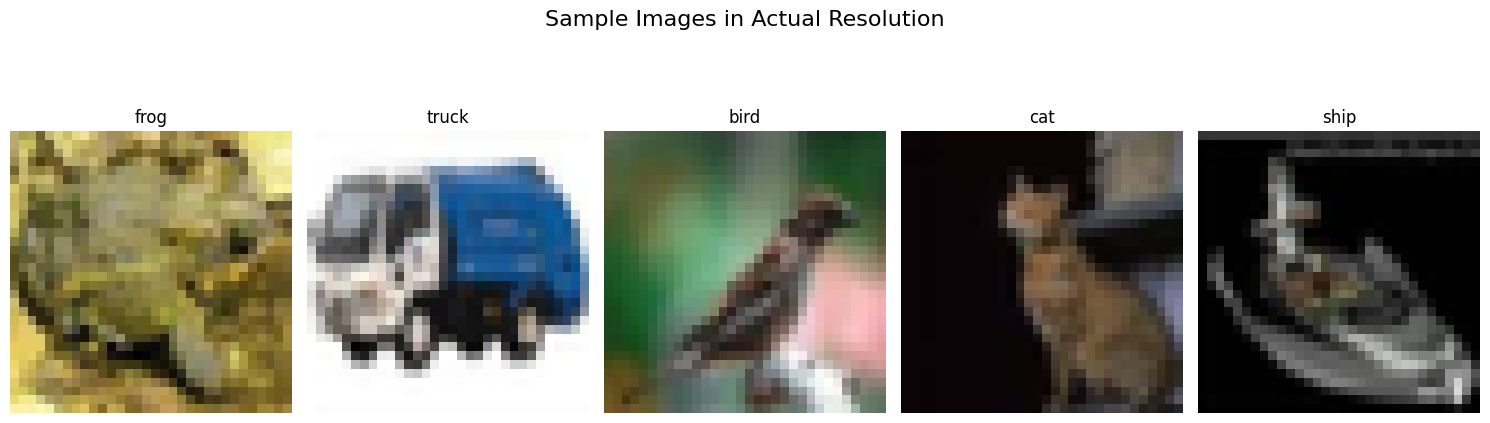

In [21]:
import random

# Display a few actual resolution images (5 different classes)
num_images_to_show = 5
selected_classes = random.sample(range(len(classes)), num_images_to_show)

plt.figure(figsize=(15, 5))
for i, class_idx in enumerate(selected_classes):
    # Find an image for the current class
    class_indices = [j for j, label in enumerate(trainset.targets) if label == class_idx]
    img_idx = random.choice(class_indices)
    image, _ = trainset[img_idx]
    
    ax = plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(image)
    plt.title(classes[class_idx])
    plt.axis('off')
plt.suptitle('Sample Images in Actual Resolution', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Are Images Blurry - Laplacian Variance

Average sharpness (Laplacian Variance) for 200 sample images: 2330.68
Min sharpness: 295.56
Max sharpness: 8515.48


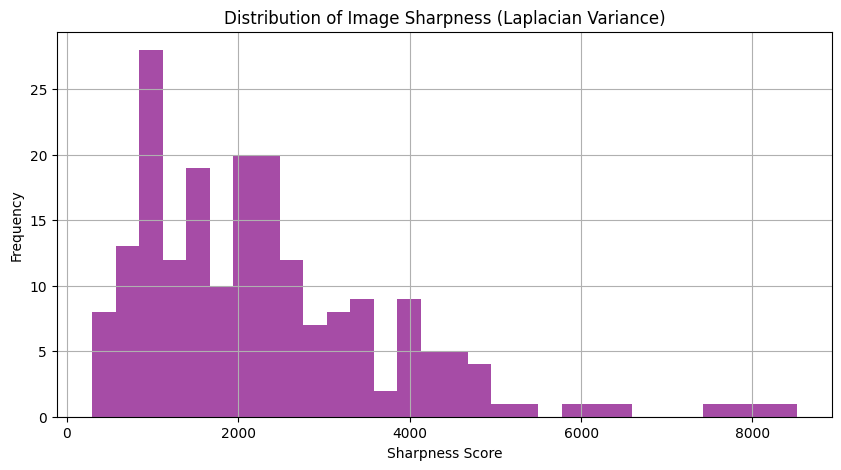

In [23]:
import cv2
from PIL import Image

# Function to calculate Laplacian variance (sharpness)
def calculate_laplacian_variance(image):
    # Convert PIL Image to NumPy array
    img_np = np.array(image)
    # Convert to grayscale
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    # Compute the Laplacian and then return the variance
    return cv2.Laplacian(gray, cv2.CV_64F).var()

# Randomly select 200 images from the training set
num_samples = 200
random_indices = random.sample(range(len(trainset)), num_samples)

sharpness_scores = []
for idx in random_indices:
    image, _ = trainset[idx]
    sharpness = calculate_laplacian_variance(image)
    sharpness_scores.append(sharpness)

# Print some statistics about the sharpness scores
print(f"Average sharpness (Laplacian Variance) for {num_samples} sample images: {np.mean(sharpness_scores):.2f}")
print(f"Min sharpness: {np.min(sharpness_scores):.2f}")
print(f"Max sharpness: {np.max(sharpness_scores):.2f}")

# Optionally, visualize the distribution of sharpness scores
plt.figure(figsize=(10, 5))
plt.hist(sharpness_scores, bins=30, color='purple', alpha=0.7)
plt.title('Distribution of Image Sharpness (Laplacian Variance)')
plt.xlabel('Sharpness Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


#### Laplacian Variance
The Laplacian variance is a simple way to check if an image is sharp or blurry. Here’s an easy explanation and step-by-step guide for setting a threshold in your scenario, especially for CIFAR images.

**Intuitive Understanding**
Imagine you have a coloring book. If you color very carefully, the lines (edges) are easy to see and the picture looks clear. But if you accidentally smudge the picture, the lines are hard to find and the picture looks blurry.

- The Laplacian is a math tool that looks for all those lines (edges) in a picture.
- After finding the lines, the Laplacian variance checks how “busy” those lines are. More lines and big changes mean a big number (sharp), and very few changes mean a small number (blurry).
- Computers do this by making a new image showing only the edges, then seeing how different the edge values are from each other using a math step called “variance.” If the variance is high, the image is clear. If it’s low, it’s blurry.

**How Laplacian Variance Is Computed**
- Turn your image gray so there is only one value per pixel.
- Use the Laplacian filter to make an “edges-only” picture.
- Take all those edge values and see how much they differ using variance:
- If all pixels look about the same (not many edges), the variance is low (blurry).
- If there are big changes between pixels (lots of edges), the variance is high (sharp).



Calculating sharpness for all training images...
Training sharpness calculation complete.
Calculating sharpness for all test images...
Test sharpness calculation complete.


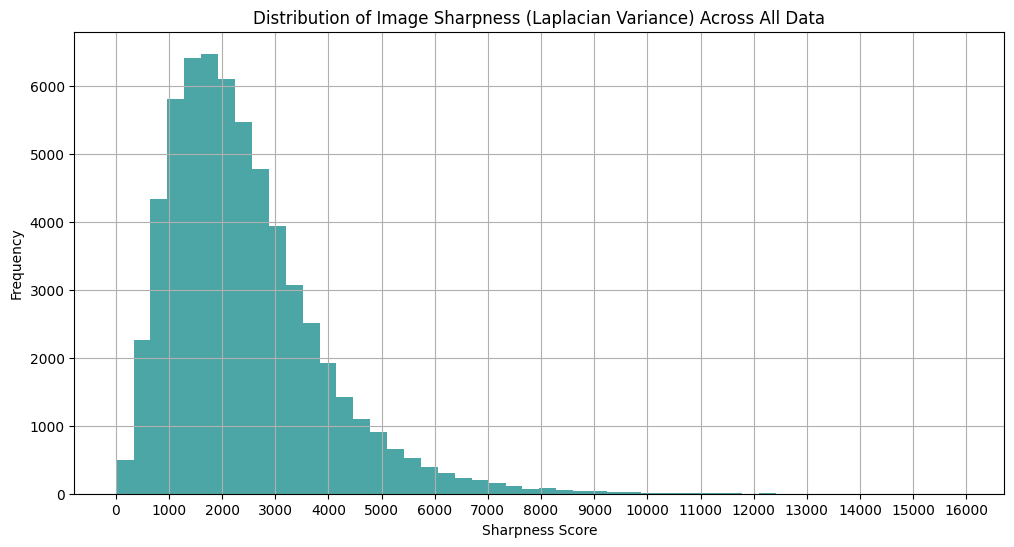


Overall sharpness (Laplacian Variance) for all images (train + test): 2415.33
Overall Min sharpness: 18.34
Overall Max sharpness: 15920.40


In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming calculate_laplacian_variance is defined in a previous cell or globally accessible
# If not, you might need to re-define it here or ensure previous cells are run.
# For this task, I will re-include the function for self-containment.

def calculate_laplacian_variance(image):
    # Convert PIL Image to NumPy array
    img_np = np.array(image)
    # Convert to grayscale
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    # Compute the Laplacian and then return the variance
    return cv2.Laplacian(gray, cv2.CV_64F).var()

print("Calculating sharpness for all training images...")
train_sharpness_scores = []
for i in range(len(trainset)):
    image, _ = trainset[i]
    sharpness = calculate_laplacian_variance(image)
    train_sharpness_scores.append(sharpness)
print("Training sharpness calculation complete.")

print("Calculating sharpness for all test images...")
test_sharpness_scores = []
for i in range(len(testset)):
    image, _ = testset[i]
    sharpness = calculate_laplacian_variance(image)
    test_sharpness_scores.append(sharpness)
print("Test sharpness calculation complete.")

all_sharpness_scores = train_sharpness_scores + test_sharpness_scores

plt.figure(figsize=(12, 6))
plt.hist(all_sharpness_scores, bins=50, color='teal', alpha=0.7)
plt.title('Distribution of Image Sharpness (Laplacian Variance) Across All Data')
plt.xlabel('Sharpness Score')
plt.ylabel('Frequency')
plt.grid(True)

# Set x-axis ticks at intervals of 1000
max_sharpness = int(np.max(all_sharpness_scores))
plt.xticks(np.arange(0, max_sharpness + 1000, 1000))

plt.show()

print(f"\nOverall sharpness (Laplacian Variance) for all images (train + test): {np.mean(all_sharpness_scores):.2f}")
print(f"Overall Min sharpness: {np.min(all_sharpness_scores):.2f}")
print(f"Overall Max sharpness: {np.max(all_sharpness_scores):.2f}")


Calculating sharpness for 1000 images...
Sharpness calculation complete.


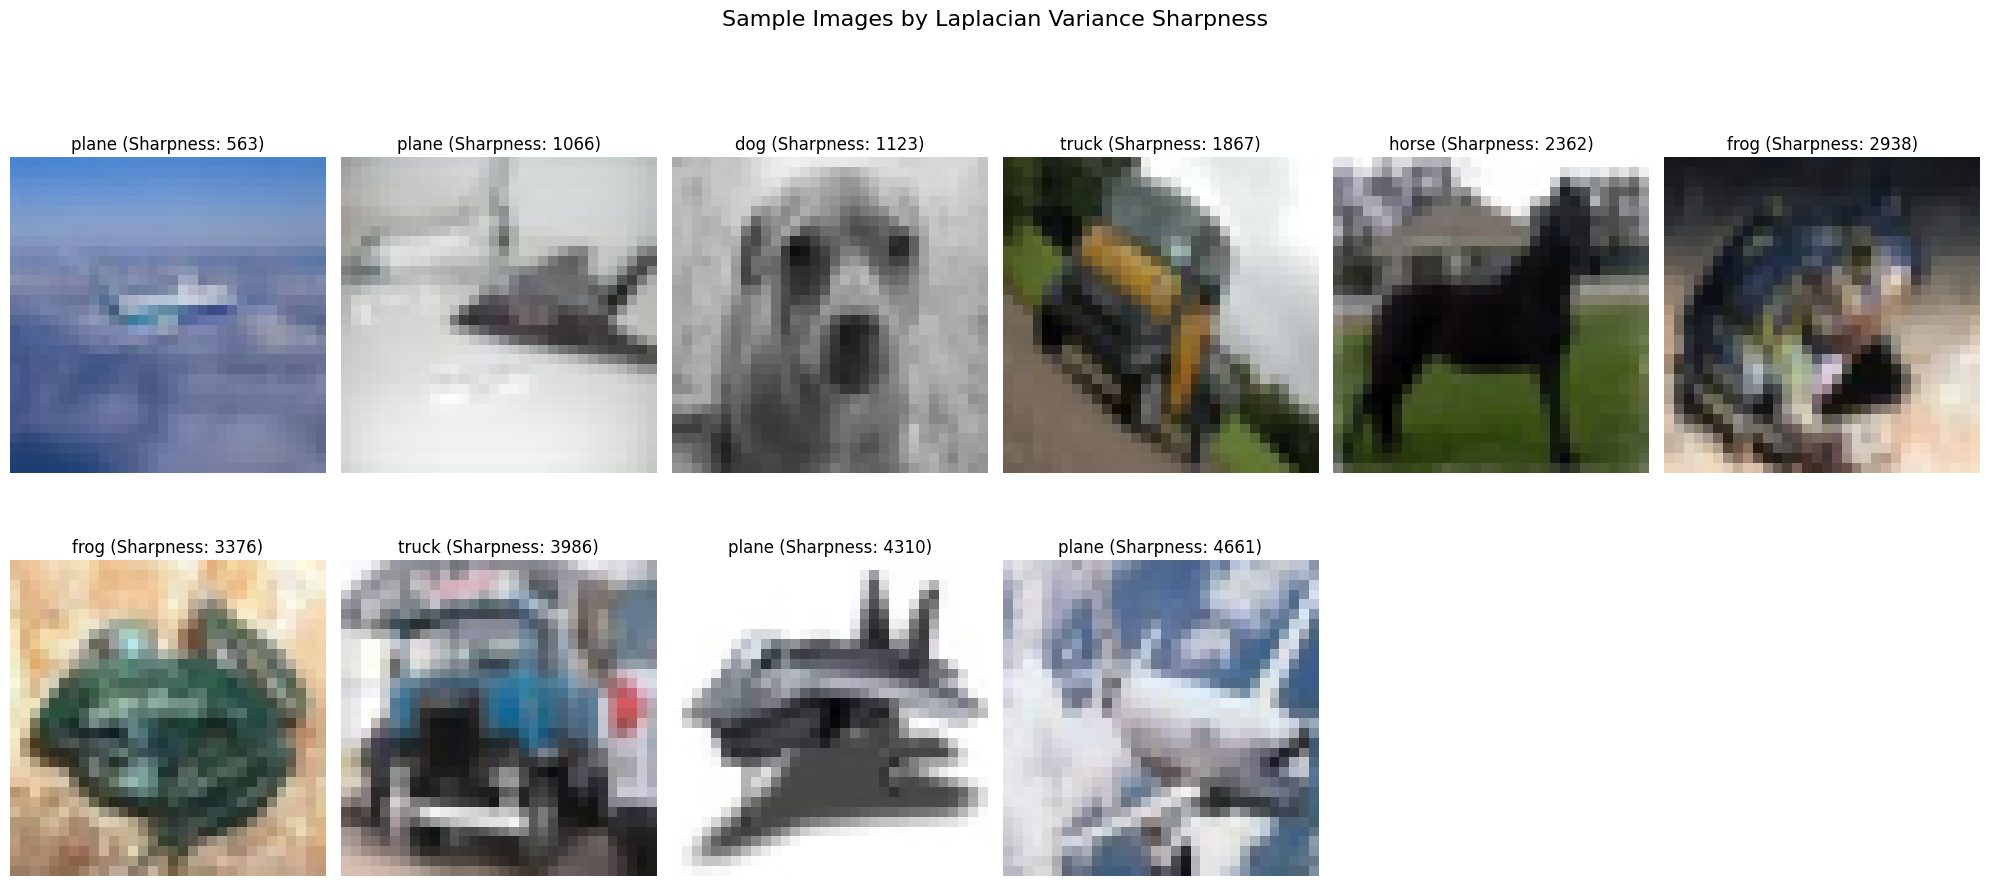

In [26]:
from collections import defaultdict

# Calculate sharpness for a larger sample or the entire dataset
# For demonstration, let's calculate for a larger sample, say 1000 images.
# In a real scenario, you might want to calculate for all images if performance allows.

num_full_samples = 1000  # Or len(trainset) for all images
all_sharpness_data = [] # Store (sharpness, image, class_label) tuples

# To avoid recalculating if already done for a large enough sample
# For simplicity, we'll re-calculate here.

print(f"Calculating sharpness for {num_full_samples} images...")
for i in range(num_full_samples):
    idx = random.randrange(len(trainset))
    image, label = trainset[idx]
    sharpness = calculate_laplacian_variance(image)
    all_sharpness_data.append((sharpness, image, classes[label]))
print("Sharpness calculation complete.")

# Define sharpness ranges and collect one image for each range
sharpness_ranges = range(100, 5001, 500)
selected_images_by_sharpness = {}

for sharpness_val, image, class_label in all_sharpness_data:
    for r_start in sharpness_ranges:
        r_end = r_start + 500
        if r_start <= sharpness_val < r_end:
            if r_start not in selected_images_by_sharpness:
                selected_images_by_sharpness[r_start] = (image, sharpness_val, class_label)
            break

# Display the selected images
plt.figure(figsize=(20, 10))
plot_idx = 1

# Sort the keys to display in order
for r_start in sorted(selected_images_by_sharpness.keys()):
    image, sharpness_val, class_label = selected_images_by_sharpness[r_start]
    ax = plt.subplot(2, len(sharpness_ranges) // 2 + 1, plot_idx) # Adjust subplot grid as needed
    plt.imshow(image)
    plt.title(f'{class_label} (Sharpness: {sharpness_val:.0f})')
    plt.axis('off')
    plot_idx += 1

plt.suptitle('Sample Images by Laplacian Variance Sharpness', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


#### Link to Laplacian Artefact
Here is a link for a basic intuition behind Laplacian Varaince - [Link](https://claude.ai/public/artifacts/24097cd1-629c-44e2-a62a-004dd4a91995)

#### Before - After (Sharpening Kernel)

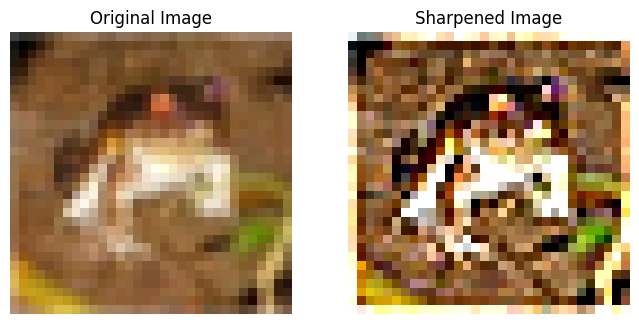

In [28]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define sharpening function
def sharpen_image(img_tensor):
    kernel = torch.tensor([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]], dtype=torch.float32)
    kernel = kernel.view(1, 1, 3, 3)
    kernel = kernel.repeat(3, 1, 1, 1)
    img_tensor = img_tensor.unsqueeze(0) # Add batch dimension
    sharp_img_tensor = F.conv2d(img_tensor, kernel, padding=1, groups=3)
    # Clamp pixel values to [0,1]
    sharp_img_tensor = torch.clamp(sharp_img_tensor, 0, 1)
    return sharp_img_tensor.squeeze(0) # Remove batch dimension

# Get a sample CIFAR-10 image (PIL Image)
raw_img, label = trainset[0]  # pick first image

# Convert PIL Image to PyTorch Tensor
transformer = transforms.ToTensor()
img_tensor = transformer(raw_img)

# Sharpen the image
sharp_img_tensor = sharpen_image(img_tensor)

# Convert tensors to numpy for displaying
img_np = img_tensor.permute(1,2,0).numpy()
sharp_img_np = sharp_img_tensor.permute(1,2,0).detach().numpy()

# Display before and after images
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img_np)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(sharp_img_np)
plt.title('Sharpened Image')
plt.axis('off')

plt.show()


### See Image Brightness

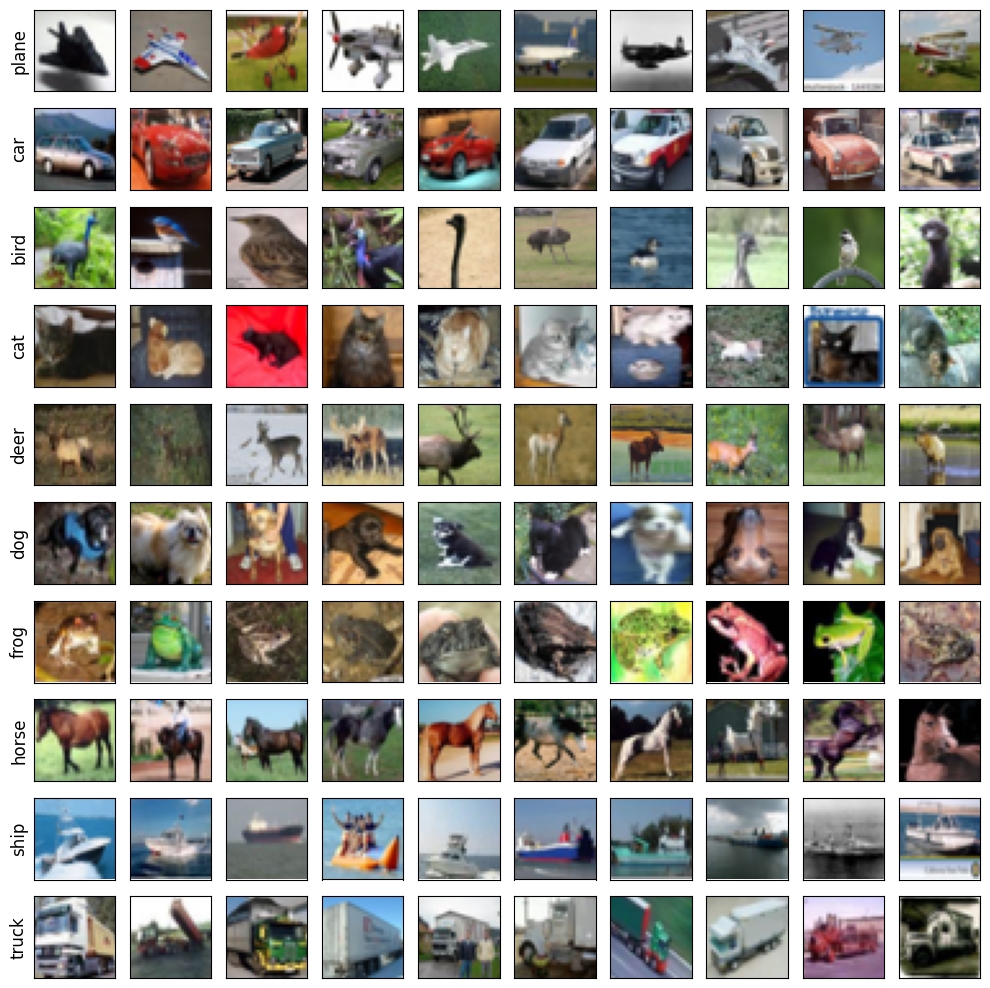

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show 10 thumbnails per class
def show_class_thumbnails(dataset, classes, num_thumbnails_per_class=10):
    fig = plt.figure(figsize=(num_thumbnails_per_class, len(classes)))
    for i, class_name in enumerate(classes):
        class_indices = [j for j, label in enumerate(dataset.targets) if label == i]
        for k in range(num_thumbnails_per_class):
            ax = fig.add_subplot(len(classes), num_thumbnails_per_class, i * num_thumbnails_per_class + k + 1, xticks=[], yticks=[])
            img, label = dataset[class_indices[k]]
            ax.imshow(img)
            if k == 0:
                ax.set_ylabel(class_name, rotation=90, size='large')
    plt.tight_layout()
    plt.show()

# Show thumbnails for training set
show_class_thumbnails(trainset, classes)


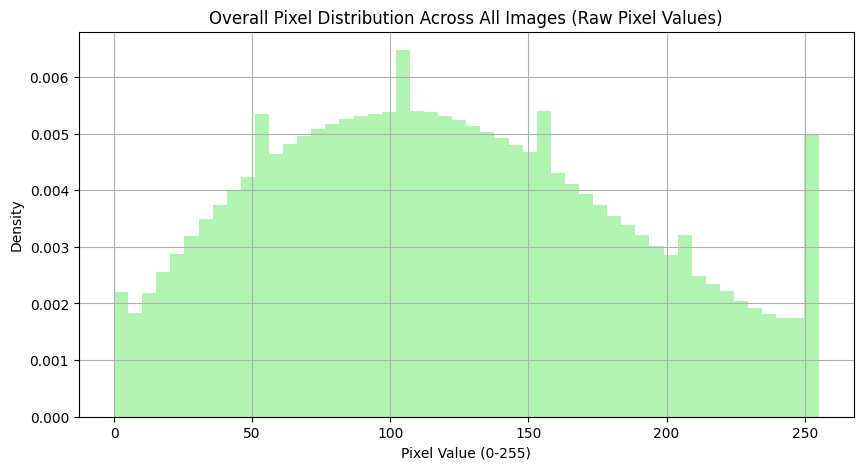

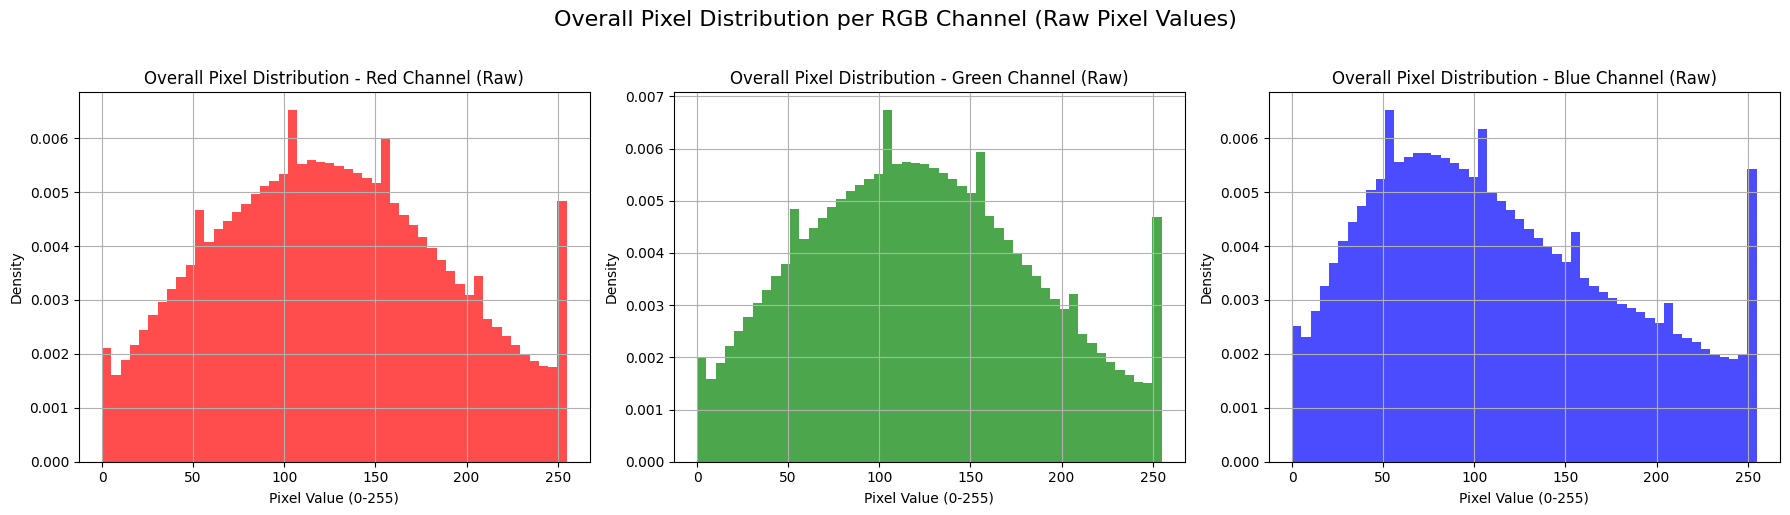

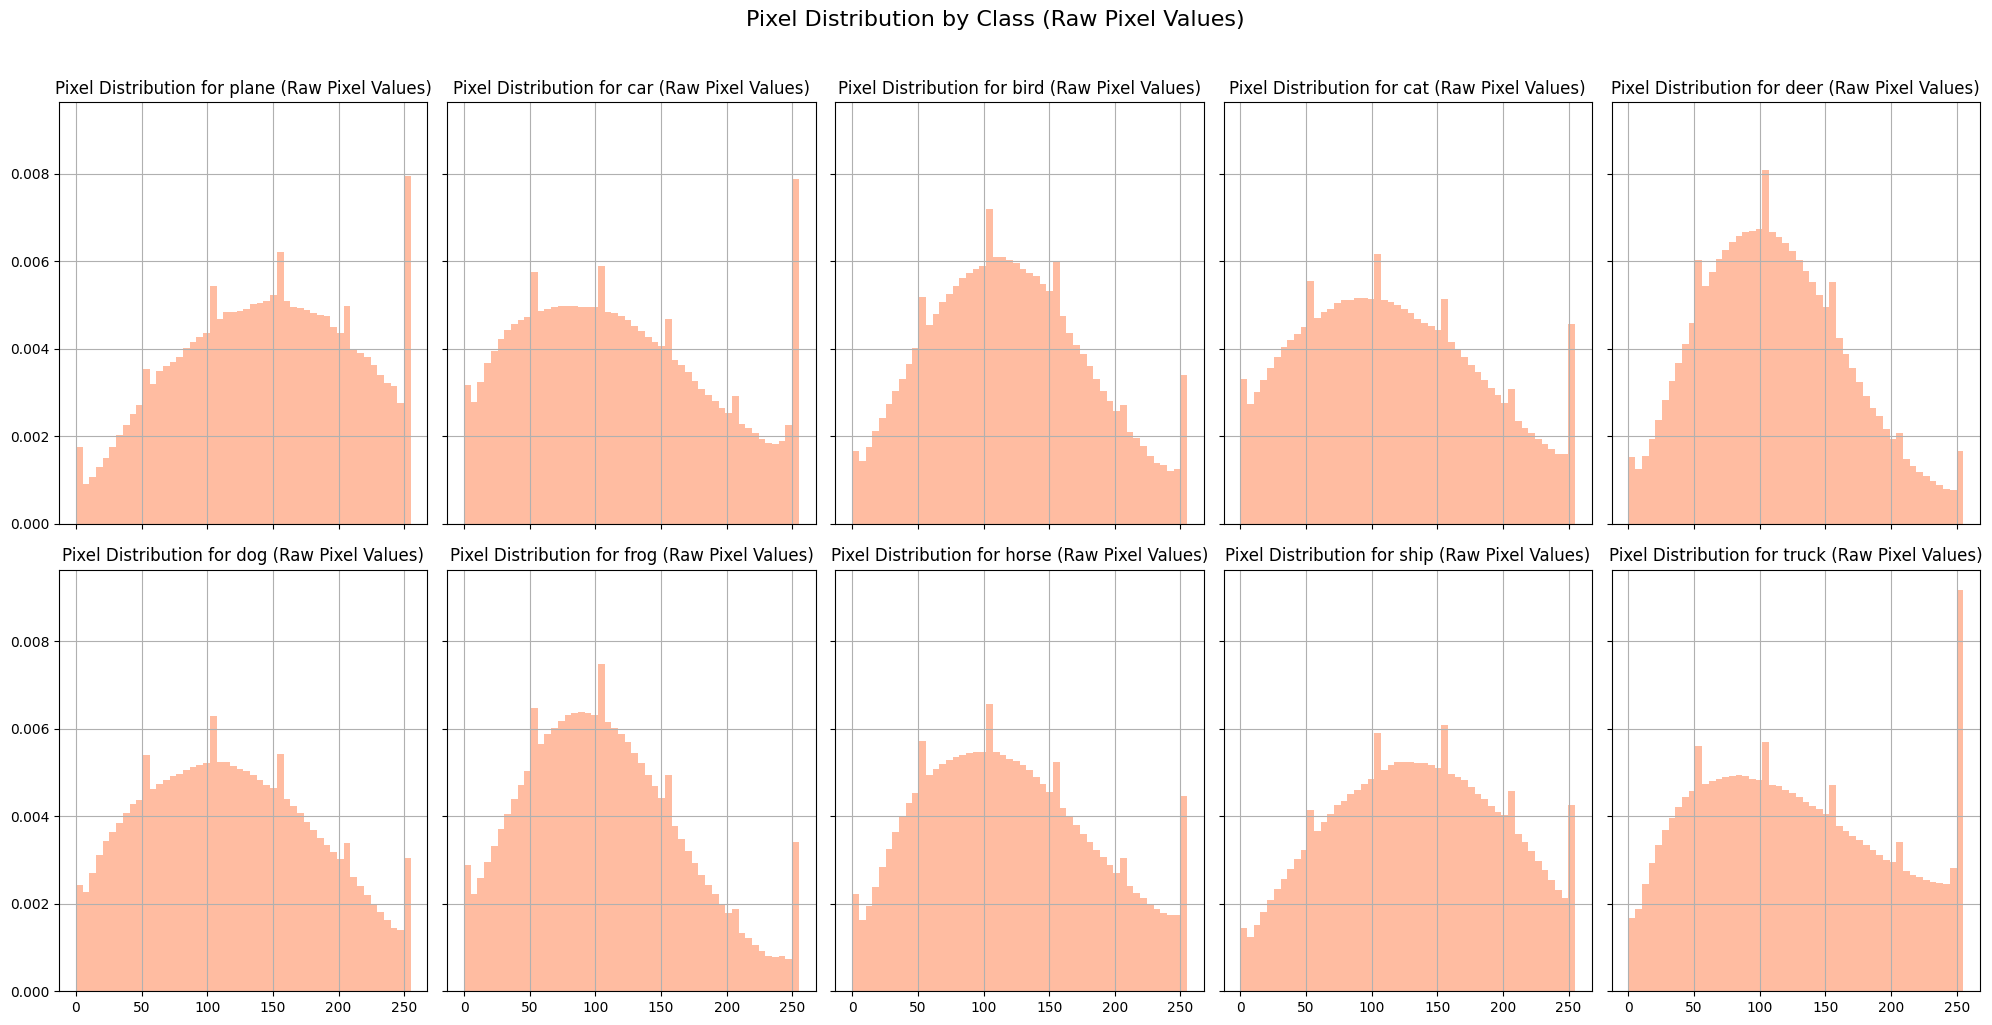

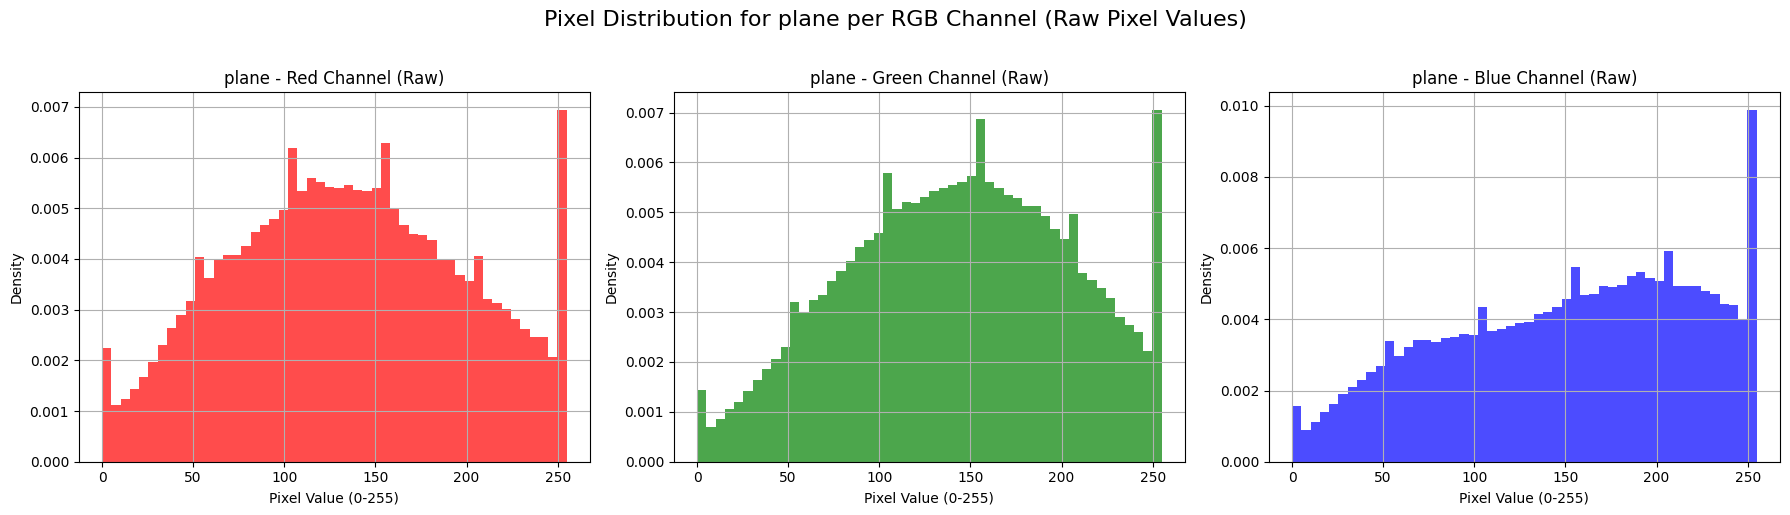

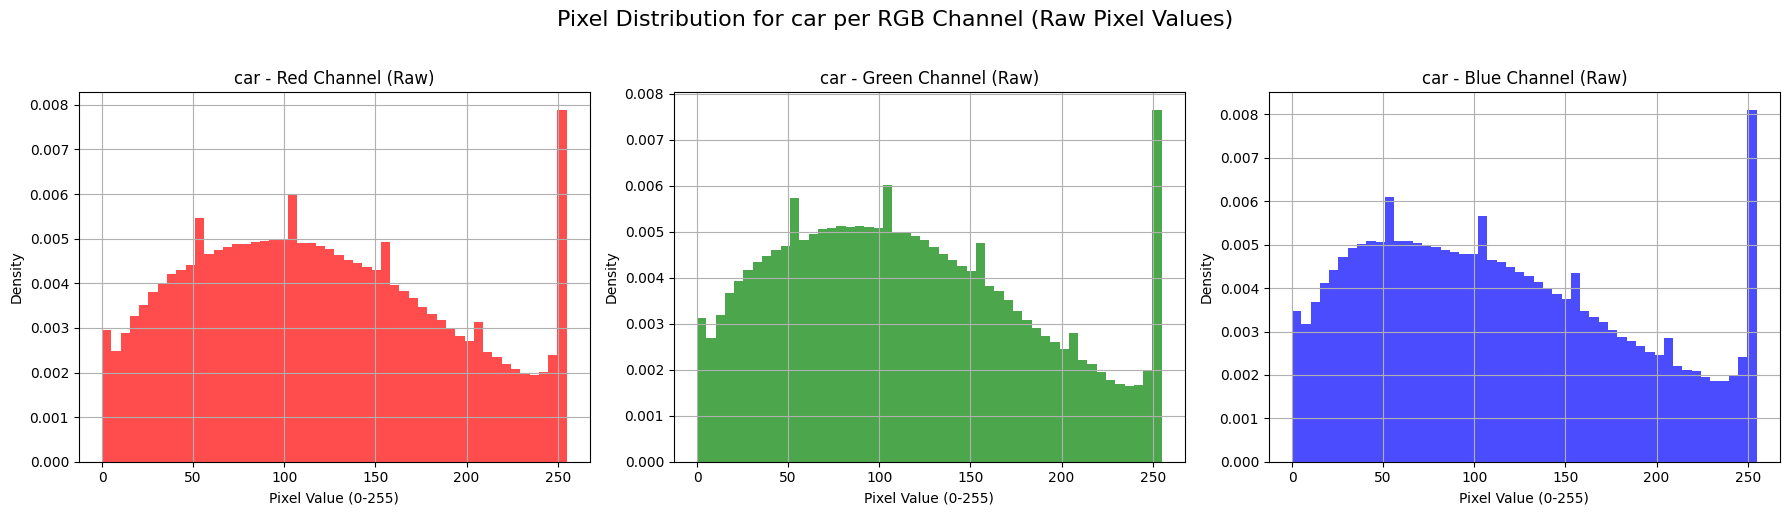

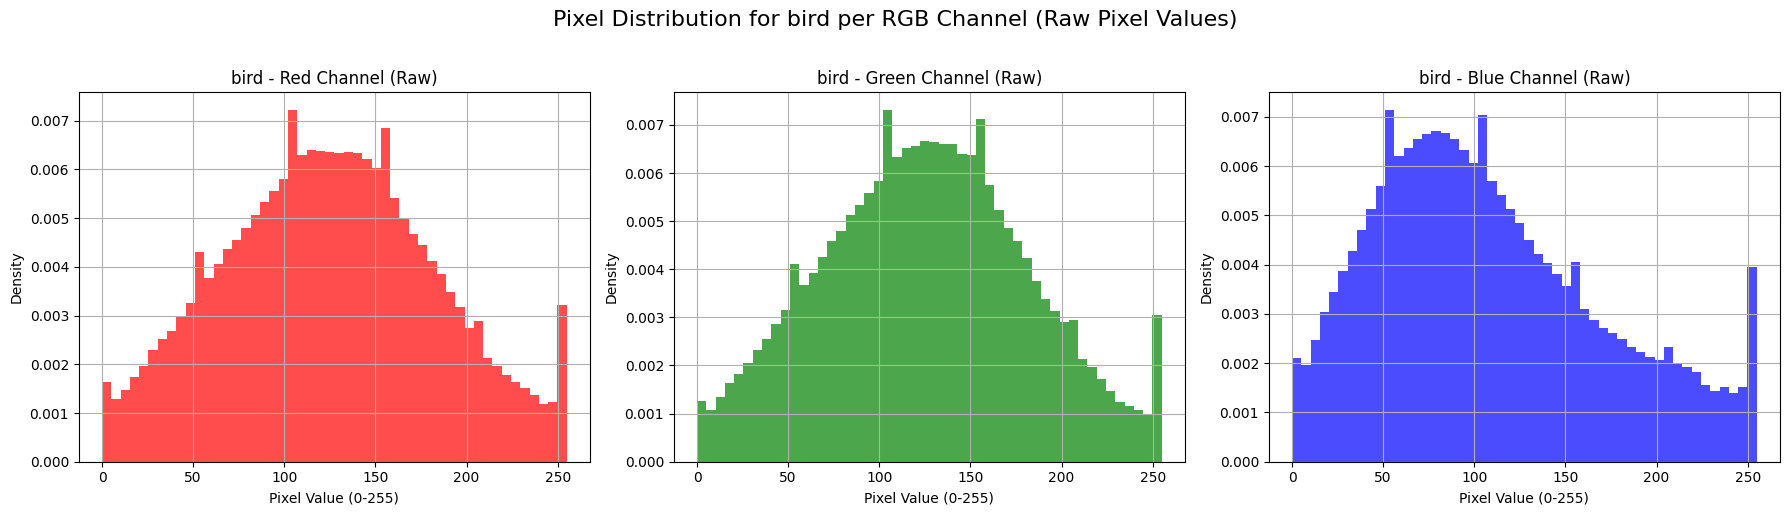

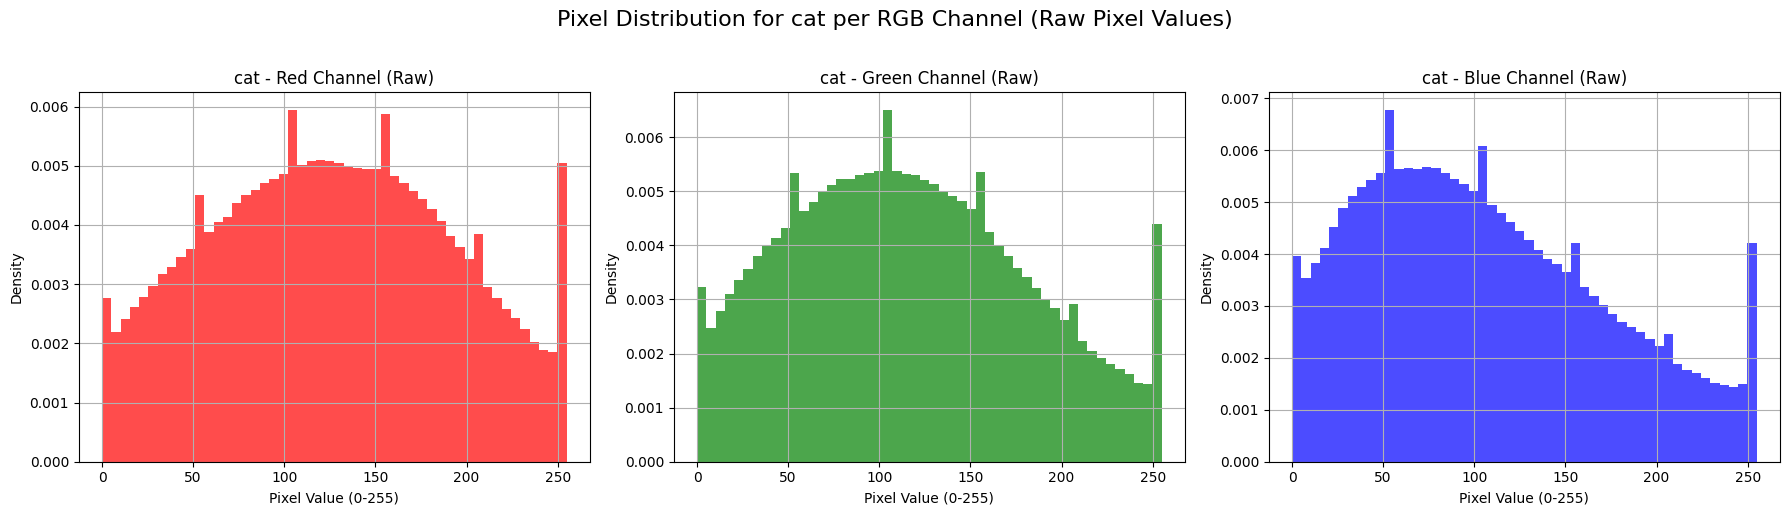

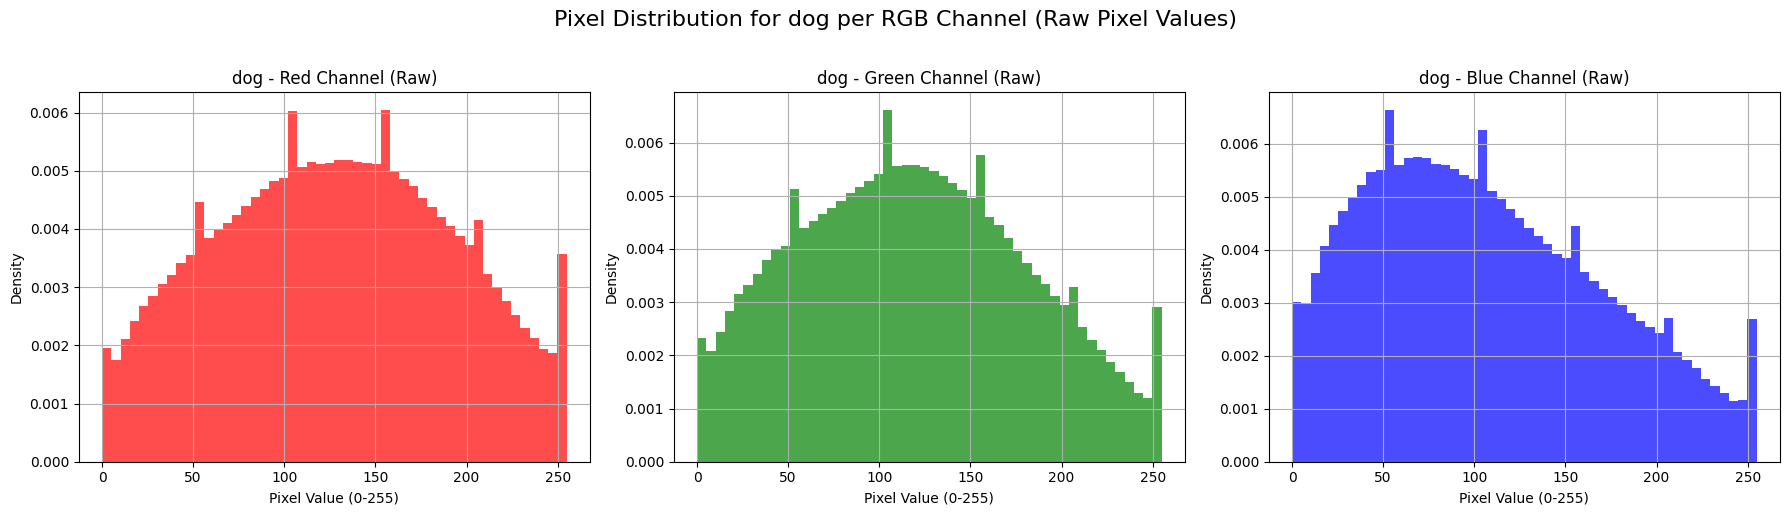

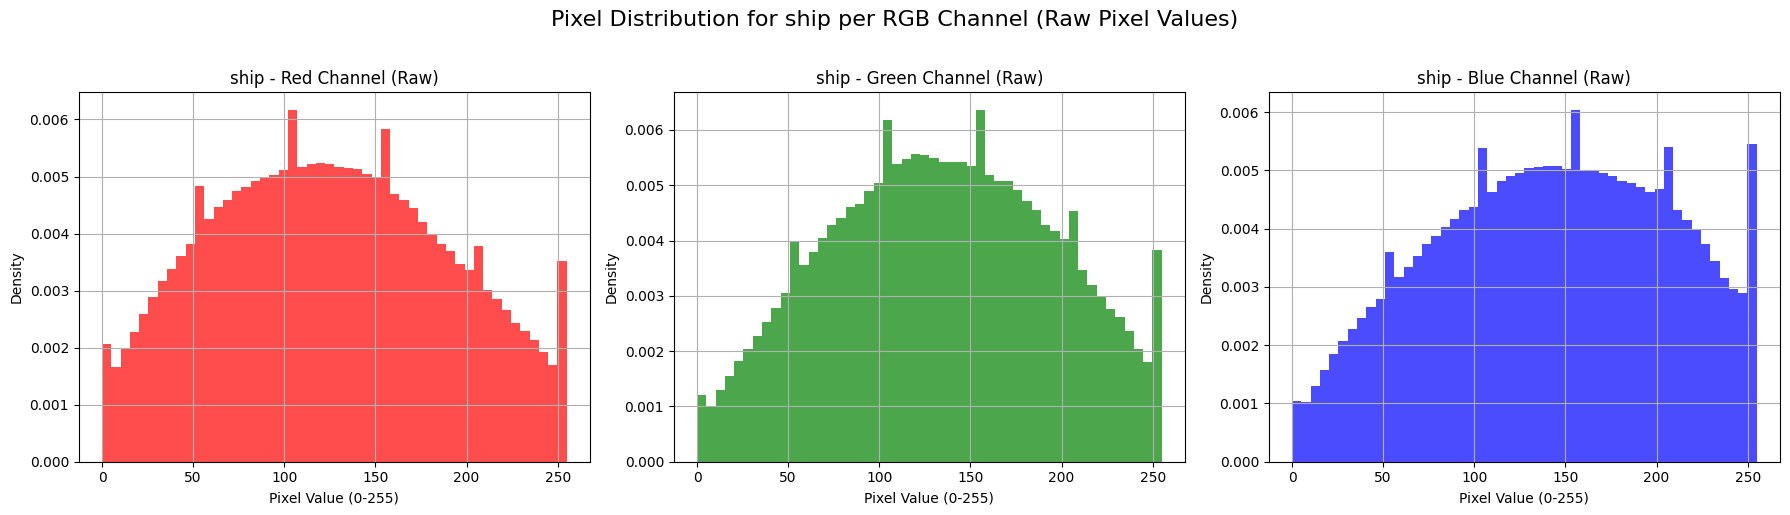

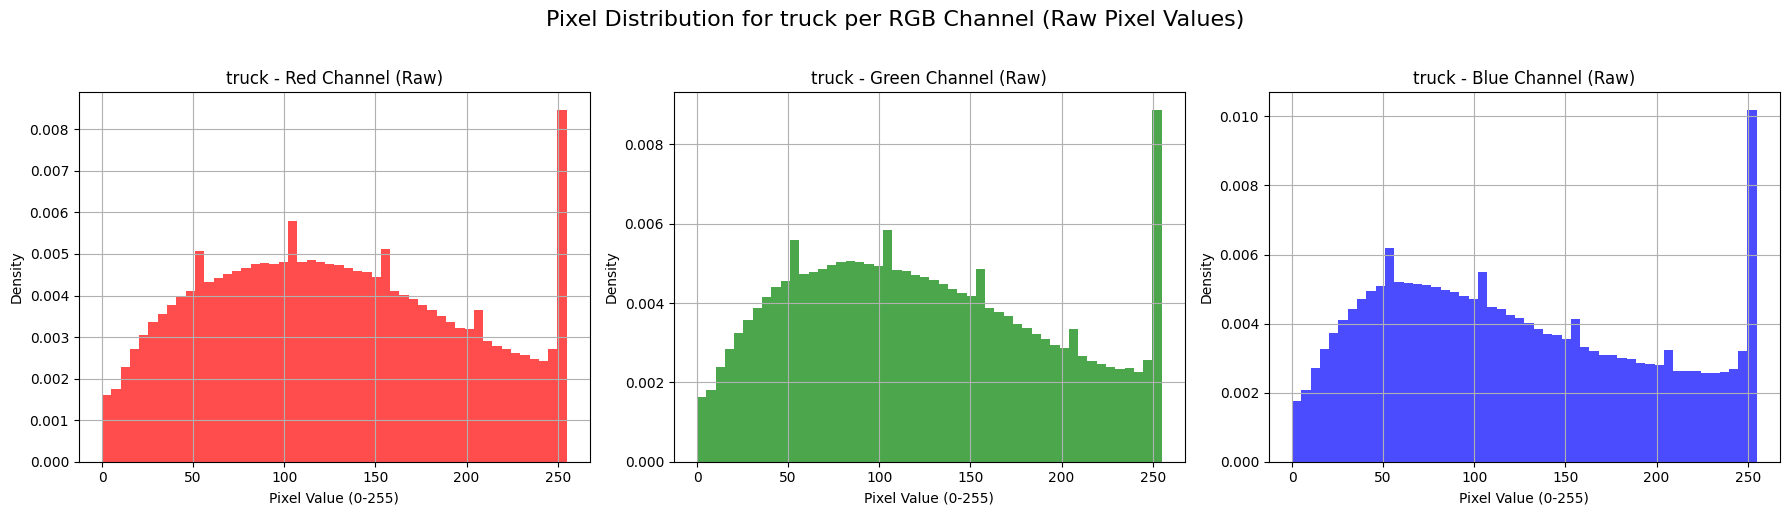

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Combine train and test datasets for overall pixel distribution analysis (without normalization)
combined_data_raw = np.concatenate((trainset.data, testset.data), axis=0)

# Flatten pixel values to [0, 255] for distribution analysis
all_pixels_raw = combined_data_raw.flatten()

# Overall pixel distribution without normalization
plt.figure(figsize=(10, 5))
plt.hist(all_pixels_raw, bins=50, density=True, color='lightgreen', alpha=0.7)
plt.title('Overall Pixel Distribution Across All Images (Raw Pixel Values)')
plt.xlabel('Pixel Value (0-255)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Overall pixel distribution for each RGB channel without normalization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['red', 'green', 'blue']
titles = ['Red Channel', 'Green Channel', 'Blue Channel']

for i in range(3):
    axes[i].hist(combined_data_raw[:, :, :, i].flatten(), bins=50, density=True, color=colors[i], alpha=0.7)
    axes[i].set_title(f'Overall Pixel Distribution - {titles[i]} (Raw)')
    axes[i].set_xlabel('Pixel Value (0-255)')
    axes[i].set_ylabel('Density')
    axes[i].grid(True)
plt.suptitle('Overall Pixel Distribution per RGB Channel (Raw Pixel Values)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Pixel distribution by class without normalization
fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, class_name in enumerate(classes):
    class_indices_train = [j for j, label in enumerate(trainset.targets) if label == i]
    class_indices_test = [j for j, label in enumerate(testset.targets) if label == i]
    
    class_data_train = trainset.data[class_indices_train]
    class_data_test = testset.data[class_indices_test]
    
    class_combined_data_raw = np.concatenate((class_data_train, class_data_test), axis=0)
    class_pixels_raw = class_combined_data_raw.flatten()
    
    axes[i].hist(class_pixels_raw, bins=50, density=True, color='lightsalmon', alpha=0.7)
    axes[i].set_title(f'Pixel Distribution for {class_name} (Raw Pixel Values)')
    axes[i].grid(True)

plt.suptitle('Pixel Distribution by Class (Raw Pixel Values)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Pixel distribution by class for each RGB channel without normalization
for i, class_name in enumerate(classes):
    class_indices_train = [j for j, label in enumerate(trainset.targets) if label == i]
    class_indices_test = [j for j, label in enumerate(testset.targets) if label == i]
    
    class_data_train = trainset.data[class_indices_train]
    class_data_test = testset.data[class_indices_test]
    
    class_combined_data_raw = np.concatenate((class_data_train, class_data_test), axis=0)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for c in range(3):
        axes[c].hist(class_combined_data_raw[:, :, :, c].flatten(), bins=50, density=True, color=colors[c], alpha=0.7)
        axes[c].set_title(f'{class_name} - {titles[c]} (Raw)')
        axes[c].set_xlabel('Pixel Value (0-255)')
        axes[c].set_ylabel('Density')
        axes[c].grid(True)
    plt.suptitle(f'Pixel Distribution for {class_name} per RGB Channel (Raw Pixel Values)', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()


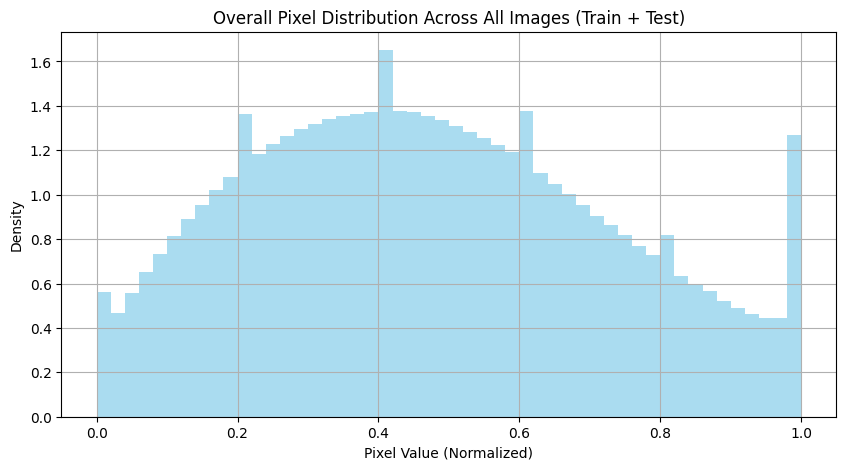

Normalization Parameters: {'mean': [0.49139967861920936, 0.48215840840079704, 0.446530914459704], 'std': [0.24703223245050313, 0.24348512800288716, 0.2615878417317208]}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Combine train and test datasets for overall pixel distribution analysis
combined_data = np.concatenate((trainset.data, testset.data), axis=0)

# Flatten and normalize pixel values to [0, 1] for distribution analysis
all_pixels = combined_data.flatten() / 255.0

# Overall pixel distribution
plt.figure(figsize=(10, 5))
plt.hist(all_pixels, bins=50, density=True, color='skyblue', alpha=0.7)
plt.title('Overall Pixel Distribution Across All Images (Train + Test)')
plt.xlabel('Pixel Value (Normalized)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Overall pixel distribution for each RGB channel (Normalized)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['red', 'green', 'blue']
titles = ['Red Channel', 'Green Channel', 'Blue Channel']

for i in range(3):
    axes[i].hist(combined_data[:, :, :, i].flatten() / 255.0, bins=50, density=True, color=colors[i], alpha=0.7)
    axes[i].set_title(f'Overall Pixel Distribution - {titles[i]} (Normalized)')
    axes[i].set_xlabel('Pixel Value (Normalized)')
    axes[i].set_ylabel('Density')
    axes[i].grid(True)
plt.suptitle('Overall Pixel Distribution per RGB Channel (Normalized Pixel Values)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Pixel distribution by class
fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, class_name in enumerate(classes):
    class_indices_train = [j for j, label in enumerate(trainset.targets) if label == i]
    class_indices_test = [j for j, label in enumerate(testset.targets) if label == i]
    
    class_data_train = trainset.data[class_indices_train]
    class_data_test = testset.data[class_indices_test]
    
    class_combined_data = np.concatenate((class_data_train, class_data_test), axis=0)
    class_pixels = class_combined_data.flatten() / 255.0
    
    axes[i].hist(class_pixels, bins=50, density=True, color='lightcoral', alpha=0.7)
    axes[i].set_title(f'Pixel Distribution for {class_name}')
    axes[i].grid(True)

plt.suptitle('Pixel Distribution by Class (Train + Test)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Pixel distribution by class for each RGB channel (Normalized)
for i, class_name in enumerate(classes):
    class_indices_train = [j for j, label in enumerate(trainset.targets) if label == i]
    class_indices_test = [j for j, label in enumerate(testset.targets) if label == i]
    
    class_data_train = trainset.data[class_indices_train]
    class_data_test = testset.data[class_indices_test]
    
    class_combined_data = np.concatenate((class_data_train, class_data_test), axis=0)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for c in range(3):
        axes[c].hist(class_combined_data[:, :, :, c].flatten() / 255.0, bins=50, density=True, color=colors[c], alpha=0.7)
        axes[c].set_title(f'{class_name} - {titles[c]} (Normalized)')
        axes[c].set_xlabel('Pixel Value (Normalized)')
        axes[c].set_ylabel('Density')
        axes[c].grid(True)
    plt.suptitle(f'Pixel Distribution for {class_name} per RGB Channel (Normalized Pixel Values)', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

# Compute mean and standard deviation for normalization
# It's good practice to compute mean and std on the training data only to prevent data leakage

# Convert trainset images to float and normalize to [0, 1] for calculation
train_images = np.array([np.array(trainset.data[i]) for i in range(len(trainset))]) / 255.0

mean_per_channel = np.mean(train_images, axis=(0, 1, 2))
std_per_channel = np.std(train_images, axis=(0, 1, 2))

normalization_params = {
    'mean': mean_per_channel.tolist(),
    'std': std_per_channel.tolist()
}

print(f"Normalization Parameters: {normalization_params}")


### Post Normalization

Normalized data collection complete.


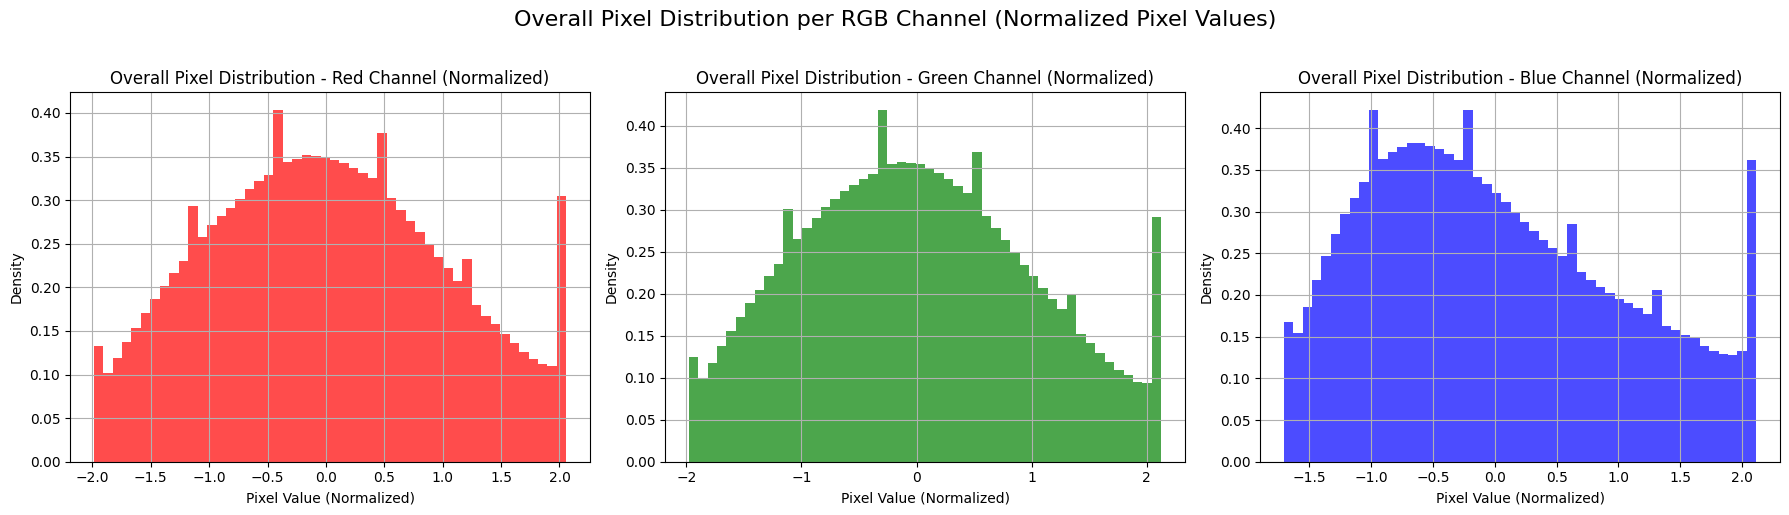

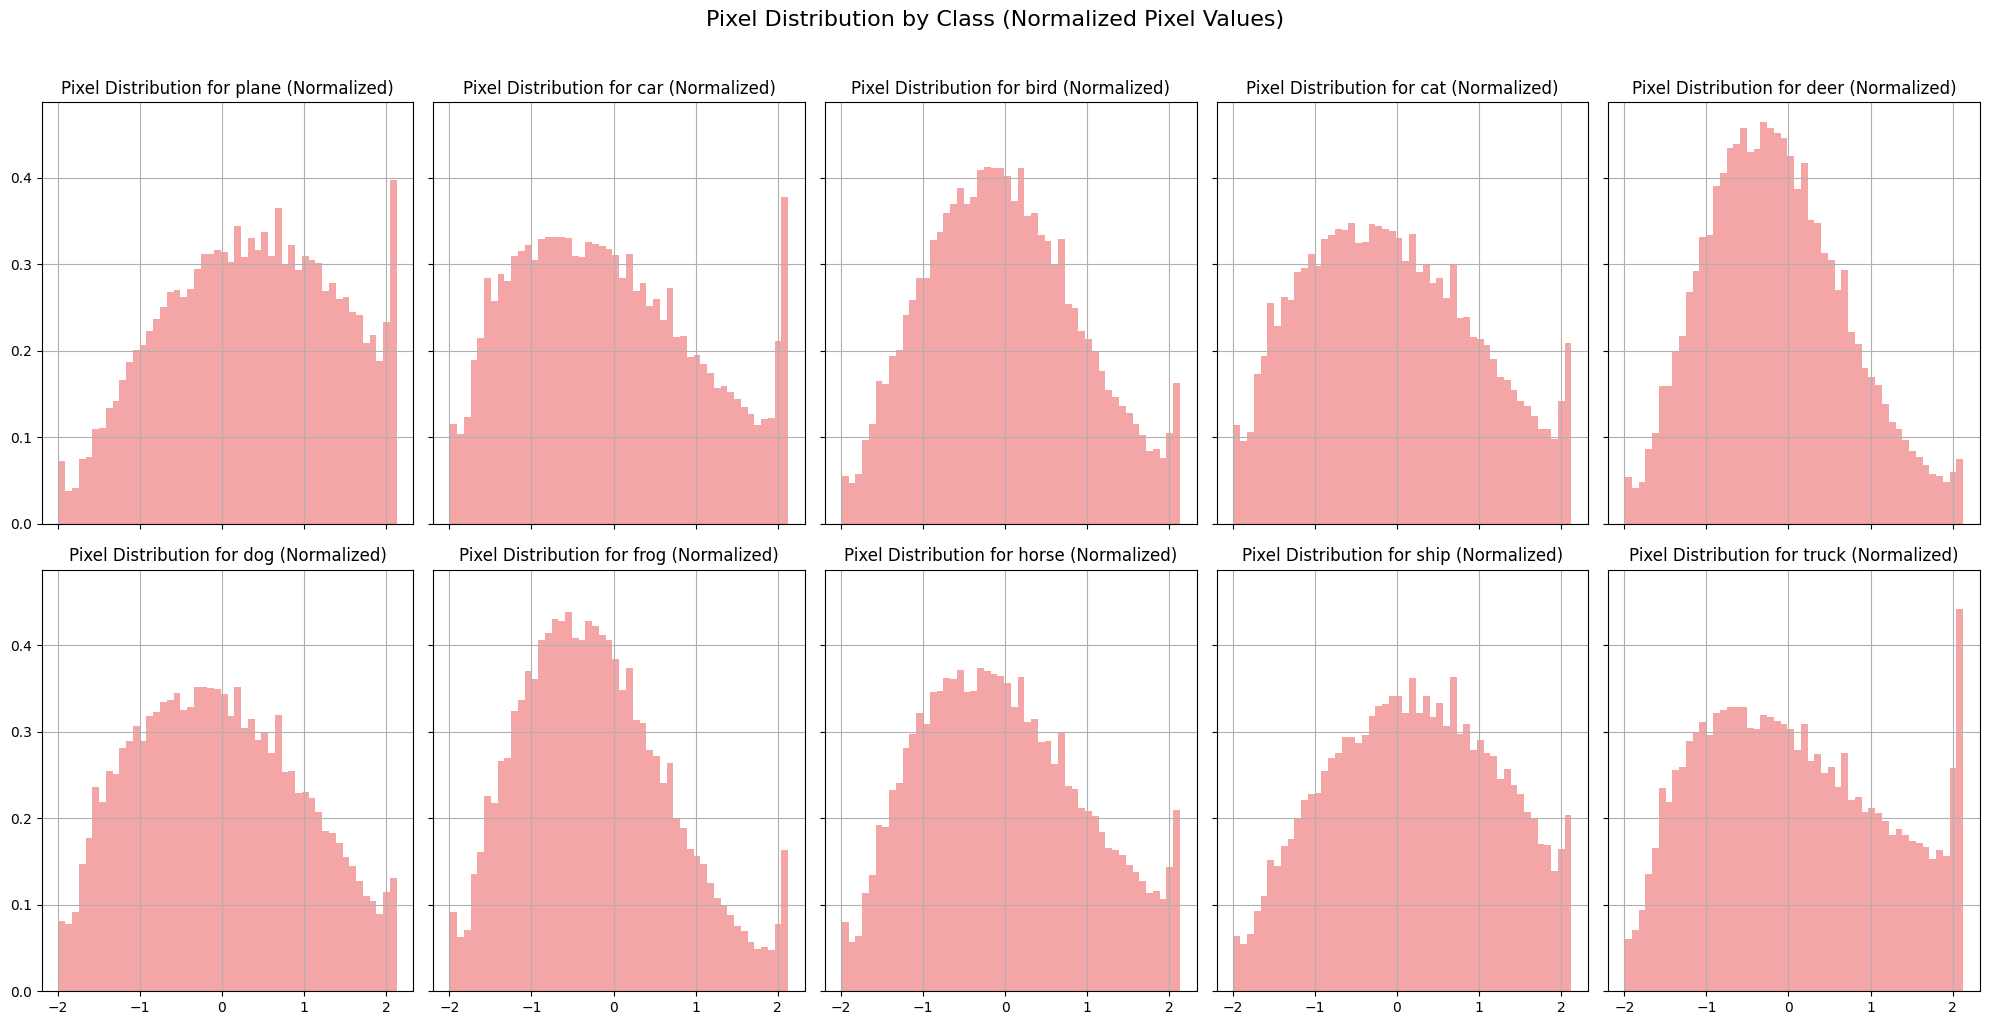

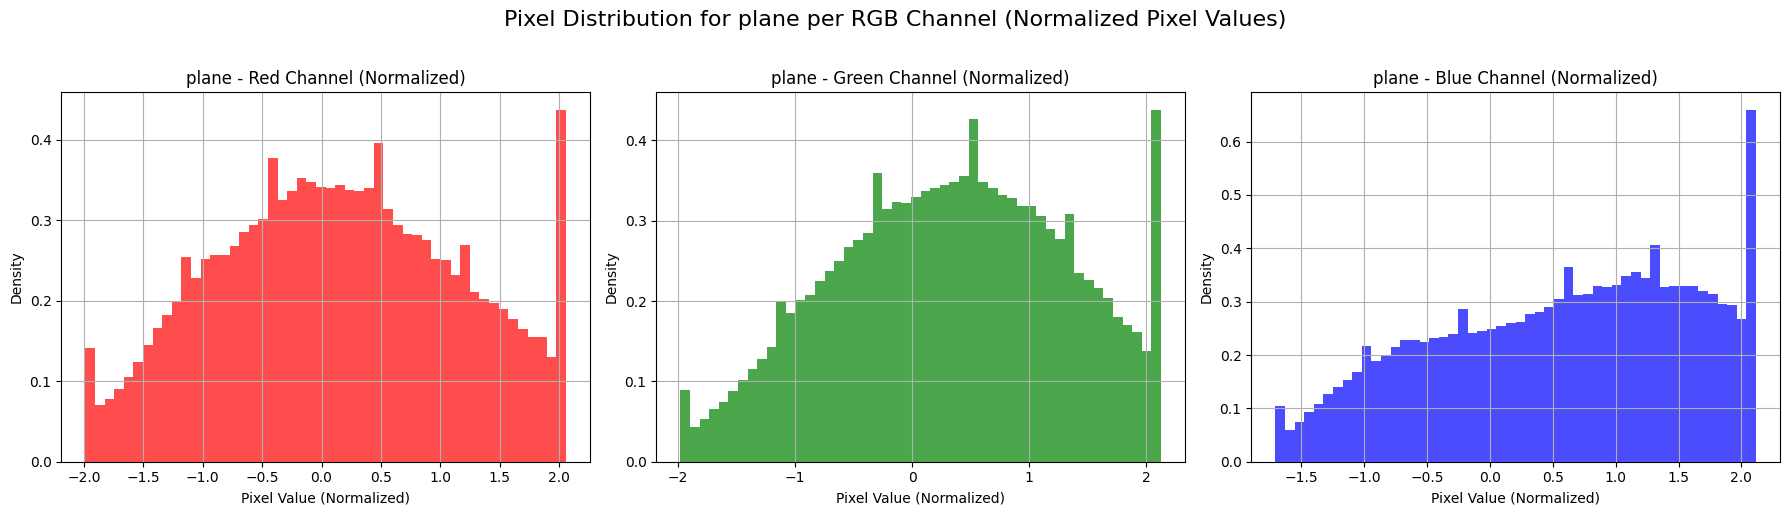

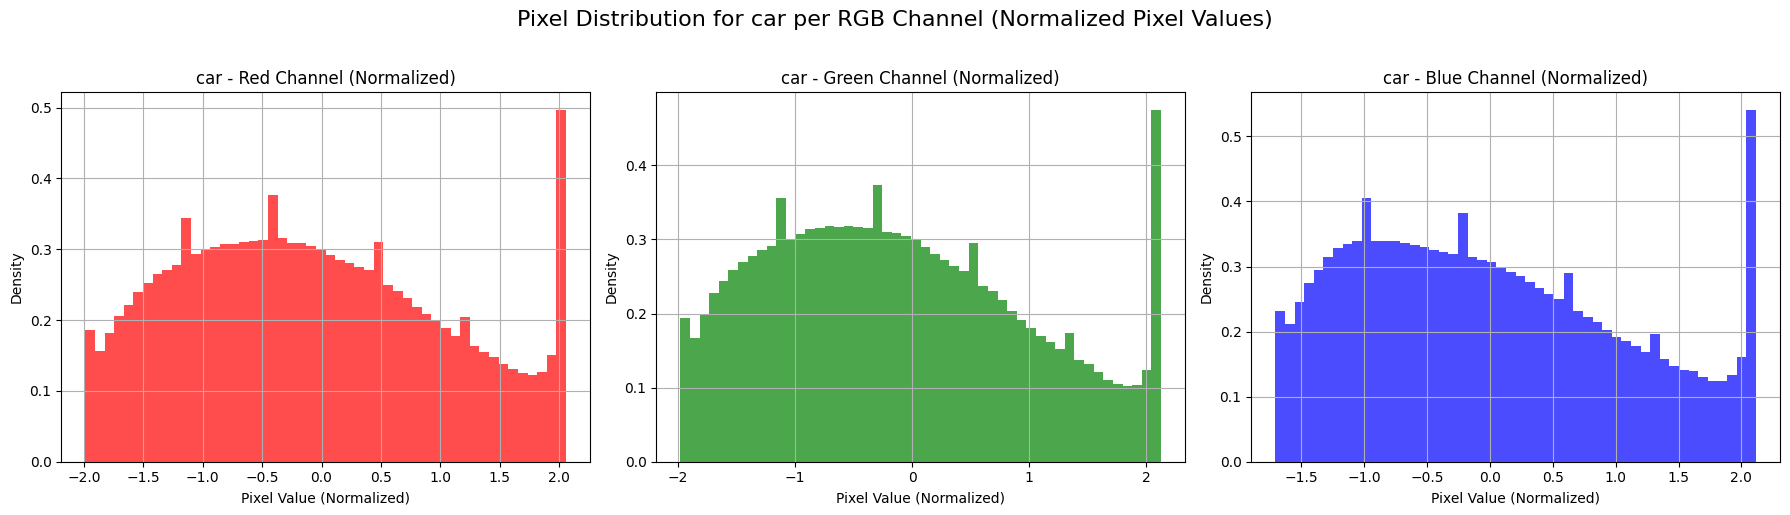

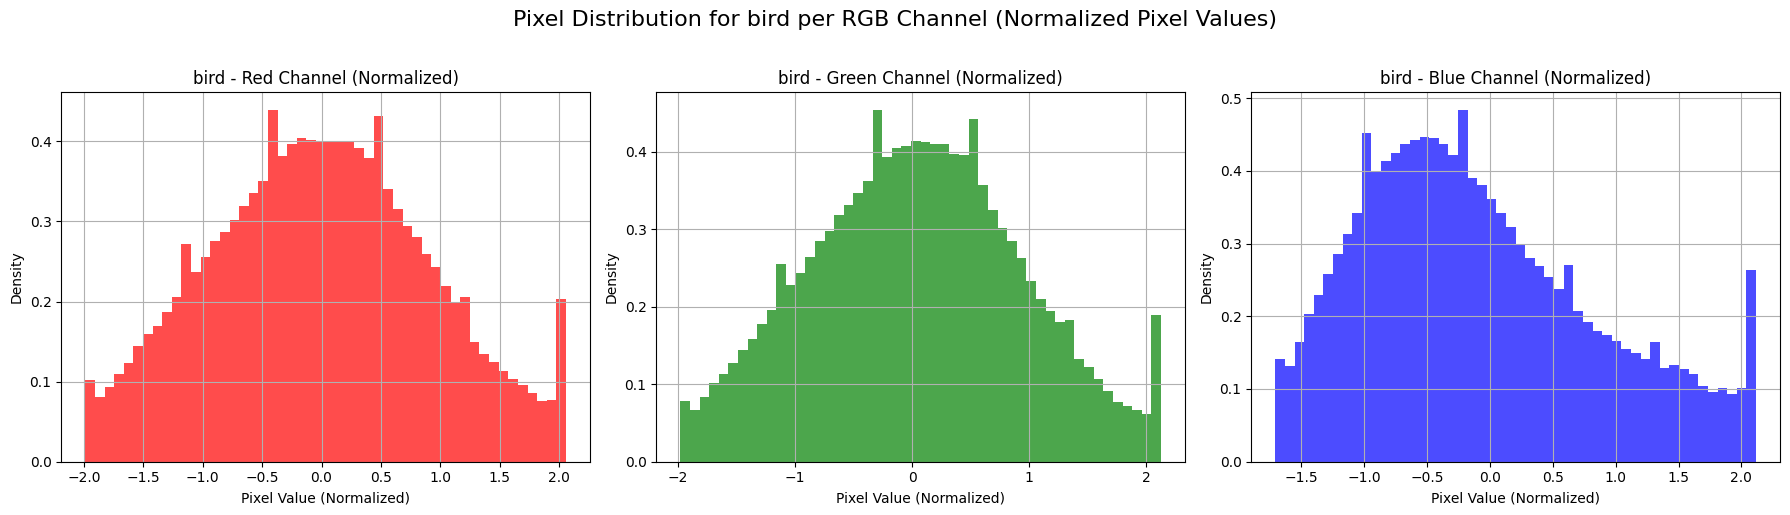

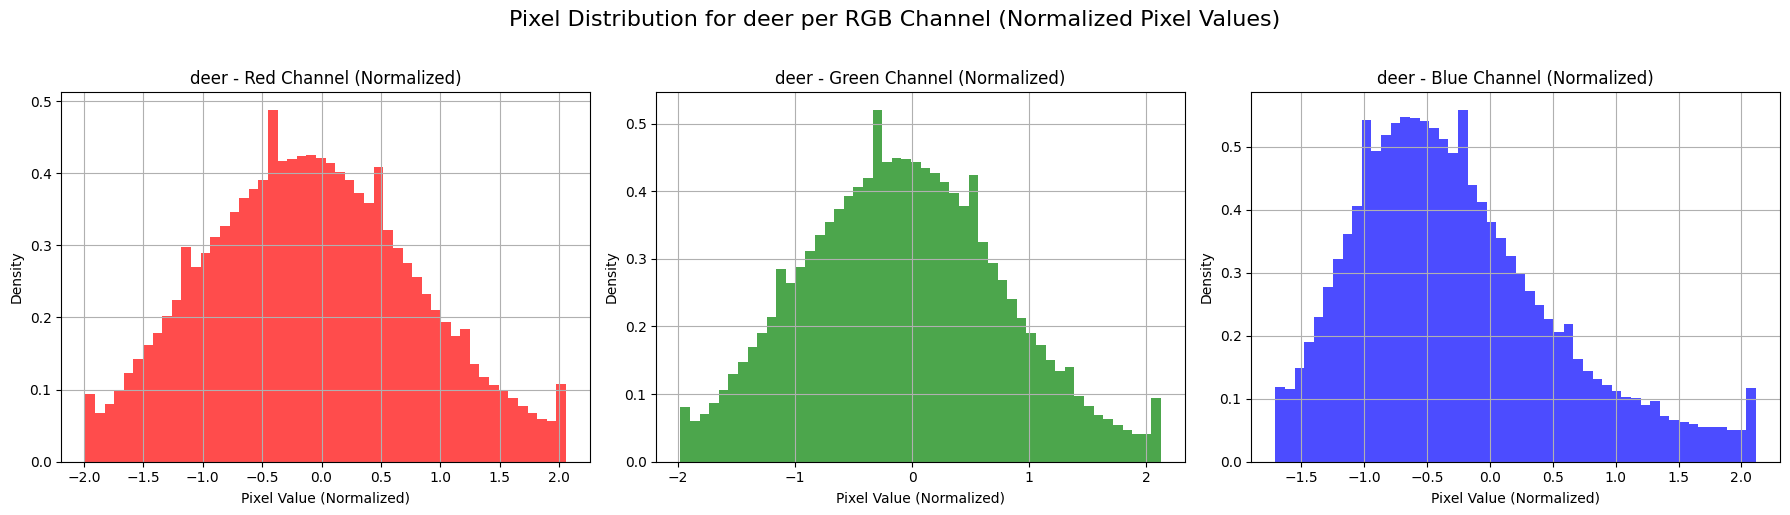

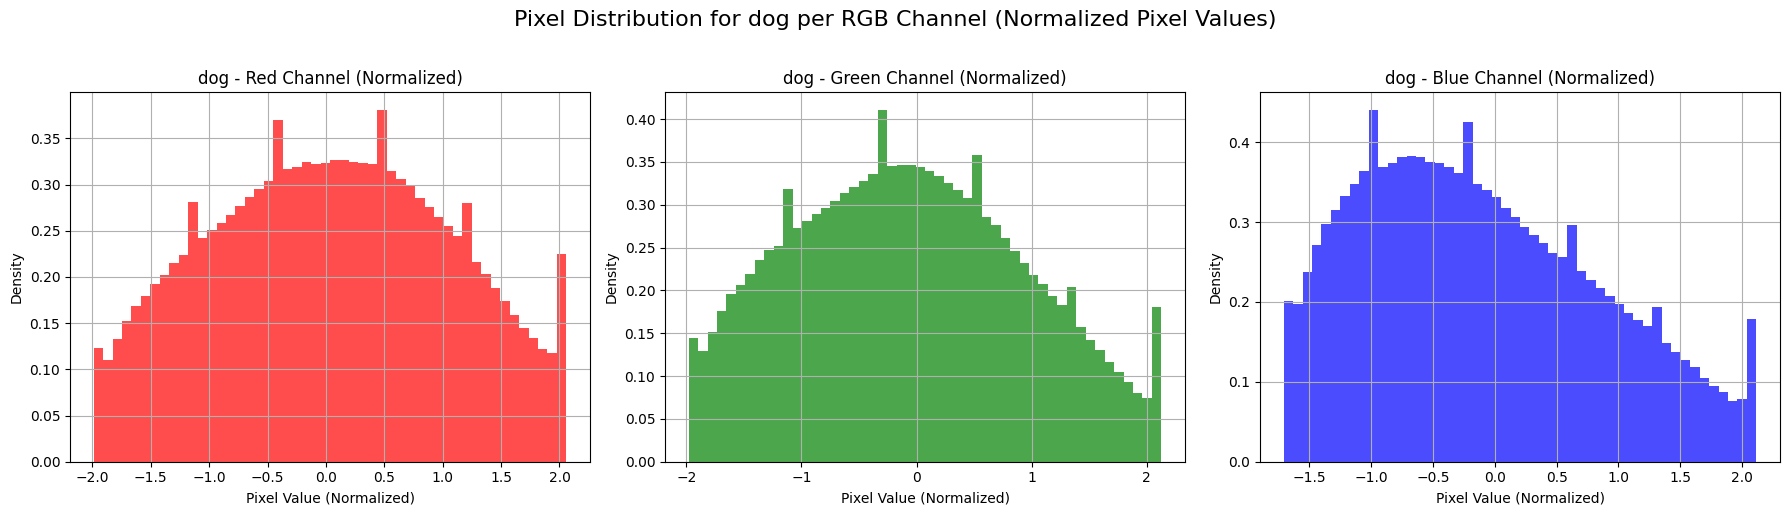

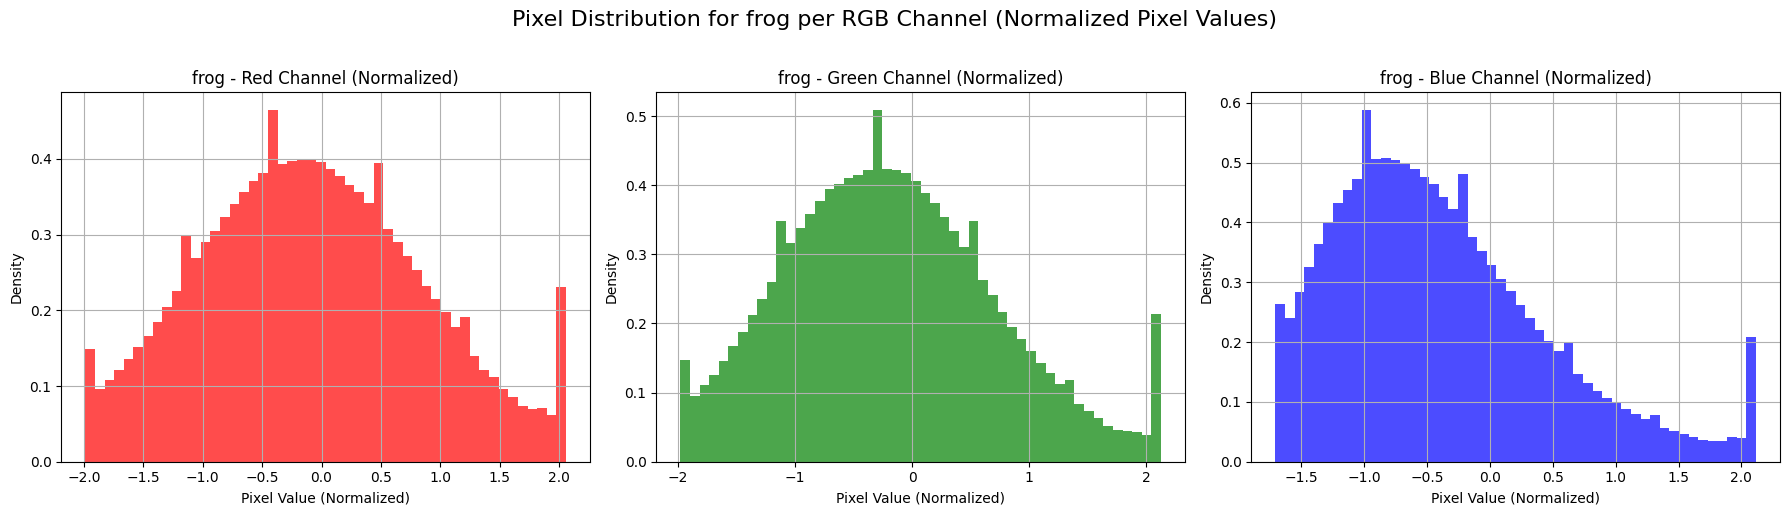

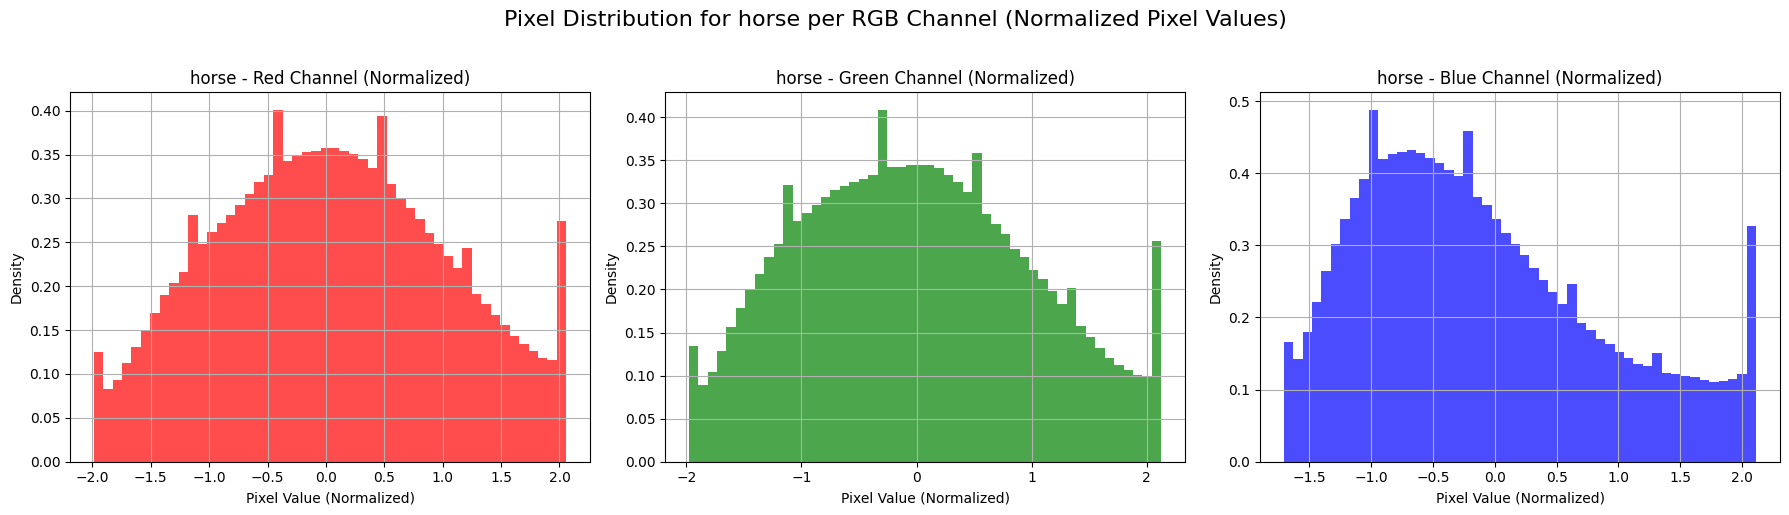

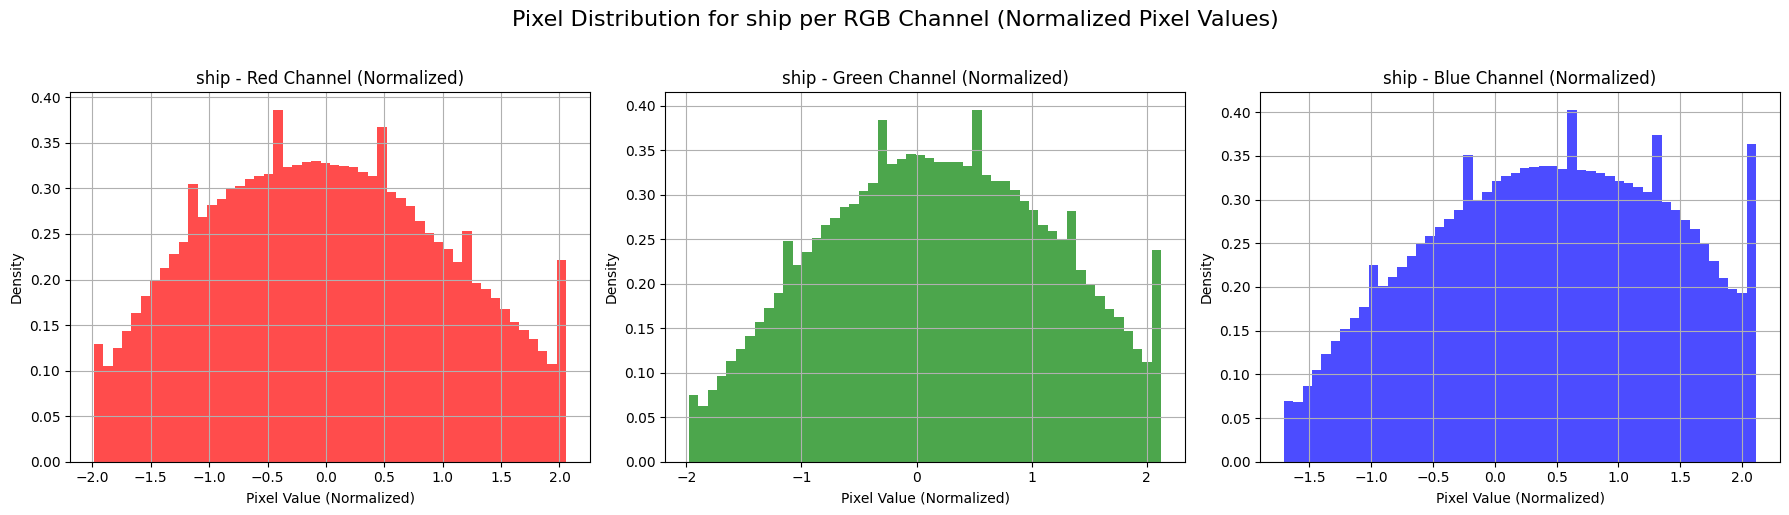

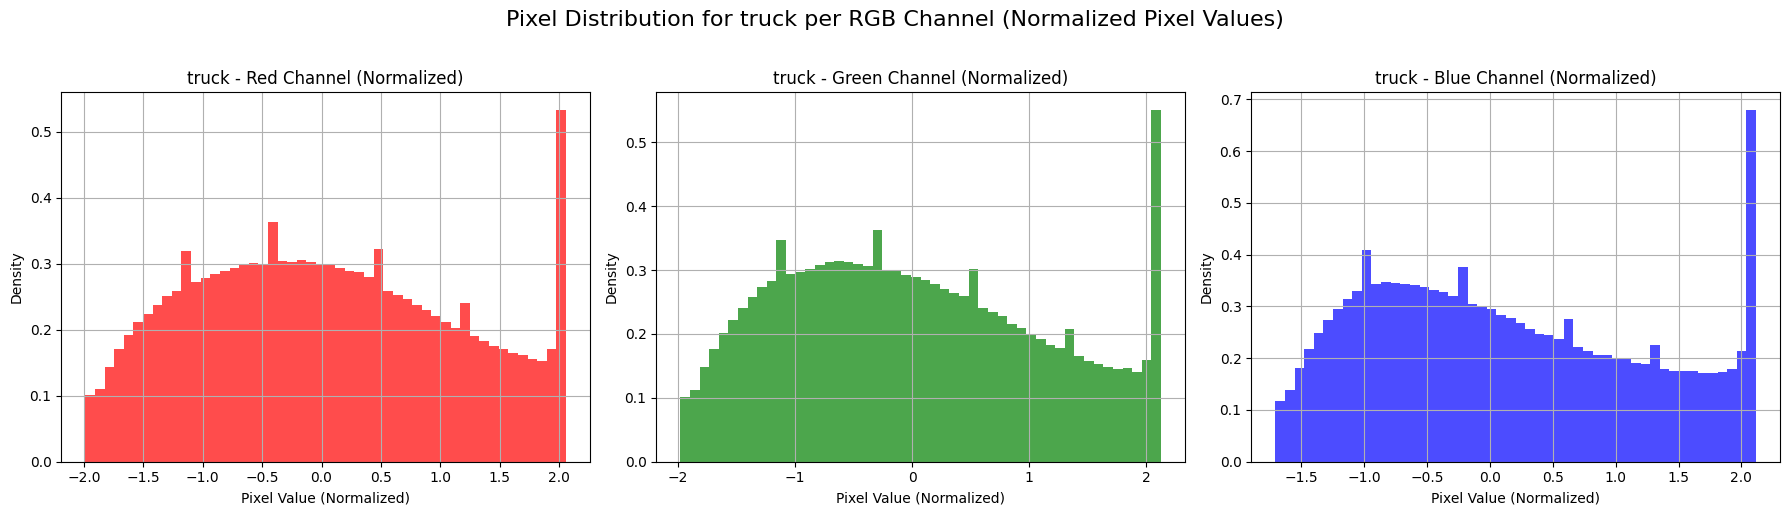

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch

# Normalization parameters from previous analysis
mean_per_channel = [0.49139967861920936, 0.48215840840079704, 0.446530914459704]
std_per_channel = [0.24703223245050313, 0.24348512800288716, 0.2615878417317208]

transform_normalized = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_per_channel, std_per_channel)
])

# Create new datasets with normalization applied
trainset_normalized = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_normalized)
testset_normalized = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_normalized)

# Concatenate normalized data for overall distribution analysis
# We need to manually iterate to apply transforms and then concatenate tensors
print("Collecting normalized data for distribution analysis...")
all_normalized_images_list = []
all_normalized_labels_list = []

# Collect data from trainset_normalized
for i in range(len(trainset_normalized)):
    image, label = trainset_normalized[i]
    all_normalized_images_list.append(image)
    all_normalized_labels_list.append(label)

# Collect data from testset_normalized
for i in range(len(testset_normalized)):
    image, label = testset_normalized[i]
    all_normalized_images_list.append(image)
    all_normalized_labels_list.append(label)

all_normalized_images_tensor = torch.stack(all_normalized_images_list) # (N, C, H, W)
all_normalized_labels_tensor = torch.tensor(all_normalized_labels_list) # (N)
print("Normalized data collection complete.")

# Convert to numpy for plotting
all_pixels_normalized_np = all_normalized_images_tensor.numpy() # (N, C, H, W)

# Overall pixel distribution (all channels combined)
plt.figure(figsize=(10, 5))
plt.hist(all_pixels_normalized_np.flatten(), bins=50, density=True, color='purple', alpha=0.7)
plt.title('Overall Pixel Distribution Across All Images (Normalized)')
plt.xlabel('Pixel Value (Normalized)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Overall pixel distribution for each RGB channel (Normalized)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['red', 'green', 'blue']
titles = ['Red Channel', 'Green Channel', 'Blue Channel']

for i in range(3):
    axes[i].hist(all_pixels_normalized_np[:, i, :, :].flatten(), bins=50, density=True, color=colors[i], alpha=0.7)
    axes[i].set_title(f'Overall Pixel Distribution - {titles[i]} (Normalized)')
    axes[i].set_xlabel('Pixel Value (Normalized)')
    axes[i].set_ylabel('Density')
    axes[i].grid(True)
plt.suptitle('Overall Pixel Distribution per RGB Channel (Normalized Pixel Values)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Pixel distribution by class (all channels combined)
fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, class_name in enumerate(classes):
    class_indices = (all_normalized_labels_tensor == i).nonzero(as_tuple=True)[0]
    class_images_normalized = all_normalized_images_tensor[class_indices]
    
    axes[i].hist(class_images_normalized.numpy().flatten(), bins=50, density=True, color='lightcoral', alpha=0.7)
    axes[i].set_title(f'Pixel Distribution for {class_name} (Normalized)')
    axes[i].grid(True)

plt.suptitle('Pixel Distribution by Class (Normalized Pixel Values)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Pixel distribution by class for each RGB channel (Normalized)
for i, class_name in enumerate(classes):
    class_indices = (all_normalized_labels_tensor == i).nonzero(as_tuple=True)[0]
    class_images_normalized = all_normalized_images_tensor[class_indices].numpy() # (N_class, C, H, W)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for c in range(3):
        axes[c].hist(class_images_normalized[:, c, :, :].flatten(), bins=50, density=True, color=colors[c], alpha=0.7)
        axes[c].set_title(f'{class_name} - {titles[c]} (Normalized)')
        axes[c].set_xlabel('Pixel Value (Normalized)')
        axes[c].set_ylabel('Density')
        axes[c].grid(True)
    plt.suptitle(f'Pixel Distribution for {class_name} per RGB Channel (Normalized Pixel Values)', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()


### Receptive Field Per Block
Looking at the data it looks like the receptive field per block can be 7 or at max 9 to cover most of the portion of the image. Here is preview of some portions from an image that depicts a ship. Each of the deck in the ship can be covered with a block on 9 pixels, some can be covered even with 7. To be able to achieve an RF of 5 with 3x3 and stride 1 we may need 4 convolutions per block.

#### Image (Ship Base)
![Alt text](img/ship1.png)

#### Image (Ship Deck)
![Alt text](img/ship2.png)

## Observations 📝🔍

Based on the analysis of the CIFAR-10 dataset, here are some key observations:

*   **Image Resolution & Sharpness**: The image resolution of the dataset is quite low, often appearing pixelated and blurry. From the Laplacian Variance analysis, images with a sharpness index above ~500 generally seem acceptable, so no global sharpening will be applied as part of preprocessing. 📸📉 (low resolution) -> 📈 (above 500 sharpness)
*   **Partial Objects**: Some images contain only a portion of the object, yet our model needs to accurately recognize them. This highlights the importance of effective padding strategies during model training to ensure all relevant contextual information is captured. 🖼️✂️
*   **Class Distribution**: Both the training and test datasets exhibit an even distribution of labels across all classes, eliminating the need for class balancing techniques. ✅⚖️
*   **Image Characteristics**: The dataset consists of 32x32 pixel images with 3 color channels (RGB). This signifies that we are dealing with color images, presenting a higher level of complexity compared to simpler grayscale datasets like MNIST. 🎨📏
*   **Pixel Distribution**: Unlike MNIST, where pixel values tend to be concentrated in a narrower range, CIFAR-10 exhibits a broader distribution of pixel values across the full 0-255 range. This implies greater variability in brightness and color intensity within the images. 📊🔆
*   **Dataset Size**: The training set comprises 50,000 images, and the test set contains 10,000 images. These sizes are comparable to the MNIST dataset. 🔢💾
* **Normalization Parameters**: 
```{'mean': [0.49139967861920936, 0.48215840840079704, 0.446530914459704], 'std': [0.24703223245050313, 0.24348512800288716, 0.2615878417317208]}```

## Training Setup

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
import albumentations as A
from torchvision.datasets import CIFAR10
from cifar10_album import CIFAR10Albumentations


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# CIFAR-10 class names
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Data loading with basic normalization only (no augmentation)
def load_cifar10_data(augment=''):
    
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    if augment == 'albumentations':
        print(f"Using albumentations for augmentation")
        train_dataset = CIFAR10Albumentations(
            root="./tdata/album", train=True, download=True
        )
        test_dataset = CIFAR10Albumentations(
            root="./tdata/album", train=False, download=True
        )
    else:
        # Create data loaders
        train_dataset = torchvision.datasets.CIFAR10(
            root="./tdata", train=True, download=True, transform=transform_train
        )
        test_dataset = torchvision.datasets.CIFAR10(
            root="./tdata", train=False, download=True, transform=transform_test
        )

    trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
    testloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
    
    return trainloader, testloader

# Receptive field calculation (for CNNs)
def calculate_receptive_field(model, input_size=(3, 32, 32)):
    from collections import deque

    class LayerInfo:
        def __init__(self, kernel_size, stride, padding):
            self.kernel = kernel_size
            self.stride = stride
            self.padding = padding

    layers = []
    
    def register_hook(module):
        if isinstance(module, (nn.Conv2d, nn.MaxPool2d)):
            k = module.kernel_size
            s = module.stride
            p = module.padding
            if isinstance(k, tuple):
                k = k[0]
            if isinstance(s, tuple):
                s = s[0]
            if isinstance(p, tuple):
                p = p[0]
            layers.append(LayerInfo(k, s, p))

    model.apply(register_hook)

    # Receptive field calculation
    rf = 1
    stride = 1
    for layer in reversed(layers):
        rf = ((rf - 1) * layer.stride) + layer.kernel
        stride *= layer.stride

    print(f"Approximate Receptive Field: {rf}x{rf}")
    return rf


# Training function
def train_epoch(model, trainloader, criterion, optimizer, device, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 99:
            print(f'Batch [{batch_idx+1}/{len(trainloader)}], '
                  f'Loss: {running_loss/100:.4f}, '
                  f'Acc: {100.*correct/total:.2f}%')
            running_loss = 0.0
    
    train_acc = 100. * correct / total
    return train_acc

# Validation function
def validate(model, testloader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_acc = 100. * correct / total
    avg_loss = test_loss / len(testloader)
    
    return test_acc, avg_loss

# Count model parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Plot training progress
def plot_training_progress(train_accuracies, val_accuracies, train_losses, val_losses):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(train_accuracies) + 1)
    
    # Accuracy plot
    ax1.plot(epochs, train_accuracies, 'b-o', label='Training Accuracy')
    ax1.plot(epochs, val_accuracies, 'r-o', label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    ax1.grid(True)
    
    # Loss plot
    ax2.plot(epochs, train_losses, 'b-o', label='Training Loss')
    ax2.plot(epochs, val_losses, 'r-o', label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Main training loop
def main(model, epochs=10, augment='', decay=False, schedule=None, lr=0.001):
    print("="*60)
    print("BASELINE CNN FOR CIFAR-10")
    print("="*60)
    
    # Load data
    print("Loading CIFAR-10 dataset...")
    trainloader, testloader = load_cifar10_data(augment)
    
    print(f"Training samples: {len(trainloader.dataset)}")
    print(f"Test samples: {len(testloader.dataset)}")
    
    
    # Count parameters
    total_params, trainable_params = count_parameters(model)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Print model architecture
    print("\nModel Architecture:")
    print(model)
    
    # Compute and print receptive field
    _ = calculate_receptive_field(model)

    # Loss function and optimizer (simple Adam, no scheduler)
    criterion = nn.CrossEntropyLoss()
    print(f"Using learning rate {lr}")
    if decay:
        optimizer = torch.optim.Adam(
                    model.parameters(),
                    lr=lr,
                    weight_decay=0.0001)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)
    
    if schedule == 'step':
        print(f"Using step scheduler")
        scheduler = optim.lr_scheduler.StepLR(
                            optimizer,
                            step_size=7,
                            gamma=0.5
                        )
    elif schedule == 'cosine':
        print(f"Using cosine scheduler")
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
                            optimizer,
                            T_max=epochs,
                            eta_min=0.00001
                        )
    
    print(f"\nOptimizer: Adam (lr={lr})")
    print(f"Loss function: CrossEntropyLoss")
    print(f"Training epochs: {epochs}")
    
    # Training history
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []
    
    print("\n" + "="*60)
    print("STARTING TRAINING")
    print("="*60)
    
    # Training loop for 10 epochs
    for epoch in range(epochs):
        start_time = time.time()
        
        print(f"\nEpoch [{epoch+1}/10]")
        print("-" * 40)
        
        # Train for one epoch
        train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
        
        # Validate
        val_acc, val_loss = validate(model, testloader, criterion, device)
        
        # Calculate approximate training loss for plotting
        model.eval()
        train_loss = 0.0
        with torch.no_grad():
            for inputs, targets in trainloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                train_loss += criterion(outputs, targets).item()
        train_loss /= len(trainloader)
        
        # Store metrics
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Print epoch results
        epoch_time = time.time() - start_time
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Train Accuracy: {train_acc:.2f}%")
        print(f"Validation Accuracy: {val_acc:.2f}%")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Time: {epoch_time:.1f}s")

        # scheduler step
        if scheduler:
            print(f"Using scheduler")
            scheduler.step()
    
    # Final results
    print("\n" + "="*60)
    print("TRAINING COMPLETED")
    print("="*60)
    
    best_val_acc = max(val_accuracies)
    best_epoch = val_accuracies.index(best_val_acc) + 1
    final_val_acc = val_accuracies[-1]
    
    print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")
    print(f"Total Parameters: {total_params:,}")
    
    # Plot training progress
    print("\nGenerating training plots...")
    plot_training_progress(train_accuracies, val_accuracies, train_losses, val_losses)
    
    # Test on individual classes
    print("\nPer-class accuracy:")
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    model.eval()
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == targets).squeeze()
            for i in range(targets.size(0)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    for i in range(10):
        if class_total[i] > 0:
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'{cifar10_classes[i]}: {accuracy:.1f}%')
    
    print(f"\nBaseline model performance summary:")
    print(f"• Architecture: 4-block CNN (ResNet-inspired)")
    print(f"• No data augmentation")
    print(f"• No max pooling (used stride and global avg pooling)")
    print(f"• Simple Adam optimizer (no scheduler)")
    print(f"• Final accuracy: {final_val_acc:.2f}%")
    print(f"• Parameters: {total_params:,}")
    
    return model, train_accuracies, val_accuracies


Using device: cpu


## Visualization

In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.transforms as transforms

# Assuming 'trained_model', 'device', 'classes', 'testset' (or testset_normalized)
# are available from previous cells.

# Re-define normalize transform for displaying images if needed (to un-normalize)
# For visualization, it's often better to display the raw image or a simply transformed one.
# However, to show what the model *actually* processed, we use the normalized images.

# Let's use the testset_normalized from Cell 23 (if available, otherwise re-create)
# If testset_normalized is not directly available, we need to apply the transform manually

# Normalization parameters
mean_per_channel = [0.49139967861920936, 0.48215840840079704, 0.446530914459704]
std_per_channel = [0.24703223245050313, 0.24348512800288716, 0.2615878417317208]

transform_display = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_per_channel, std_per_channel)
])

# Create a dataset for sampling with the correct transformations for the model
test_dataset_for_viz = torchvision.datasets.CIFAR10(
    root="./tdata", train=False, download=True, transform=transform_display
)


def visualize_layer_outputs(model, sample_images, classes, device, num_channels_to_show=4):
    model.eval()
    
    for img_idx, (image_tensor, true_label) in enumerate(sample_images):
        image_tensor = image_tensor.to(device).unsqueeze(0)  # Add batch dimension

        print(f"\n--- Visualizing Image {img_idx+1}: True Label: {classes[true_label]} ---")

        # Initial input image (un-normalize for display if desired, but we show what went into model)
        plt.figure(figsize=(2,2))
        # To display normalized image, we need to un-normalize first if we want to see the original colors.
        # However, for showing actual input to model, we plot the normalized tensor directly, clamping values.
        input_display = image_tensor.squeeze(0).cpu().permute(1, 2, 0)
        input_display = torch.clamp(input_display, 0, 1) # Clamp for display
        plt.imshow(input_display)
        plt.title(f"Input: {classes[true_label]}")
        plt.axis('off')
        plt.show()

        x = image_tensor
        layer_outputs = []
        x_flat = None # Initialize to None, will be set after GAP

        # Iterate through model layers
        for name, layer in model.named_children():
            if isinstance(layer, nn.Sequential):
                # Handle Sequential blocks (like BasicBlock)
                for sub_name, sub_layer in layer.named_children():
                    x = sub_layer(x)
                    # Only save outputs after activation for convolutional layers
                    if isinstance(sub_layer, (nn.ReLU, nn.BatchNorm2d)) and isinstance(x, torch.Tensor) and x.dim() == 4:
                        layer_outputs.append((f"Block {name.replace('block','')}_{sub_name}", x))
            elif isinstance(layer, nn.AdaptiveAvgPool2d):
                x = layer(x)
                x_flat = x.view(x.size(0), -1) # Flatten after GAP
                layer_outputs.append((name, x_flat)) # Save flattened output
                x = x_flat # Update x to be the flattened output for subsequent layers
            elif isinstance(layer, nn.Linear):
                x = layer(x) # x should already be flattened from AdaptiveAvgPool2d or previous layer
                layer_outputs.append((name, x))
            else: # For initial conv1, bn1, etc.
                x = layer(x)
                if isinstance(x, torch.Tensor) and x.dim() == 4: # Only append if it's a feature map
                    layer_outputs.append((name, x))

        # Display feature maps for selected layers
        for layer_name, output_tensor in layer_outputs:
            # Only visualize convolutional/feature maps. Skip linear layer outputs.
            if output_tensor.dim() == 4 and output_tensor.shape[2] > 1:
                num_output_channels = output_tensor.shape[1]
                actual_channels_to_show = min(num_channels_to_show, num_output_channels)
                
                # Create a figure for the layer's feature maps
                fig, axes = plt.subplots(1, actual_channels_to_show, figsize=(2 * actual_channels_to_show, 2))
                fig.suptitle(f'Layer: {layer_name} (Output Shape: {list(output_tensor.shape)})', fontsize=10)
                
                for i in range(actual_channels_to_show):
                    ax = axes[i] if actual_channels_to_show > 1 else axes
                    # Detach from GPU, convert to numpy, squeeze channel dim if 1
                    feature_map = output_tensor[0, i].detach().cpu().numpy()
                    ax.imshow(feature_map, cmap='viridis')
                    ax.set_title(f'Channel {i}', fontsize=8)
                    ax.axis('off')
                plt.tight_layout(rect=[0, 0.03, 1, 0.9]) # Adjust layout to prevent suptitle overlap
                plt.show()
            elif output_tensor.dim() == 2: # Linear layer output
                # For classification output, just print the top prediction
                if layer_name == 'fc':
                    probabilities = torch.nn.functional.softmax(output_tensor, dim=1)
                    top_p, top_class = probabilities.topk(1, dim=1)
                    print(f"Final Prediction: {classes[top_class.item()]} (Confidence: {top_p.item():.2f})")
            

# Select 5 random images from the test set
num_images_to_viz = 2
random_indices_for_viz = random.sample(range(len(test_dataset_for_viz)), num_images_to_viz)
sample_images_for_viz = [test_dataset_for_viz[i] for i in random_indices_for_viz]


## Basic Model

### Define Model Architecture 🏗️

In this section, we will define a basic Convolutional Neural Network (CNN) architecture. This initial model will serve as our baseline for performance evaluation on the CIFAR-10 dataset. The architecture will include:

* Convolutional layers with appropriate filters and activation functions.
* Basic Transformation (Normalization)
* No Augmentation
* No Max Pooling
* Simple Adam Optimizer with nor scheduler
* A training loop for 10 epochs 
* Evalaute accuracy at the end of each epoch using validation data
* Simple 4 convolution blocks inspired by Resnet

We will ensure the model adheres to any specified constraints (e.g., total number of parameters).

If required we will add this code later
```    
    # Initialize weights
         self._initialize_weights()
    
     def _initialize_weights(self):
         for m in self.modules():
             if isinstance(m, nn.Conv2d):
                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
             elif isinstance(m, nn.BatchNorm2d):
                 nn.init.constant_(m.weight, 1)
                 nn.init.constant_(m.bias, 0)
             elif isinstance(m, nn.Linear):
                 nn.init.normal_(m.weight, 0, 0.01)
                 nn.init.constant_(m.bias, 0)
```

In [49]:
# Basic CNN Block with receptive field = 11
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        # To achieve receptive field of 11, we use multiple conv layers
        # Receptive field calculation: RF = 1 + (k1-1) + (k2-1) + (k3-1) + (k4-1)
        # Using 4 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 + 2 = 9
        # Using 3 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 = 7  
        # Using 5 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 + 2 + 2 = 11 ✓
        
        # First conv layer (with potential stride for downsampling)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second conv layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Third conv layer
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        # Fourth conv layer
        self.conv4 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(out_channels)
        
        # Fifth conv layer to achieve RF=11
        self.conv5 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        # Pass through all 5 conv layers for RF=11
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.relu(self.bn3(self.conv3(out)))
        out = F.relu(self.bn4(self.conv4(out)))
        out = F.relu(self.bn5(self.conv5(out)))
        
        return out

# Baseline CNN Architecture
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(BaselineCNN, self).__init__()
        
        # Initial conv layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # 4 Basic blocks (inspired by ResNet)
        self.block1 = BasicBlock(64, 64, stride=1)    # 32x32 -> 32x32
        self.block2 = BasicBlock(64, 128, stride=2)   # 32x32 -> 16x16
        self.block3 = BasicBlock(128, 256, stride=2)  # 16x16 -> 8x8
        self.block4 = BasicBlock(256, 512, stride=2)  # 8x8 -> 4x4
        
        # Global Average Pooling (instead of max pooling)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Final classifier
        self.fc = nn.Linear(512, num_classes)
        
    
    def forward(self, x):
        # Initial conv
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Pass through 4 basic blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        # Global average pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        
        # Final classification
        x = self.fc(x)
        
        return x



Initializing baseline CNN...
BASELINE CNN FOR CIFAR-10
Loading CIFAR-10 dataset...


100.0%


Training samples: 50000
Test samples: 10000
Total parameters: 14,135,498
Trainable parameters: 14,135,498

Model Architecture:
BaselineCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn4): BatchNorm2d

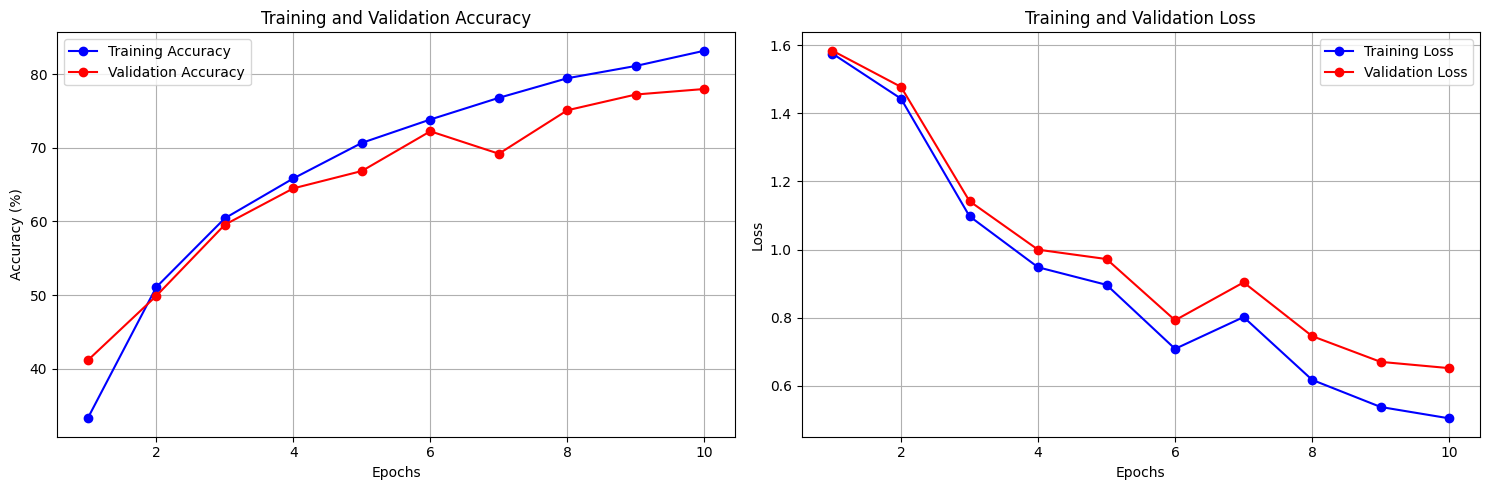


Per-class accuracy:
airplane: 72.8%
automobile: 94.9%
bird: 65.6%
cat: 62.5%
deer: 82.0%
dog: 83.4%
frog: 57.0%
horse: 84.6%
ship: 89.7%
truck: 87.6%

Baseline model performance summary:
• Architecture: 4-block CNN (ResNet-inspired)
• No data augmentation
• No max pooling (used stride and global avg pooling)
• Simple Adam optimizer (no scheduler)
• Final accuracy: 78.01%
• Parameters: 14,135,498


In [50]:
# Initialize model
print("\nInitializing baseline CNN...")
model = BaselineCNN(num_classes=10).to(device)

trained_model, train_accs, val_accs = main(model=model)

### Observations
From the results some of the things are very obvious 
- There is overfitting happening in the model as train accuracy is higher than the validation. This mean we need to make the model learn on ADDITIONAL DATA or make training harder with DROPOUT or both. 
- Even with ~14M parameter in the basic model, we are not able to reach the accuracy of 80% in the validation data. This means we have our work cut out 1) to reach the accuracy of 85% first and then 2) trim down the model to under 200k
- Based on the analysis of the image it looks like the Receptive Field of 9 at max or even 7 for most part should be good enough to identify the constintuents of the image. As such we can explore a smaller block of 3 or 4 convolutions with stride 1 or increase the stride to further adjust the convolutions required.

Have Fun!

## Basic Model (Receptive Field 7/Block)

In [51]:
# Basic CNN Block with receptive field = 11
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        # To achieve receptive field of 11, we use multiple conv layers
        # Receptive field calculation: RF = 1 + (k1-1) + (k2-1) + (k3-1) + (k4-1)
        # Using 4 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 + 2 = 9
        # Using 3 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 = 7  
        # Using 5 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 + 2 + 2 = 11 ✓
        
        # First conv layer (with potential stride for downsampling)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second conv layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Third conv layer
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
    
    def forward(self, x):
        # Pass through all 5 conv layers for RF=11
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.relu(self.bn3(self.conv3(out)))
        
        return out

# Baseline CNN Architecture
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(BaselineCNN, self).__init__()
        
        # Initial conv layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # 4 Basic blocks (inspired by ResNet)
        self.block1 = BasicBlock(64, 64, stride=1)    # 32x32 -> 32x32
        self.block2 = BasicBlock(64, 128, stride=2)   # 32x32 -> 16x16
        self.block3 = BasicBlock(128, 256, stride=2)  # 16x16 -> 8x8
        self.block4 = BasicBlock(256, 512, stride=2)  # 8x8 -> 4x4
        
        # Global Average Pooling (instead of max pooling)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Final classifier
        self.fc = nn.Linear(512, num_classes)
        
    
    def forward(self, x):
        # Initial conv
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Pass through 4 basic blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        # Global average pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        
        # Final classification
        x = self.fc(x)
        
        return x



Initializing baseline CNN...
BASELINE CNN FOR CIFAR-10
Loading CIFAR-10 dataset...
Training samples: 50000
Test samples: 10000
Total parameters: 7,864,778
Trainable parameters: 7,864,778

Model Architecture:
BaselineCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): BasicBlock(
   

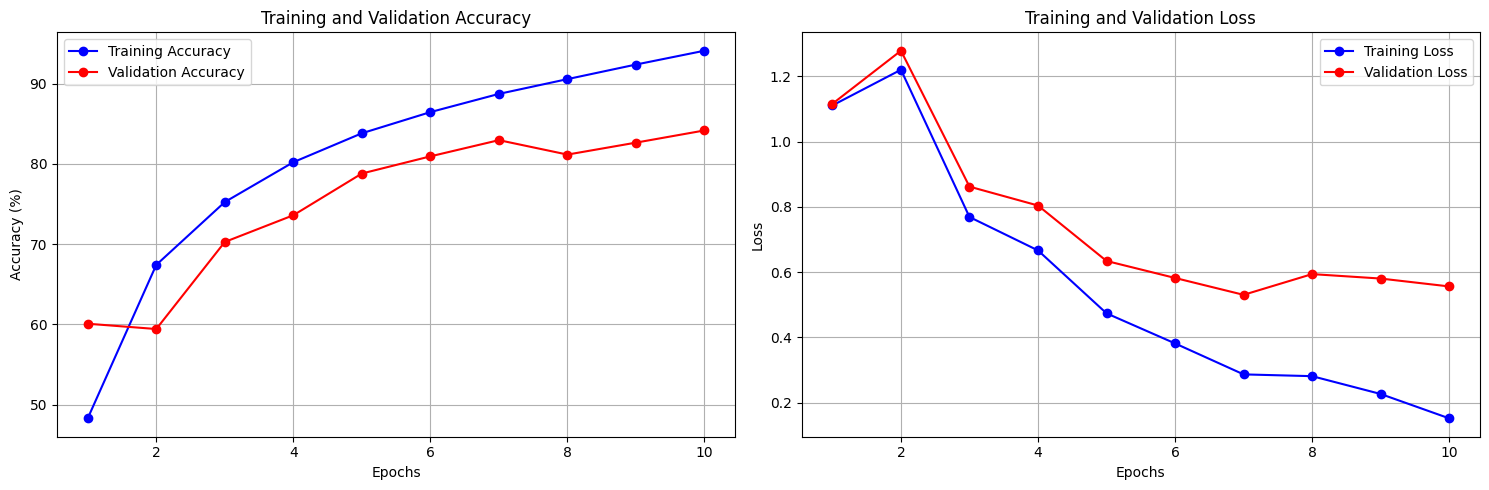


Per-class accuracy:
airplane: 79.7%
automobile: 92.7%
bird: 80.0%
cat: 65.8%
deer: 84.3%
dog: 72.8%
frog: 91.3%
horse: 90.9%
ship: 94.0%
truck: 90.2%

Baseline model performance summary:
• Architecture: 4-block CNN (ResNet-inspired)
• No data augmentation
• No max pooling (used stride and global avg pooling)
• Simple Adam optimizer (no scheduler)
• Final accuracy: 84.17%
• Parameters: 7,864,778


In [52]:
# Initialize model
print("\nInitializing baseline CNN...")
model = BaselineCNN(num_classes=10).to(device)

trained_model, train_accs, val_accs = main(model=model)

In [53]:
import os
import torch

# Define the path for saving the model
model_dir = "./model"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "baseline_cifar_cnn.pth")

# Save the trained model's state dictionary
torch.save(trained_model.state_dict(), model_path)
print(f"Trained model saved to {model_path}")


Trained model saved to ./model/baseline_cifar_cnn.pth



--- Visualizing Image 1: True Label: truck ---


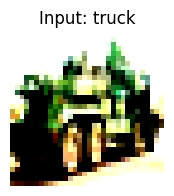

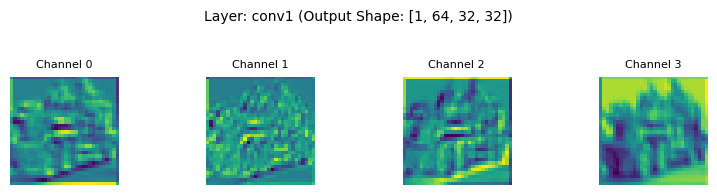

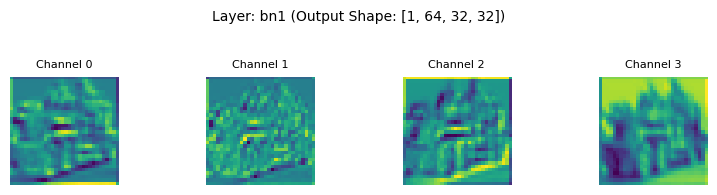

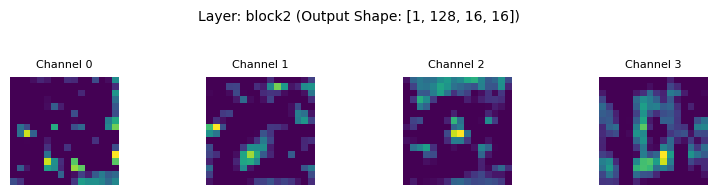

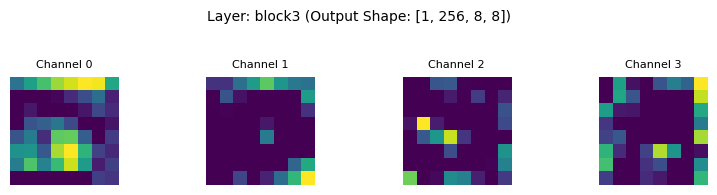

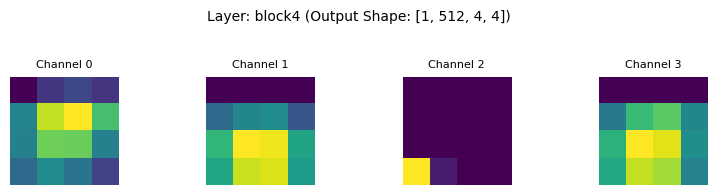

Final Prediction: car (Confidence: 0.53)

--- Visualizing Image 2: True Label: bird ---


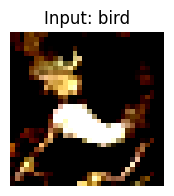

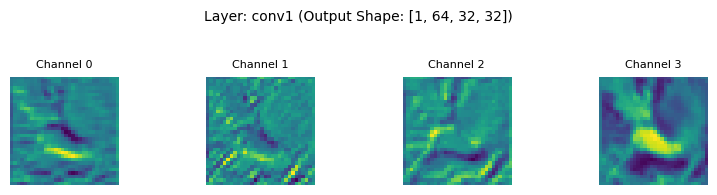

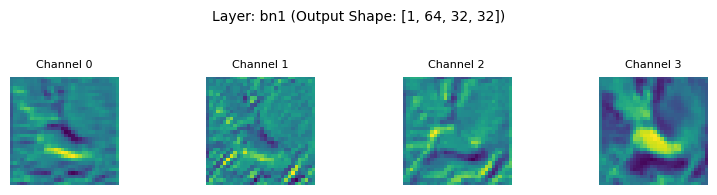

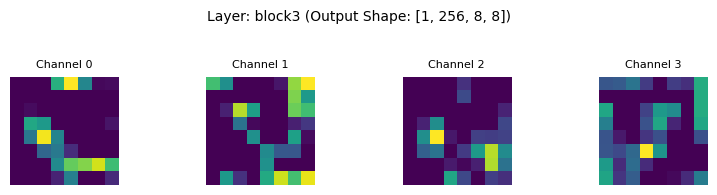

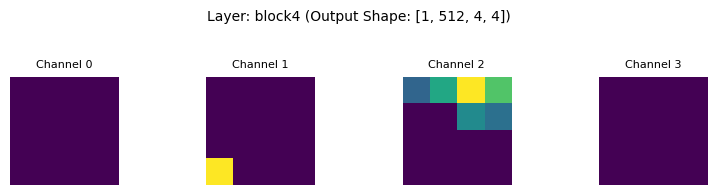

Final Prediction: horse (Confidence: 0.94)


In [ ]:
# Visualize the outputs
visualize_layer_outputs(trained_model, sample_images_for_viz, classes, device)

### Observations
From the results some of the things are very obvious 
- Less is more. The model gave better accuracy with half the parameters. Clearly more processing was causing more confusion and model trying to memorize the content. The question remains, how do I get to the right parameter size which is  enough to get the accuracy? Or Should I try other options 
- This time I won't play with the Receptive Field Per Block (7). But I can play with number of channels per block. The question is should I change it in every block or 1 block? To keep the model architecture consistent, I am inclinded to do it for all blocks
- There is still a lot of overfitting here which means we can regularize the model. Which regularization should I use? Dropout, Lasso, Ridge? I will try with Dropout first followed by weight decy (L2)
- The least accurate class is cat followed by dog at 65.8% and 72.8%. Should I be doing anything specific to these classes like augumentation or should I do it overall.
- Even with 7M+ parameters not able to hit the validation accuracy of 85%. So more work cut out.

Getting Interesting!

## Lighter Model (Less Parameters)

In [61]:
# Basic CNN Block with receptive field = 11
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        # To achieve receptive field of 11, we use multiple conv layers
        # Receptive field calculation: RF = 1 + (k1-1) + (k2-1) + (k3-1) + (k4-1)
        # Using 4 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 + 2 = 9
        # Using 3 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 = 7  
        # Using 5 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 + 2 + 2 = 11 ✓
        
        # First conv layer (with potential stride for downsampling)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second conv layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Third conv layer
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
    
    def forward(self, x):
        # Pass through all 5 conv layers for RF=11
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.relu(self.bn3(self.conv3(out)))
        
        return out

# Baseline CNN Architecture
class LighterCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LighterCNN, self).__init__()
        
        # Initial conv layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        
        # 4 Basic blocks (inspired by ResNet)
        self.block1 = BasicBlock(32, 32, stride=1)    # 32x32 -> 32x32
        self.block2 = BasicBlock(32, 64, stride=2)   # 32x32 -> 16x16
        self.block3 = BasicBlock(64, 128, stride=2)  # 16x16 -> 8x8
        self.block4 = BasicBlock(128, 256, stride=2)  # 8x8 -> 4x4
        
        # Global Average Pooling (instead of max pooling)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Final classifier
        self.fc = nn.Linear(256, num_classes)
        
    
    def forward(self, x):
        # Initial conv
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Pass through 4 basic blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        # Global average pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        
        # Final classification
        x = self.fc(x)
        
        return x



Initializing lighter CNN...
BASELINE CNN FOR CIFAR-10
Loading CIFAR-10 dataset...
Training samples: 50000
Test samples: 10000
Total parameters: 1,969,386
Trainable parameters: 1,969,386

Model Architecture:
LighterCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): BasicBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): BasicBlock(
    (

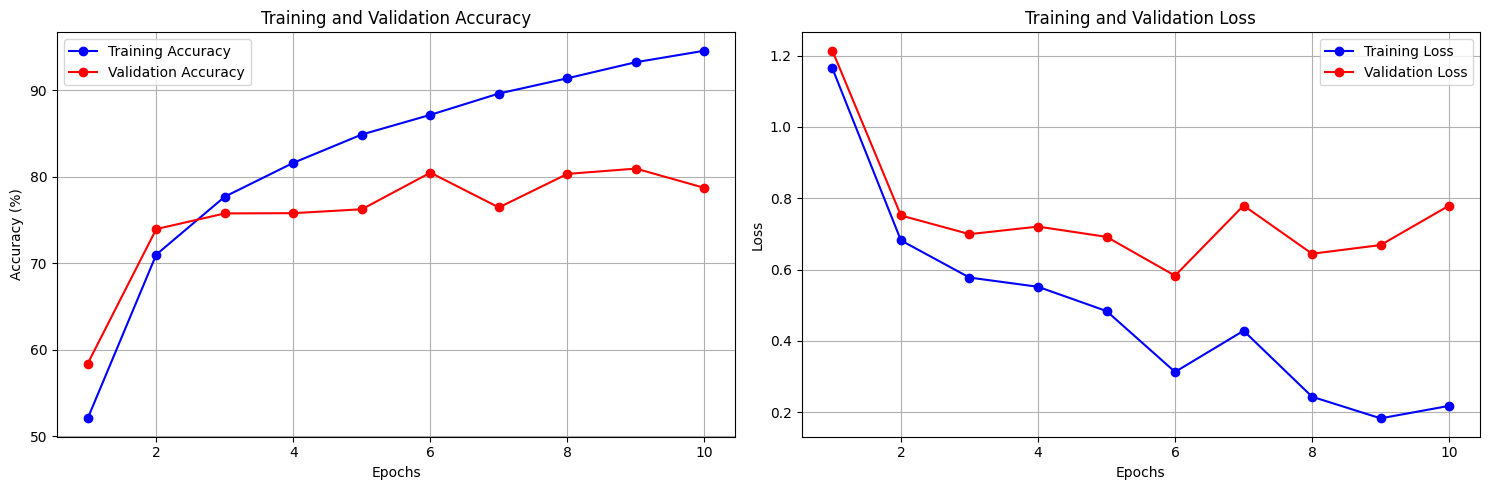


Per-class accuracy:
airplane: 86.5%
automobile: 93.4%
bird: 66.4%
cat: 69.4%
deer: 58.5%
dog: 79.7%
frog: 75.0%
horse: 91.0%
ship: 79.8%
truck: 87.3%

Baseline model performance summary:
• Architecture: 4-block CNN (ResNet-inspired)
• No data augmentation
• No max pooling (used stride and global avg pooling)
• Simple Adam optimizer (no scheduler)
• Final accuracy: 78.70%
• Parameters: 1,969,386


In [62]:
# Initialize model
print("\nInitializing lighter CNN...")
model = LighterCNN(num_classes=10).to(device)

trained_model, train_accs, val_accs = main(model=model)

In [64]:
import os
import torch

# Define the path for saving the model
model_dir = "./model"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "lighter_cifar_cnn.pth")

# Save the trained model's state dictionary
torch.save(trained_model.state_dict(), model_path)
print(f"Trained model saved to {model_path}")


Trained model saved to ./model/lighter_cifar_cnn.pth



--- Visualizing Image 1: True Label: truck ---


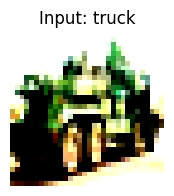

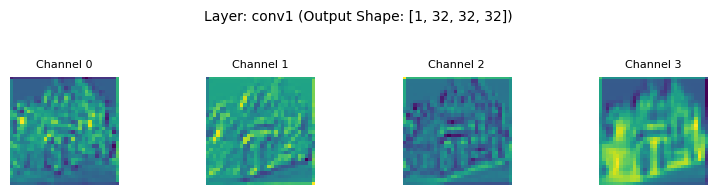

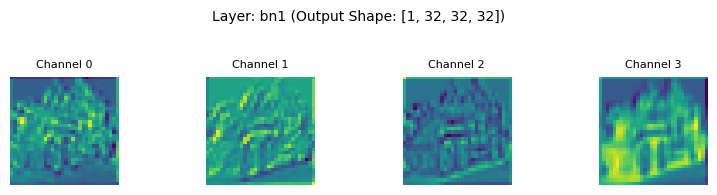

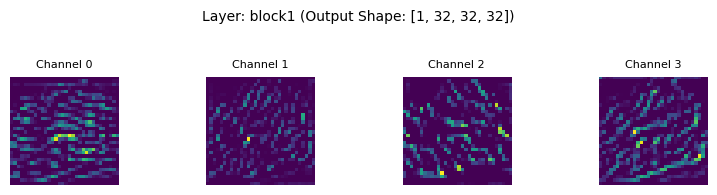

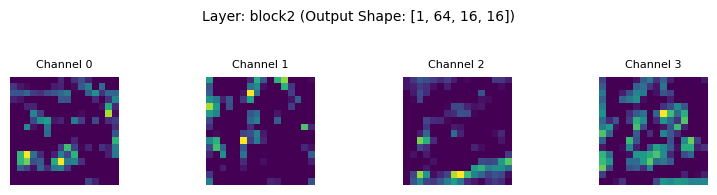

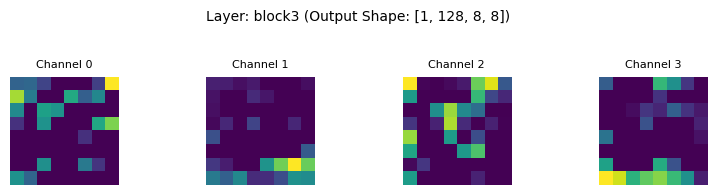

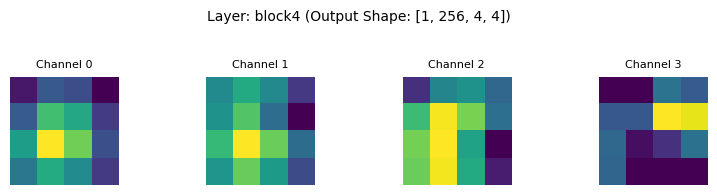

Final Prediction: car (Confidence: 0.58)

--- Visualizing Image 2: True Label: bird ---


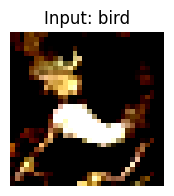

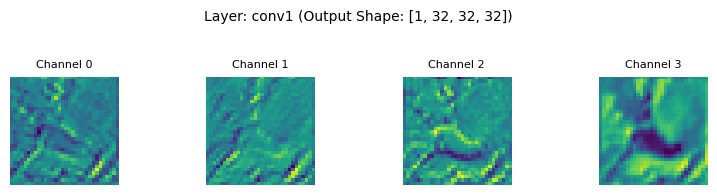

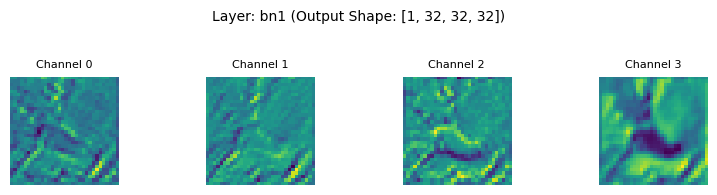

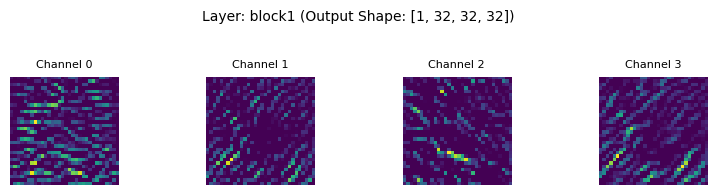

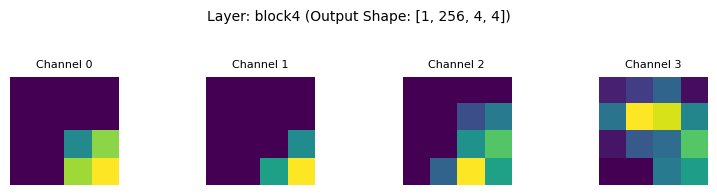

Final Prediction: horse (Confidence: 0.85)


In [65]:
# Visualize the outputs
visualize_layer_outputs(trained_model, sample_images_for_viz, classes, device)

### Observations
Some of the key observations 
- Lot of overfitting happening here as well, as such it is time for us to bring in regularization before trying to optimize the model further


## Regularized Model (Dropout)

In [10]:
# Basic CNN Block with receptive field = 11
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        # To achieve receptive field of 11, we use multiple conv layers
        # Receptive field calculation: RF = 1 + (k1-1) + (k2-1) + (k3-1) + (k4-1)
        # Using 4 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 + 2 = 9
        # Using 3 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 = 7  
        # Using 5 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 + 2 + 2 = 11 ✓
        
        # First conv layer (with potential stride for downsampling)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.do1 = nn.Dropout(0.05)
        
        # Second conv layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.do2 = nn.Dropout(0.05)
        
        # Third conv layer
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
    
    def forward(self, x):
        # Pass through all 5 conv layers for RF=11
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.do1(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.do2(out)
        out = F.relu(self.bn3(self.conv3(out)))
        
        return out

# Baseline CNN Architecture
class RegularizedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(RegularizedCNN, self).__init__()
        
        # Initial conv layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        
        # 4 Basic blocks (inspired by ResNet)
        self.block1 = BasicBlock(32, 32, stride=1)    # 32x32 -> 32x32
        self.block2 = BasicBlock(32, 64, stride=2)   # 32x32 -> 16x16
        self.block3 = BasicBlock(64, 128, stride=2)  # 16x16 -> 8x8
        self.block4 = BasicBlock(128, 256, stride=2)  # 8x8 -> 4x4
        
        # Global Average Pooling (instead of max pooling)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Final classifier
        self.fc = nn.Linear(256, num_classes)
        
    
    def forward(self, x):
        # Initial conv
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Pass through 4 basic blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        # Global average pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        
        # Final classification
        x = self.fc(x)
        
        return x


In [67]:
# Initialize model
print("\nInitializing regularized CNN...")
model = RegularizedCNN(num_classes=10).to(device)

trained_model, train_accs, val_accs = main(model=model)


Initializing regularized CNN...
BASELINE CNN FOR CIFAR-10
Loading CIFAR-10 dataset...
Training samples: 50000
Test samples: 10000
Total parameters: 1,969,386
Trainable parameters: 1,969,386

Model Architecture:
RegularizedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): BasicBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do1): Dropout(p=0.05, inplace=False)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do2): Dropout(p=0.05, inplace=False)
    (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(32, eps=1

: 

### Observations
Some of the key observations 
- After drop out there seems to be some convergence but still quite a bit of overfitting. Also accuracy for some of the classes is very low < 70%. I will start with augmentation and then to weight decay.

## Regularized Model With Augmentation

In [25]:
# Initialize model
print("\nInitializing regularized augmented CNN...")
model = RegularizedCNN(num_classes=10).to(device)

trained_model, train_accs, val_accs = main(model=model, augment='albumentations')


Initializing regularized augmented CNN...
BASELINE CNN FOR CIFAR-10
Loading CIFAR-10 dataset...
Using albumentations for augmentation
Training samples: 50000
Test samples: 10000
Total parameters: 1,969,386
Trainable parameters: 1,969,386

Model Architecture:
RegularizedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): BasicBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do1): Dropout(p=0.05, inplace=False)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do2): Dropout(p=0.05, inplace=False)
    (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 


Per-class accuracy:
airplane: 84.8%
automobile: 98.6%
bird: 81.3%
cat: 63.5%
deer: 70.3%
dog: 62.2%
frog: 84.9%
horse: 73.5%
ship: 91.6%
truck: 78.8%

Baseline model performance summary:
• Architecture: 4-block CNN (ResNet-inspired)
• No data augmentation
• No max pooling (used stride and global avg pooling)
• Simple Adam optimizer (no scheduler)
• Final accuracy: 78.98%
• Parameters: 1,969,386


In [26]:
import os
import torch

# Define the path for saving the model
model_dir = "./model"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "regularized_cifar_cnn.pth")

# Save the trained model's state dictionary
torch.save(trained_model.state_dict(), model_path)
print(f"Trained model saved to {model_path}")


Trained model saved to ./model/regularized_cifar_cnn.pth



--- Visualizing Image 1: True Label: truck ---


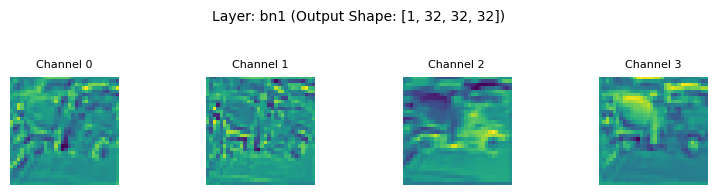

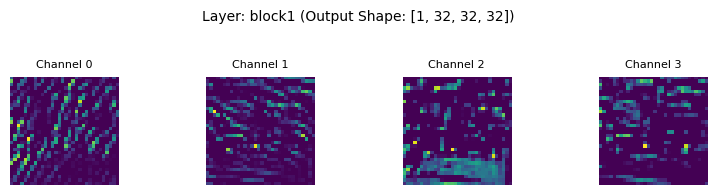

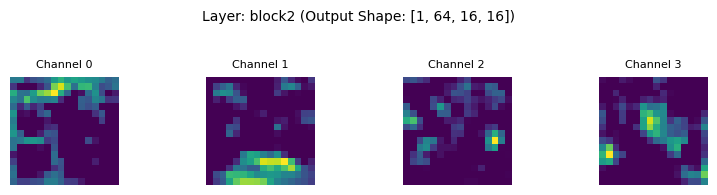

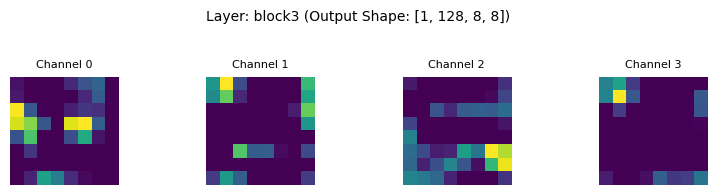

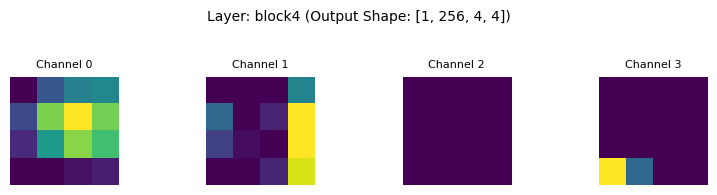

Final Prediction: truck (Confidence: 0.95)

--- Visualizing Image 2: True Label: bird ---


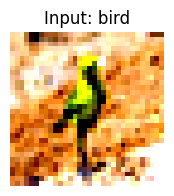

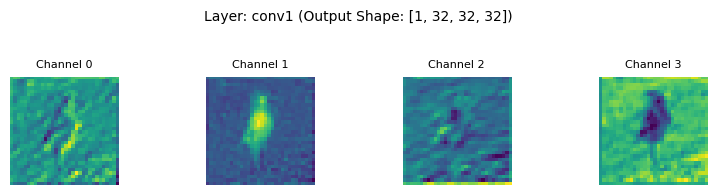

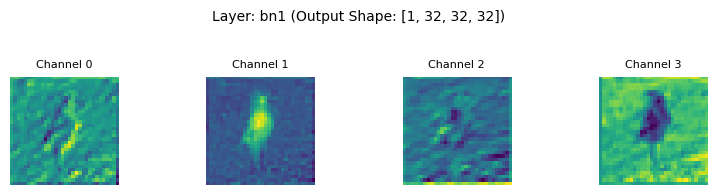

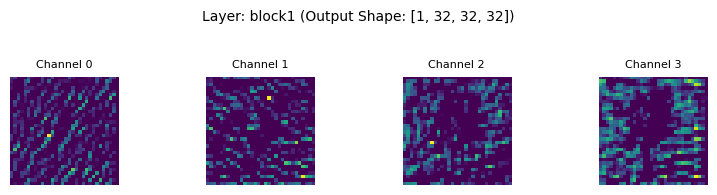

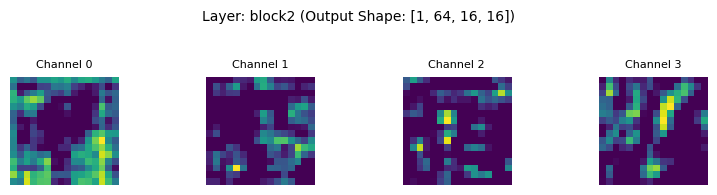

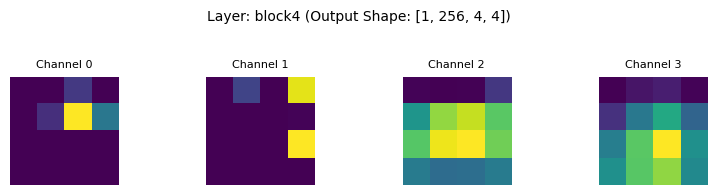

Final Prediction: bird (Confidence: 0.72)


In [31]:
# Visualize the outputs
visualize_layer_outputs(trained_model, sample_images_for_viz, classes, device)

### Observations
Some key observations 
- Augmentation indeed helped reduce the train and test accuracy gap. However the accuracy numbers are still under 85%.
- The usual classes are still underperforming and I will do a subsequent analysis of what my model is predicting for some of these classes. Is there any class separability issue.
- At this stage I am tempted to try another lighter version of the model 

## LighterStill Model

In [10]:
# Basic CNN Block with receptive field = 11
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        # To achieve receptive field of 11, we use multiple conv layers
        # Receptive field calculation: RF = 1 + (k1-1) + (k2-1) + (k3-1) + (k4-1)
        # Using 4 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 + 2 = 9
        # Using 3 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 = 7  
        # Using 5 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 + 2 + 2 = 11 ✓
        
        # First conv layer (with potential stride for downsampling)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.do1 = nn.Dropout(0.05)
        
        # Second conv layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.do2 = nn.Dropout(0.05)
        
        # Third conv layer
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
    
    def forward(self, x):
        # Pass through all 5 conv layers for RF=11
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.do1(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.do2(out)
        out = F.relu(self.bn3(self.conv3(out)))
        
        return out

# Baseline CNN Architecture
class LighterStillCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LighterStillCNN, self).__init__()
        
        # Initial conv layer
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(8)
        
        # 4 Basic blocks (inspired by ResNet)
        self.block1 = BasicBlock(8, 8, stride=1)    # 32x32 -> 32x32
        self.block2 = BasicBlock(8, 16, stride=2)   # 32x32 -> 16x16
        self.block3 = BasicBlock(16, 32, stride=2)  # 16x16 -> 8x8
        self.block4 = BasicBlock(32, 64, stride=2)  # 8x8 -> 4x4
        
        # Global Average Pooling (instead of max pooling)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Final classifier
        self.fc = nn.Linear(64, num_classes)
        
    
    def forward(self, x):
        # Initial conv
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Pass through 4 basic blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        # Global average pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        
        # Final classification
        x = self.fc(x)
        
        return x


In [9]:
# Initialize model
print("\nInitializing lighterstill  CNN...")
model = LighterStillCNN(num_classes=10).to(device)

trained_model, train_accs, val_accs = main(model=model, augment='albumentations')


Initializing lighterstill  CNN...
BASELINE CNN FOR CIFAR-10
Loading CIFAR-10 dataset...
Using albumentations for augmentation
Training samples: 50000
Test samples: 10000
Total parameters: 124,290
Trainable parameters: 124,290

Model Architecture:
LighterStillCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): BasicBlock(
    (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do1): Dropout(p=0.05, inplace=False)
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do2): Dropout(p=0.05, inplace=False)
    (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (


Per-class accuracy:
airplane: 69.4%
automobile: 88.7%
bird: 63.0%
cat: 62.9%
deer: 67.9%
dog: 67.5%
frog: 76.6%
horse: 77.5%
ship: 85.3%
truck: 85.0%

Baseline model performance summary:
• Architecture: 4-block CNN (ResNet-inspired)
• No data augmentation
• No max pooling (used stride and global avg pooling)
• Simple Adam optimizer (no scheduler)
• Final accuracy: 74.69%
• Parameters: 124,290


In [10]:
import os
import torch

# Define the path for saving the model
model_dir = "./model"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "lighterstill_cifar_cnn.pth")

# Save the trained model's state dictionary
torch.save(trained_model.state_dict(), model_path)
print(f"Trained model saved to {model_path}")


Trained model saved to ./model/lighterstill_cifar_cnn.pth


### Observations
Key observations after  this run 
- The model is doing decent even at 125K parameters. Given the current challenge of under 200K, we have scope to go higher in accuracy by sheer increase in parameter. BNit before that let's see how far we can extend the accuracy with current paramaters itself.
- Now we will use another form of regularization - the weight decay. 
- We will also try to play a bit with the learning rate. 
- Here the model will remain the same but the training code would change to take into account the weight decay.
- The accuracy of the airplane class went down significantly, but the accuracy of bird, dog deer has been generally low. We need to explore this aspect as well but after the learning rate and weight decay

## Weight Decay Model


Initializing lighterstill  CNN with weight decay...
BASELINE CNN FOR CIFAR-10
Loading CIFAR-10 dataset...
Using albumentations for augmentation
Training samples: 50000
Test samples: 10000
Total parameters: 124,290
Trainable parameters: 124,290

Model Architecture:
LighterStillCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): BasicBlock(
    (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do1): Dropout(p=0.05, inplace=False)
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do2): Dropout(p=0.05, inplace=False)
    (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),

/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


Batch [100/391], Loss: 1.9705, Acc: 26.45%
Batch [200/391], Loss: 1.7004, Acc: 31.71%
Batch [300/391], Loss: 1.5631, Acc: 35.00%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()



Epoch 1 Summary:
Train Accuracy: 37.41%
Validation Accuracy: 47.23%
Train Loss: 1.4324
Validation Loss: 1.4298
Time: 129.8s

Epoch [2/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


Batch [100/391], Loss: 1.3881, Acc: 49.32%
Batch [200/391], Loss: 1.3549, Acc: 50.15%
Batch [300/391], Loss: 1.3164, Acc: 50.77%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()



Epoch 2 Summary:
Train Accuracy: 51.46%
Validation Accuracy: 55.87%
Train Loss: 1.2158
Validation Loss: 1.2281
Time: 129.1s

Epoch [3/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


Batch [100/391], Loss: 1.2291, Acc: 55.58%
Batch [200/391], Loss: 1.1952, Acc: 56.12%
Batch [300/391], Loss: 1.1718, Acc: 56.67%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()



Epoch 3 Summary:
Train Accuracy: 57.32%
Validation Accuracy: 57.68%
Train Loss: 1.1754
Validation Loss: 1.1895
Time: 129.0s

Epoch [4/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


Batch [100/391], Loss: 1.1163, Acc: 60.14%
Batch [200/391], Loss: 1.0805, Acc: 60.73%
Batch [300/391], Loss: 1.0605, Acc: 61.20%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()



Epoch 4 Summary:
Train Accuracy: 61.38%
Validation Accuracy: 63.15%
Train Loss: 0.9919
Validation Loss: 1.0372
Time: 441.1s

Epoch [5/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


Batch [100/391], Loss: 1.0190, Acc: 63.45%
Batch [200/391], Loss: 1.0139, Acc: 63.83%
Batch [300/391], Loss: 1.0033, Acc: 63.98%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()



Epoch 5 Summary:
Train Accuracy: 64.19%
Validation Accuracy: 65.01%
Train Loss: 0.9388
Validation Loss: 0.9774
Time: 15222.9s

Epoch [6/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


Batch [100/391], Loss: 0.9623, Acc: 65.73%
Batch [200/391], Loss: 0.9499, Acc: 65.95%
Batch [300/391], Loss: 0.9383, Acc: 66.36%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()



Epoch 6 Summary:
Train Accuracy: 66.39%
Validation Accuracy: 66.57%
Train Loss: 0.8994
Validation Loss: 0.9365
Time: 18301.6s

Epoch [7/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


Batch [100/391], Loss: 0.9270, Acc: 67.02%
Batch [200/391], Loss: 0.8877, Acc: 67.97%
Batch [300/391], Loss: 0.8760, Acc: 68.33%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()



Epoch 7 Summary:
Train Accuracy: 68.44%
Validation Accuracy: 68.11%
Train Loss: 0.8582
Validation Loss: 0.8984
Time: 10981.0s

Epoch [8/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


Batch [100/391], Loss: 0.8594, Acc: 69.66%
Batch [200/391], Loss: 0.8707, Acc: 69.29%
Batch [300/391], Loss: 0.8579, Acc: 69.41%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()



Epoch 8 Summary:
Train Accuracy: 69.50%
Validation Accuracy: 70.57%
Train Loss: 0.7916
Validation Loss: 0.8366
Time: 16558.6s

Epoch [9/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


Batch [100/391], Loss: 0.8324, Acc: 70.36%
Batch [200/391], Loss: 0.8322, Acc: 70.43%
Batch [300/391], Loss: 0.8257, Acc: 70.76%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()



Epoch 9 Summary:
Train Accuracy: 70.83%
Validation Accuracy: 71.06%
Train Loss: 0.7610
Validation Loss: 0.8132
Time: 17175.4s

Epoch [10/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


Batch [100/391], Loss: 0.7942, Acc: 71.43%
Batch [200/391], Loss: 0.8070, Acc: 71.40%
Batch [300/391], Loss: 0.7976, Acc: 71.56%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()



Epoch 10 Summary:
Train Accuracy: 71.72%
Validation Accuracy: 71.99%
Train Loss: 0.7360
Validation Loss: 0.8010
Time: 126.9s

TRAINING COMPLETED
Final Validation Accuracy: 71.99%
Best Validation Accuracy: 71.99% (Epoch 10)
Total Parameters: 124,290

Generating training plots...


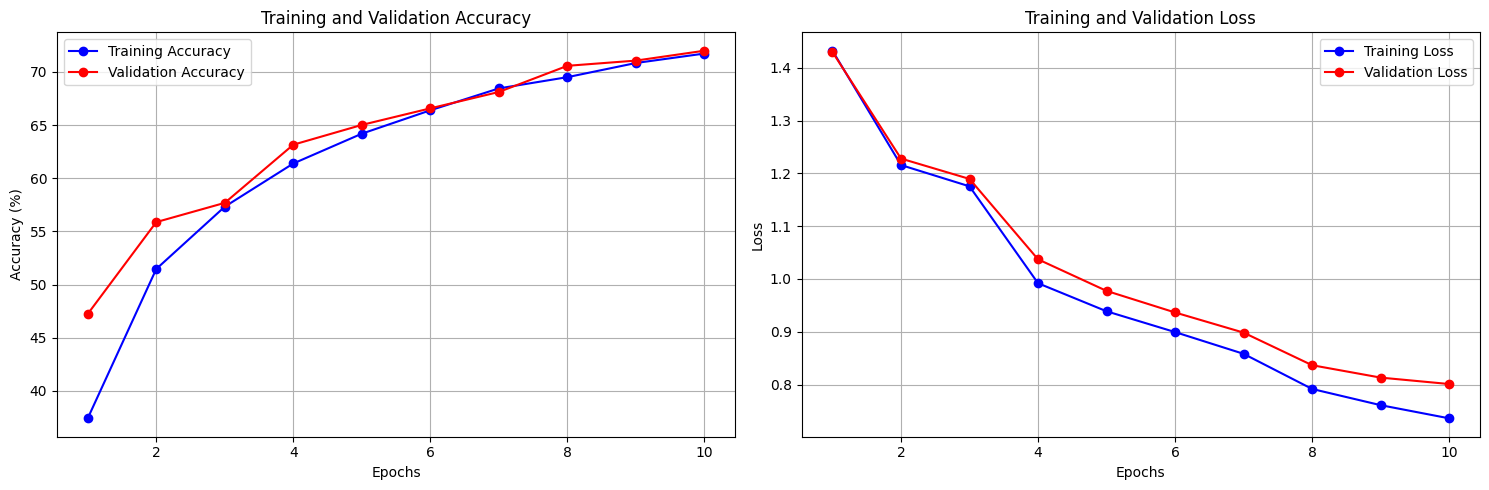


Per-class accuracy:


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


airplane: 75.2%
automobile: 81.9%
bird: 56.9%
cat: 54.3%
deer: 67.7%
dog: 56.7%
frog: 78.6%
horse: 74.9%
ship: 89.0%
truck: 86.7%

Baseline model performance summary:
• Architecture: 4-block CNN (ResNet-inspired)
• No data augmentation
• No max pooling (used stride and global avg pooling)
• Simple Adam optimizer (no scheduler)
• Final accuracy: 71.99%
• Parameters: 124,290


In [ ]:
# Initialize model
print("\nInitializing lighterstill CNN with weight decay...")
model = LighterStillCNN(num_classes=10).to(device)

trained_model, train_accs, val_accs = main(model=model, augment='albumentations', decay=True)

### Observations
Key observation, the overall accuracy went down further but there is more convergence. Before doing anything else, I want to play a bit with the LR scheduler

## LR Scheduler - Cosine

In [24]:
# Initialize model
print("\nInitializing lighterstill  CNN with weight decay...")
model = LighterStillCNN(num_classes=10).to(device)

trained_model, train_accs, val_accs = main(model=model, augment='albumentations', decay=True, scheduler='cosine')


Initializing lighterstill  CNN with weight decay...
BASELINE CNN FOR CIFAR-10
Loading CIFAR-10 dataset...
Using albumentations for augmentation
Training samples: 50000
Test samples: 10000
Total parameters: 124,290
Trainable parameters: 124,290

Model Architecture:
LighterStillCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): BasicBlock(
    (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do1): Dropout(p=0.05, inplace=False)
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do2): Dropout(p=0.05, inplace=False)
    (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),

/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


Batch [100/391], Loss: 1.9189, Acc: 28.03%
Batch [200/391], Loss: 1.6789, Acc: 33.05%
Batch [300/391], Loss: 1.5798, Acc: 35.94%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()



Epoch 1 Summary:
Train Accuracy: 37.91%
Validation Accuracy: 48.06%
Train Loss: 1.4294
Validation Loss: 1.4274
Time: 142.3s

Epoch [2/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


Batch [100/391], Loss: 1.4261, Acc: 47.88%
Batch [200/391], Loss: 1.3693, Acc: 49.12%
Batch [300/391], Loss: 1.3417, Acc: 49.91%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()



Epoch 2 Summary:
Train Accuracy: 50.62%
Validation Accuracy: 53.58%
Train Loss: 1.2847
Validation Loss: 1.3032
Time: 283.1s

Epoch [3/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


Batch [100/391], Loss: 1.2549, Acc: 54.73%
Batch [200/391], Loss: 1.2105, Acc: 55.73%
Batch [300/391], Loss: 1.1744, Acc: 56.39%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()



Epoch 3 Summary:
Train Accuracy: 56.75%
Validation Accuracy: 58.97%
Train Loss: 1.1113
Validation Loss: 1.1345
Time: 142.1s

Epoch [4/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


Batch [100/391], Loss: 1.1261, Acc: 59.55%
Batch [200/391], Loss: 1.0982, Acc: 60.14%
Batch [300/391], Loss: 1.0786, Acc: 60.67%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()



Epoch 4 Summary:
Train Accuracy: 60.84%
Validation Accuracy: 62.85%
Train Loss: 0.9952
Validation Loss: 1.0286
Time: 243.4s

Epoch [5/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


Batch [100/391], Loss: 1.0319, Acc: 63.00%
Batch [200/391], Loss: 1.0173, Acc: 63.34%
Batch [300/391], Loss: 0.9949, Acc: 63.89%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()



Epoch 5 Summary:
Train Accuracy: 63.92%
Validation Accuracy: 65.50%
Train Loss: 0.9214
Validation Loss: 0.9640
Time: 136.8s

Epoch [6/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


Batch [100/391], Loss: 0.9622, Acc: 65.84%
Batch [200/391], Loss: 0.9480, Acc: 66.04%
Batch [300/391], Loss: 0.9544, Acc: 66.08%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()



Epoch 6 Summary:
Train Accuracy: 66.18%
Validation Accuracy: 68.06%
Train Loss: 0.8646
Validation Loss: 0.8987
Time: 134.0s

Epoch [7/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


Batch [100/391], Loss: 0.9223, Acc: 67.15%
Batch [200/391], Loss: 0.9107, Acc: 67.20%
Batch [300/391], Loss: 0.9109, Acc: 67.34%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()



Epoch 7 Summary:
Train Accuracy: 67.64%
Validation Accuracy: 70.16%
Train Loss: 0.8070
Validation Loss: 0.8604
Time: 164.0s

Epoch [8/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


Batch [100/391], Loss: 0.8788, Acc: 69.16%
Batch [200/391], Loss: 0.8690, Acc: 69.11%
Batch [300/391], Loss: 0.8609, Acc: 69.33%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()



Epoch 8 Summary:
Train Accuracy: 69.39%
Validation Accuracy: 70.38%
Train Loss: 0.7811
Validation Loss: 0.8349
Time: 172.1s

Epoch [9/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


Batch [100/391], Loss: 0.8597, Acc: 69.33%
Batch [200/391], Loss: 0.8451, Acc: 69.56%
Batch [300/391], Loss: 0.8442, Acc: 69.85%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()



Epoch 9 Summary:
Train Accuracy: 70.18%
Validation Accuracy: 71.38%
Train Loss: 0.7630
Validation Loss: 0.8145
Time: 1138.1s

Epoch [10/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


Batch [100/391], Loss: 0.8226, Acc: 71.21%
Batch [200/391], Loss: 0.8422, Acc: 70.71%
Batch [300/391], Loss: 0.8405, Acc: 70.61%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()



Epoch 10 Summary:
Train Accuracy: 70.61%
Validation Accuracy: 71.99%
Train Loss: 0.7545
Validation Loss: 0.7959
Time: 1137.8s

TRAINING COMPLETED
Final Validation Accuracy: 71.99%
Best Validation Accuracy: 71.99% (Epoch 10)
Total Parameters: 124,290

Generating training plots...



Per-class accuracy:


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


airplane: 75.7%
automobile: 85.8%
bird: 58.1%
cat: 51.1%
deer: 62.3%
dog: 60.8%
frog: 83.5%
horse: 73.3%
ship: 81.9%
truck: 82.2%

Baseline model performance summary:
• Architecture: 4-block CNN (ResNet-inspired)
• No data augmentation
• No max pooling (used stride and global avg pooling)
• Simple Adam optimizer (no scheduler)
• Final accuracy: 71.99%
• Parameters: 124,290


## LR Scheduler - Step


Initializing lighterstill  CNN with weight decay...
BASELINE CNN FOR CIFAR-10
Loading CIFAR-10 dataset...
Using albumentations for augmentation
Training samples: 50000
Test samples: 10000
Total parameters: 124,290
Trainable parameters: 124,290

Model Architecture:
LighterStillCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): BasicBlock(
    (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do1): Dropout(p=0.05, inplace=False)
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do2): Dropout(p=0.05, inplace=False)
    (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),

/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


Batch [100/391], Loss: 1.9582, Acc: 27.08%
Batch [200/391], Loss: 1.6618, Acc: 32.76%
Batch [300/391], Loss: 1.5491, Acc: 36.06%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()



Epoch 1 Summary:
Train Accuracy: 38.30%
Validation Accuracy: 46.04%
Train Loss: 1.4493
Validation Loss: 1.4528
Time: 140.1s
Using scheduler

Epoch [2/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


Batch [100/391], Loss: 1.4301, Acc: 47.27%
Batch [200/391], Loss: 1.3458, Acc: 49.01%
Batch [300/391], Loss: 1.3381, Acc: 49.68%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()



Epoch 2 Summary:
Train Accuracy: 50.37%
Validation Accuracy: 50.09%
Train Loss: 1.3477
Validation Loss: 1.3629
Time: 140.7s
Using scheduler

Epoch [3/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


Batch [100/391], Loss: 1.2240, Acc: 55.73%
Batch [200/391], Loss: 1.2130, Acc: 55.82%
Batch [300/391], Loss: 1.1748, Acc: 56.49%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()



Epoch 3 Summary:
Train Accuracy: 57.13%
Validation Accuracy: 59.10%
Train Loss: 1.1160
Validation Loss: 1.1323
Time: 143.2s
Using scheduler

Epoch [4/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


Batch [100/391], Loss: 1.1082, Acc: 60.51%
Batch [200/391], Loss: 1.0849, Acc: 60.91%
Batch [300/391], Loss: 1.0616, Acc: 61.35%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()



Epoch 4 Summary:
Train Accuracy: 61.66%
Validation Accuracy: 64.43%
Train Loss: 0.9711
Validation Loss: 0.9917
Time: 142.1s
Using scheduler

Epoch [5/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


Batch [100/391], Loss: 1.0200, Acc: 63.52%
Batch [200/391], Loss: 0.9938, Acc: 63.76%
Batch [300/391], Loss: 0.9853, Acc: 64.24%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()



Epoch 5 Summary:
Train Accuracy: 64.61%
Validation Accuracy: 65.94%
Train Loss: 0.9207
Validation Loss: 0.9622
Time: 141.0s
Using scheduler

Epoch [6/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


Batch [100/391], Loss: 0.9481, Acc: 66.10%
Batch [200/391], Loss: 0.9446, Acc: 66.30%
Batch [300/391], Loss: 0.9344, Acc: 66.55%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()



Epoch 6 Summary:
Train Accuracy: 66.67%
Validation Accuracy: 68.30%
Train Loss: 0.8580
Validation Loss: 0.8876
Time: 134.7s
Using scheduler

Epoch [7/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


Batch [100/391], Loss: 0.8867, Acc: 68.72%
Batch [200/391], Loss: 0.9036, Acc: 68.36%
Batch [300/391], Loss: 0.8891, Acc: 68.38%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()



Epoch 7 Summary:
Train Accuracy: 68.66%
Validation Accuracy: 69.51%
Train Loss: 0.8351
Validation Loss: 0.8753
Time: 139.3s
Using scheduler

Epoch [8/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


Batch [100/391], Loss: 0.8380, Acc: 70.80%
Batch [200/391], Loss: 0.8221, Acc: 71.02%
Batch [300/391], Loss: 0.8238, Acc: 71.02%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()



Epoch 8 Summary:
Train Accuracy: 71.19%
Validation Accuracy: 72.94%
Train Loss: 0.7314
Validation Loss: 0.7760
Time: 140.6s
Using scheduler

Epoch [9/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


Batch [100/391], Loss: 0.7827, Acc: 72.42%
Batch [200/391], Loss: 0.8063, Acc: 71.85%
Batch [300/391], Loss: 0.8025, Acc: 71.82%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()



Epoch 9 Summary:
Train Accuracy: 71.82%
Validation Accuracy: 73.58%
Train Loss: 0.6980
Validation Loss: 0.7562
Time: 140.0s
Using scheduler

Epoch [10/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


Batch [100/391], Loss: 0.7838, Acc: 72.57%
Batch [200/391], Loss: 0.7706, Acc: 72.71%
Batch [300/391], Loss: 0.7791, Acc: 72.79%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()



Epoch 10 Summary:
Train Accuracy: 72.68%
Validation Accuracy: 73.96%
Train Loss: 0.6930
Validation Loss: 0.7616
Time: 140.3s
Using scheduler

TRAINING COMPLETED
Final Validation Accuracy: 73.96%
Best Validation Accuracy: 73.96% (Epoch 10)
Total Parameters: 124,290

Generating training plots...


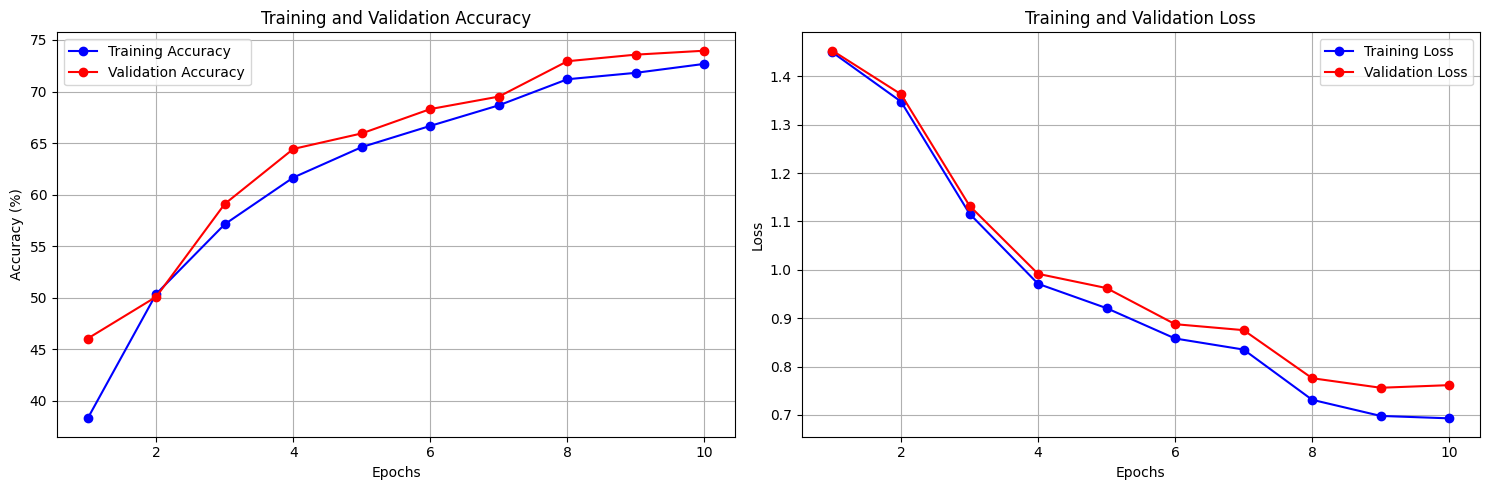


Per-class accuracy:


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:993: The handshake operation timed out>
  data = fetch_version_info()


airplane: 80.1%
automobile: 89.1%
bird: 62.5%
cat: 51.3%
deer: 69.6%
dog: 58.8%
frog: 85.4%
horse: 75.9%
ship: 84.4%
truck: 84.3%

Baseline model performance summary:
• Architecture: 4-block CNN (ResNet-inspired)
• No data augmentation
• No max pooling (used stride and global avg pooling)
• Simple Adam optimizer (no scheduler)
• Final accuracy: 73.96%
• Parameters: 124,290


In [30]:
# Initialize model
print("\nInitializing lighterstill  CNN with weight decay...")
model = LighterStillCNN(num_classes=10).to(device)

trained_model, train_accs, val_accs = main(model=model, augment='albumentations', decay=True, schedule='step')

### Observations
- LR scheduler with steps is giving better performance. Would chaning the learning rates make any difference.

## LR Rate - 0.005


Initializing lighterstill  CNN ...
BASELINE CNN FOR CIFAR-10
Loading CIFAR-10 dataset...
Using albumentations for augmentation
Training samples: 50000
Test samples: 10000
Total parameters: 124,290
Trainable parameters: 124,290

Model Architecture:
LighterStillCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): BasicBlock(
    (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do1): Dropout(p=0.05, inplace=False)
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do2): Dropout(p=0.05, inplace=False)
    (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


Batch [100/391], Loss: 1.8765, Acc: 28.14%
Batch [200/391], Loss: 1.7115, Acc: 31.84%
Batch [300/391], Loss: 1.6285, Acc: 34.19%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()



Epoch 1 Summary:
Train Accuracy: 36.39%
Validation Accuracy: 39.51%
Train Loss: 1.6409
Validation Loss: 1.6339
Time: 126.7s
Using scheduler

Epoch [2/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


Batch [100/391], Loss: 1.4718, Acc: 45.83%
Batch [200/391], Loss: 1.4061, Acc: 47.17%
Batch [300/391], Loss: 1.3629, Acc: 48.10%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()



Epoch 2 Summary:
Train Accuracy: 49.02%
Validation Accuracy: 50.98%
Train Loss: 1.3279
Validation Loss: 1.3250
Time: 181.6s
Using scheduler

Epoch [3/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


Batch [100/391], Loss: 1.2458, Acc: 54.78%
Batch [200/391], Loss: 1.2495, Acc: 55.00%
Batch [300/391], Loss: 1.2046, Acc: 55.47%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()



Epoch 3 Summary:
Train Accuracy: 56.05%
Validation Accuracy: 56.06%
Train Loss: 1.2213
Validation Loss: 1.2352
Time: 126.5s
Using scheduler

Epoch [4/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


Batch [100/391], Loss: 1.1300, Acc: 59.23%
Batch [200/391], Loss: 1.1190, Acc: 59.47%
Batch [300/391], Loss: 1.0881, Acc: 59.94%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()



Epoch 4 Summary:
Train Accuracy: 60.23%
Validation Accuracy: 58.92%
Train Loss: 1.1540
Validation Loss: 1.1780
Time: 126.7s
Using scheduler

Epoch [5/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


Batch [100/391], Loss: 1.0475, Acc: 62.82%
Batch [200/391], Loss: 1.0209, Acc: 63.49%
Batch [300/391], Loss: 1.0315, Acc: 63.48%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()



Epoch 5 Summary:
Train Accuracy: 63.67%
Validation Accuracy: 64.33%
Train Loss: 0.9812
Validation Loss: 1.0015
Time: 126.0s
Using scheduler

Epoch [6/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


Batch [100/391], Loss: 0.9838, Acc: 65.38%
Batch [200/391], Loss: 0.9506, Acc: 65.94%
Batch [300/391], Loss: 0.9756, Acc: 65.77%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()



Epoch 6 Summary:
Train Accuracy: 66.08%
Validation Accuracy: 62.64%
Train Loss: 1.0248
Validation Loss: 1.0606
Time: 126.3s
Using scheduler

Epoch [7/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


Batch [100/391], Loss: 0.9316, Acc: 66.92%
Batch [200/391], Loss: 0.9183, Acc: 67.36%
Batch [300/391], Loss: 0.8964, Acc: 67.74%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()



Epoch 7 Summary:
Train Accuracy: 67.89%
Validation Accuracy: 66.72%
Train Loss: 0.8909
Validation Loss: 0.9378
Time: 126.6s
Using scheduler

Epoch [8/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


Batch [100/391], Loss: 0.8246, Acc: 70.80%
Batch [200/391], Loss: 0.8217, Acc: 71.08%
Batch [300/391], Loss: 0.8127, Acc: 71.14%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()



Epoch 8 Summary:
Train Accuracy: 71.33%
Validation Accuracy: 71.86%
Train Loss: 0.7526
Validation Loss: 0.7959
Time: 126.2s
Using scheduler

Epoch [9/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


Batch [100/391], Loss: 0.7961, Acc: 72.27%
Batch [200/391], Loss: 0.7909, Acc: 72.28%
Batch [300/391], Loss: 0.8083, Acc: 72.06%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()



Epoch 9 Summary:
Train Accuracy: 72.41%
Validation Accuracy: 73.09%
Train Loss: 0.7039
Validation Loss: 0.7553
Time: 126.6s
Using scheduler

Epoch [10/10]
----------------------------------------


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


Batch [100/391], Loss: 0.7858, Acc: 72.34%
Batch [200/391], Loss: 0.7791, Acc: 72.53%
Batch [300/391], Loss: 0.7624, Acc: 72.70%


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()



Epoch 10 Summary:
Train Accuracy: 72.92%
Validation Accuracy: 74.21%
Train Loss: 0.6892
Validation Loss: 0.7366
Time: 127.4s
Using scheduler

TRAINING COMPLETED
Final Validation Accuracy: 74.21%
Best Validation Accuracy: 74.21% (Epoch 10)
Total Parameters: 124,290

Generating training plots...


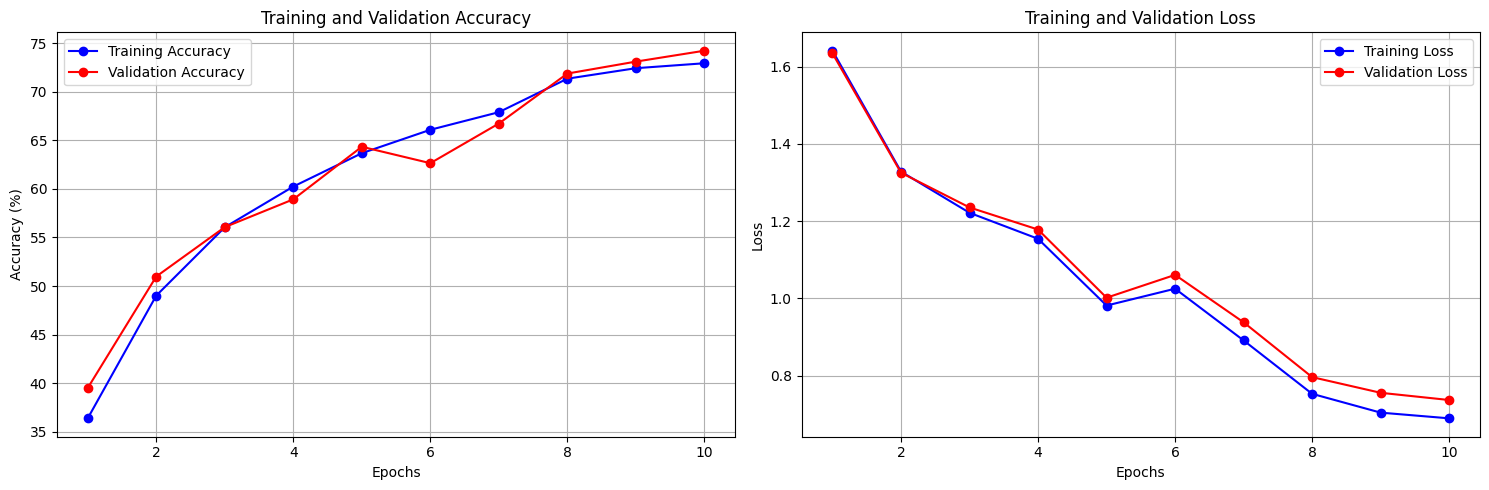


Per-class accuracy:


/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()
/Users/vinodjoshi/erav4/wk7-cifar/.venv/lib/python3.12/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


airplane: 78.0%
automobile: 87.3%
bird: 60.2%
cat: 61.7%
deer: 73.0%
dog: 52.0%
frog: 77.3%
horse: 77.1%
ship: 87.3%
truck: 85.8%

Baseline model performance summary:
• Architecture: 4-block CNN (ResNet-inspired)
• No data augmentation
• No max pooling (used stride and global avg pooling)
• Simple Adam optimizer (no scheduler)
• Final accuracy: 74.21%
• Parameters: 124,290


In [39]:
# Initialize model
print("\nInitializing lighterstill  CNN ...")
model = LighterStillCNN(num_classes=10).to(device)

trained_model, train_accs, val_accs = main(model=model, augment='albumentations', decay=True, schedule='step', lr=0.005)

### Observations
- At a learning rate of 0.005, I see higher accuracy at the end of 10th epoch. I would like to see where the accuracy would reach at the 20th epoch

## Epochs 20


Initializing lighterstill  CNN ...
BASELINE CNN FOR CIFAR-10
Loading CIFAR-10 dataset...
Using albumentations for augmentation
Training samples: 50000
Test samples: 10000
Total parameters: 124,290
Trainable parameters: 124,290

Model Architecture:
LighterStillCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): BasicBlock(
    (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do1): Dropout(p=0.05, inplace=False)
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do2): Dropout(p=0.05, inplace=False)
    (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

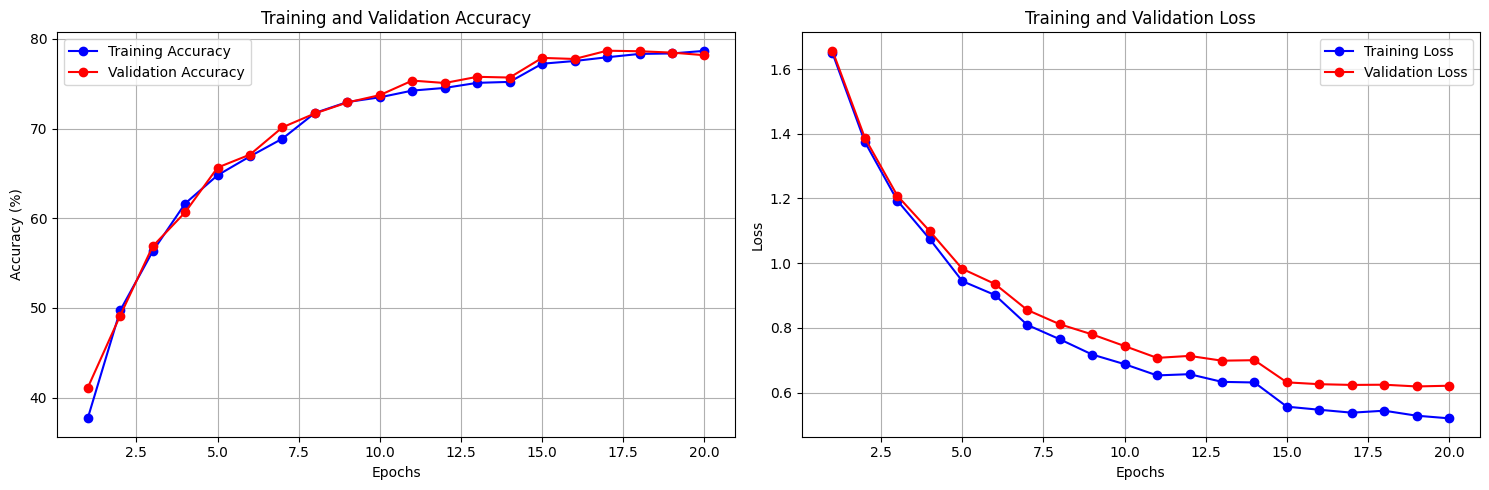


Per-class accuracy:
airplane: 78.9%
automobile: 85.4%
bird: 67.6%
cat: 61.1%
deer: 77.2%
dog: 65.4%
frog: 84.5%
horse: 81.5%
ship: 90.0%
truck: 91.2%

Baseline model performance summary:
• Architecture: 4-block CNN (ResNet-inspired)
• No data augmentation
• No max pooling (used stride and global avg pooling)
• Simple Adam optimizer (no scheduler)
• Final accuracy: 78.18%
• Parameters: 124,290


In [11]:
# Initialize model
print("\nInitializing lighterstill  CNN ...")
model = LighterStillCNN(num_classes=10).to(device)

trained_model, train_accs, val_accs = main(model=model, epochs=20, augment='albumentations', decay=True, schedule='step', lr=0.005)

In [12]:
import os
import torch

# Define the path for saving the model
model_dir = "./model"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "optimized_1_cifar_cnn.pth")

# Save the trained model's state dictionary
torch.save(trained_model.state_dict(), model_path)
print(f"Trained model saved to {model_path}")


Trained model saved to ./model/optimized_1_cifar_cnn.pth


### Observations 
Some key points to note
- With 20 epochs the accuracy has gone upto ~80%. We can get it further up by increasing the parameters, however I am tempted to loo inside the class accuracy.
- Some of the classes like cats and dogs are not performing optimally. I should look into what are these classes being interpreted as mostly when incorrect.

## Analyze Cats/Dogs Class

Using albumentations for augmentation

CAT misclassified:
  → 130 images misclassified as dog
  → 19 images misclassified as ship
  → 67 images misclassified as frog
  → 62 images misclassified as bird
  → 52 images misclassified as deer
  → 31 images misclassified as horse
  → 24 images misclassified as plane
  → 4 images misclassified as car
  → 12 images misclassified as truck

DOG misclassified:
  → 46 images misclassified as deer
  → 133 images misclassified as cat
  → 62 images misclassified as horse
  → 27 images misclassified as frog
  → 43 images misclassified as bird
  → 6 images misclassified as plane
  → 10 images misclassified as truck
  → 10 images misclassified as ship
  → 3 images misclassified as car

Showing examples of misclassified CAT images...


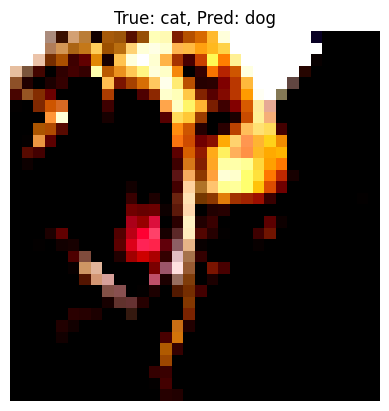

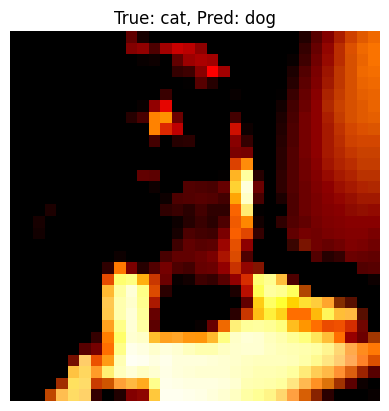

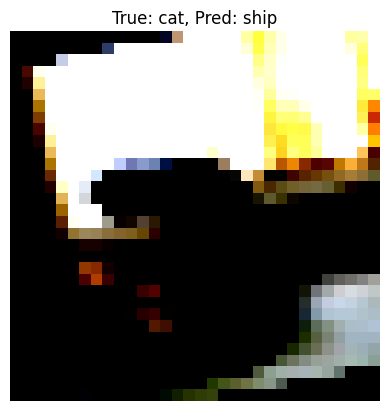

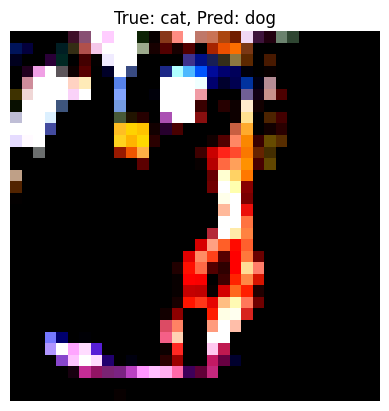

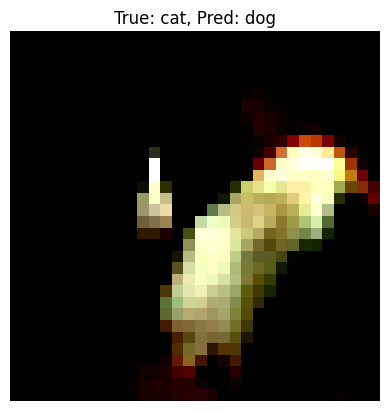


Showing examples of misclassified DOG images...


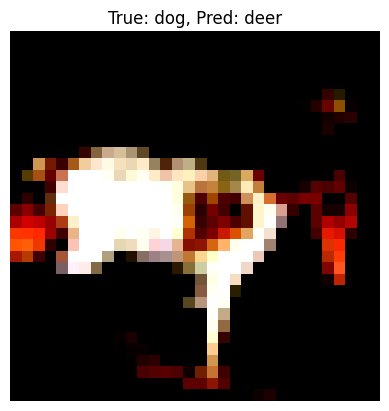

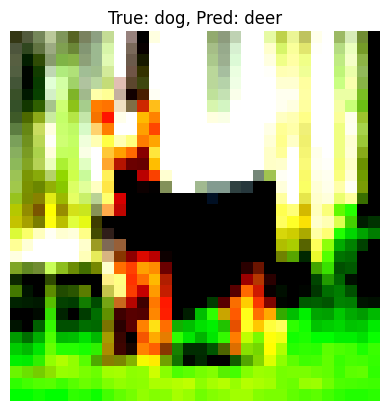

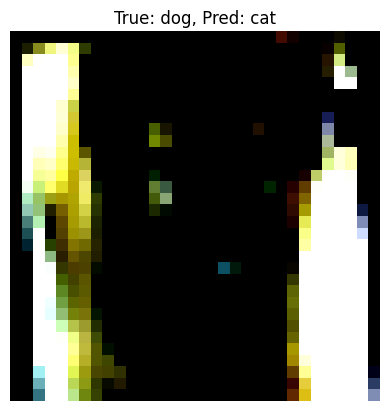

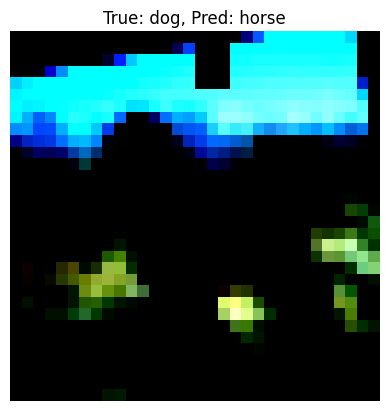

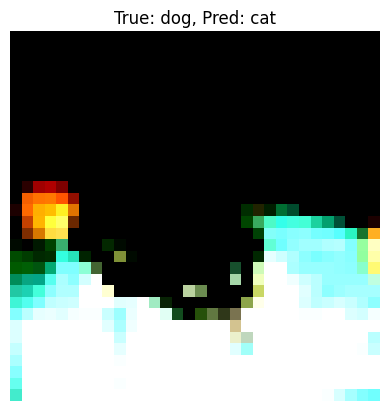

In [13]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# 1. Setup: model, data, device
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your trained model
model = trained_model
model.eval()

_, test_loader = load_cifar10_data(augment='albumentations')


# -------------------------------
# 2. Collect misclassifications
# -------------------------------
misclassified = {'cat': [], 'dog': []}   # store (image, pred_label, true_label)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for img, label, pred in zip(images, labels, preds):
            true_name = classes[label]
            pred_name = classes[pred]

            # Check only for dog & cat misclassified into other classes
            if true_name in ['cat', 'dog'] and pred_name != true_name:
                misclassified[true_name].append((img.cpu(), pred_name, true_name))

# -------------------------------
# 3. Print counts
# -------------------------------
for cls in ['cat', 'dog']:
    print(f"\n{cls.upper()} misclassified:")
    wrong_counts = {}
    for _, pred_name, _ in misclassified[cls]:
        wrong_counts[pred_name] = wrong_counts.get(pred_name, 0) + 1
    for wrong_class, count in wrong_counts.items():
        print(f"  → {count} images misclassified as {wrong_class}")

# -------------------------------
# 4. Show a few misclassified images
# -------------------------------
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Display a few examples
for cls in ['cat', 'dog']:
    print(f"\nShowing examples of misclassified {cls.upper()} images...")
    samples = misclassified[cls][:5]  # show first 5
    for img, pred_name, true_name in samples:
        plt.figure()
        imshow(img, f"True: {true_name}, Pred: {pred_name}")
    plt.show()

### Observations
- Indeed from summary here it is clear that dog and cat are being confused the most.
- Infact if we look at the first image, it appears more like a dog then cat and I as a human would have said it is a dog and not a cat
- Similary dog's classification to deer also looks close.
- How do we handle this misclassification in specific classes. Some options
    -  **Balancing the training data:** Here all classes have same number of samples as such balancing doesn't seemt to be the effective option
    - **Advanced Augmentation:** Can I make my model learn cat and dog even harder way? Maybe. Explore albumentation to see what other transformation can we apply to these 2 classes
    - **More Images Differentiating Cats and Dogs:** Can we add more images for cats and dogs to the training data for it to be able to differentiate well?Maybe but we will leave that option towards the end
    - **Training a more powerful model:** This is certainly an option, that I will use to get closer to the 200K parameters
    - **Training for longer:** is also an option although I would like it to be under 20 epochs. 

## Reduce Strides

In [15]:
# Basic CNN Block with receptive field = 11
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        # To achieve receptive field of 11, we use multiple conv layers
        # Receptive field calculation: RF = 1 + (k1-1) + (k2-1) + (k3-1) + (k4-1)
        # Using 4 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 + 2 = 9
        # Using 3 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 = 7  
        # Using 5 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 + 2 + 2 = 11 ✓
        
        # First conv layer (with potential stride for downsampling)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.do1 = nn.Dropout(0.05)
        
        # Second conv layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.do2 = nn.Dropout(0.05)
        
        # Third conv layer
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
    
    def forward(self, x):
        # Pass through all 5 conv layers for RF=11
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.do1(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.do2(out)
        out = F.relu(self.bn3(self.conv3(out)))
        
        return out

# Baseline CNN Architecture
class LessStridesCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LessStridesCNN, self).__init__()
        
        # Initial conv layer
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(8)
        
        # 4 Basic blocks (inspired by ResNet)
        self.block1 = BasicBlock(8, 8, stride=1)    # 32x32 -> 32x32
        self.block2 = BasicBlock(8, 16, stride=1)   # 32x32 -> 16x16
        self.block3 = BasicBlock(16, 32, stride=1)  # 16x16 -> 8x8
        self.block4 = BasicBlock(32, 64, stride=1)  # 8x8 -> 4x4
        
        # Global Average Pooling (instead of max pooling)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Final classifier
        self.fc = nn.Linear(64, num_classes)
        
    
    def forward(self, x):
        # Initial conv
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Pass through 4 basic blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        # Global average pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        
        # Final classification
        x = self.fc(x)
        
        return x



Initializing less stride  CNN ...
BASELINE CNN FOR CIFAR-10
Loading CIFAR-10 dataset...
Using albumentations for augmentation
Training samples: 50000
Test samples: 10000
Total parameters: 124,290
Trainable parameters: 124,290

Model Architecture:
LessStridesCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): BasicBlock(
    (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do1): Dropout(p=0.05, inplace=False)
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do2): Dropout(p=0.05, inplace=False)
    (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (b

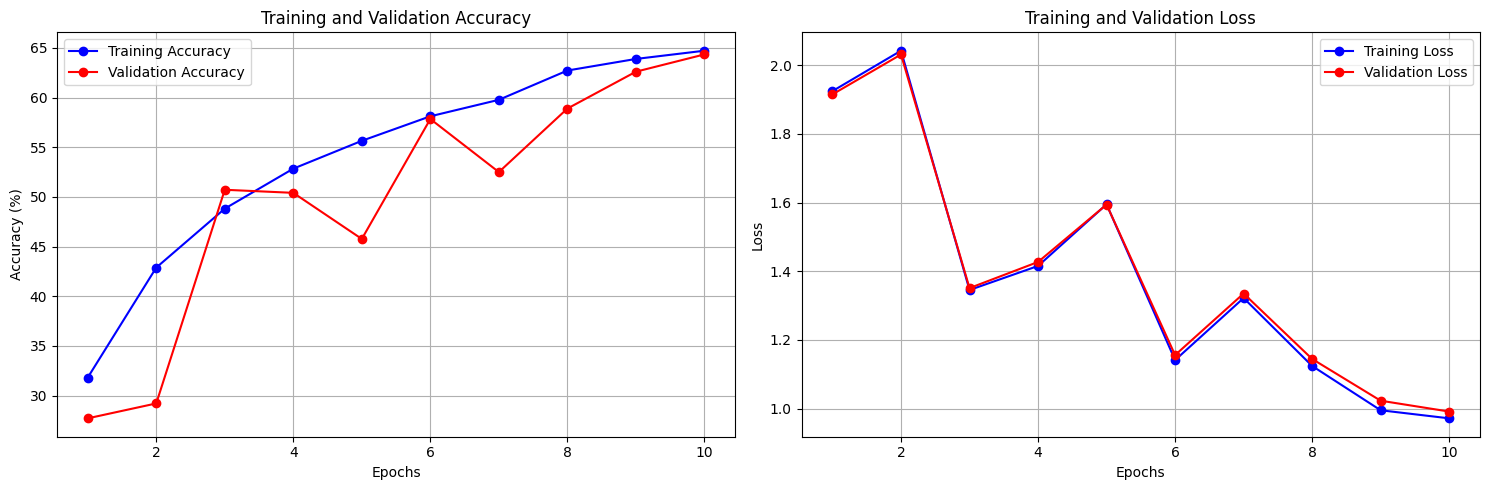


Per-class accuracy:
airplane: 76.2%
automobile: 89.8%
bird: 33.3%
cat: 57.4%
deer: 45.0%
dog: 57.1%
frog: 80.4%
horse: 69.5%
ship: 70.6%
truck: 69.3%

Baseline model performance summary:
• Architecture: 4-block CNN (ResNet-inspired)
• No data augmentation
• No max pooling (used stride and global avg pooling)
• Simple Adam optimizer (no scheduler)
• Final accuracy: 64.34%
• Parameters: 124,290


In [16]:
# Initialize model
print("\nInitializing less stride  CNN ...")
model = LessStridesCNN(num_classes=10).to(device)

trained_model, train_accs, val_accs = main(model=model, epochs=10, augment='albumentations', decay=True, schedule='step', lr=0.005)

## LighterStillPlusCNN

In [19]:
# Basic CNN Block with receptive field = 11
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        # To achieve receptive field of 11, we use multiple conv layers
        # Receptive field calculation: RF = 1 + (k1-1) + (k2-1) + (k3-1) + (k4-1)
        # Using 4 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 + 2 = 9
        # Using 3 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 = 7  
        # Using 5 conv layers with kernel=3: RF = 1 + 2 + 2 + 2 + 2 + 2 = 11 ✓
        
        # First conv layer (with potential stride for downsampling)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.do1 = nn.Dropout(0.05)
        
        # Second conv layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.do2 = nn.Dropout(0.05)
        
        # Third conv layer
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
    
    def forward(self, x):
        # Pass through all 5 conv layers for RF=11
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.do1(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.do2(out)
        out = F.relu(self.bn3(self.conv3(out)))
        
        return out

# Baseline CNN Architecture
class LighterStillPlusCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LighterStillPlusCNN, self).__init__()
        
        # Initial conv layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        
        # 4 Basic blocks (inspired by ResNet)
        self.block1 = BasicBlock(16, 16, stride=1)    # 32x32 -> 32x32
        self.block2 = BasicBlock(16, 32, stride=2)   # 32x32 -> 16x16
        self.block3 = BasicBlock(32, 64, stride=2)  # 16x16 -> 8x8
        self.block4 = BasicBlock(64, 128, stride=2)  # 8x8 -> 4x4
        
        # Global Average Pooling (instead of max pooling)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Final classifier
        self.fc = nn.Linear(128, num_classes)
        
    
    def forward(self, x):
        # Initial conv
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Pass through 4 basic blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        # Global average pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        
        # Final classification
        x = self.fc(x)
        
        return x



Initializing Lighter  CNN Plus...
BASELINE CNN FOR CIFAR-10
Loading CIFAR-10 dataset...
Using albumentations for augmentation
Training samples: 50000
Test samples: 10000
Total parameters: 495,236
Trainable parameters: 495,236

Model Architecture:
LighterStillPlusCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): BasicBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do1): Dropout(p=0.05, inplace=False)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do2): Dropout(p=0.05, inplace=False)
    (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

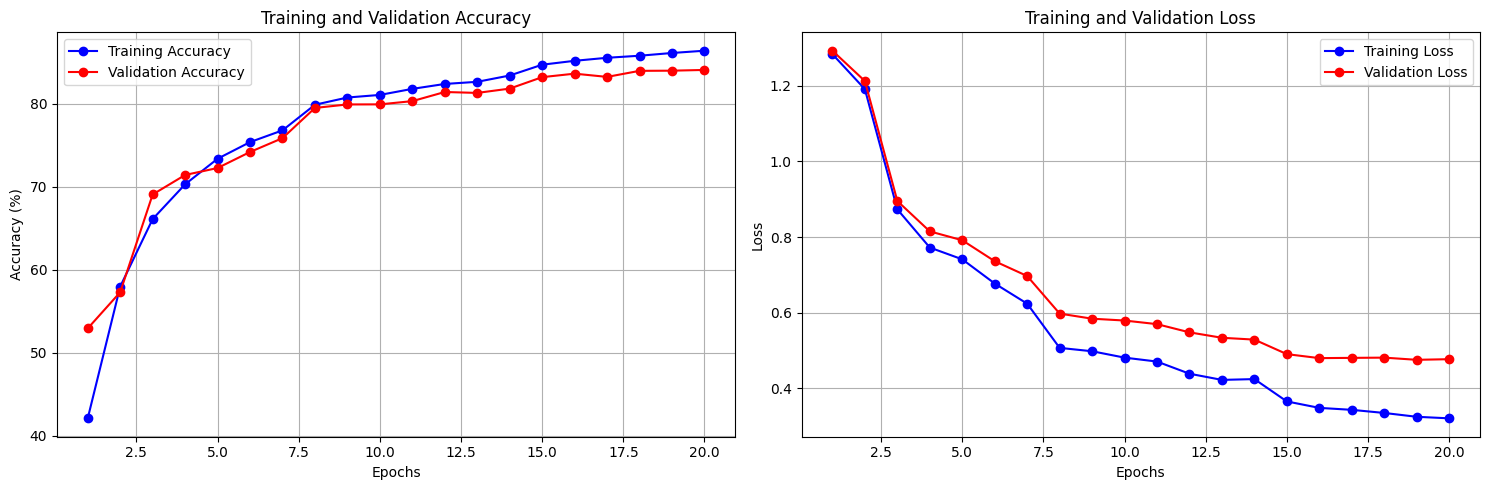


Per-class accuracy:
airplane: 86.1%
automobile: 93.2%
bird: 76.8%
cat: 71.1%
deer: 80.6%
dog: 70.7%
frog: 88.6%
horse: 85.6%
ship: 92.1%
truck: 90.7%

Baseline model performance summary:
• Architecture: 4-block CNN (ResNet-inspired)
• No data augmentation
• No max pooling (used stride and global avg pooling)
• Simple Adam optimizer (no scheduler)
• Final accuracy: 84.06%
• Parameters: 495,236


In [21]:
# Initialize model
print("\nInitializing Lighter  CNN Plus...")
model = LighterStillPlusCNN(num_classes=20).to(device)

trained_model, train_accs, val_accs = main(model=model, epochs=20, augment='albumentations', decay=True, schedule='step', lr=0.001)

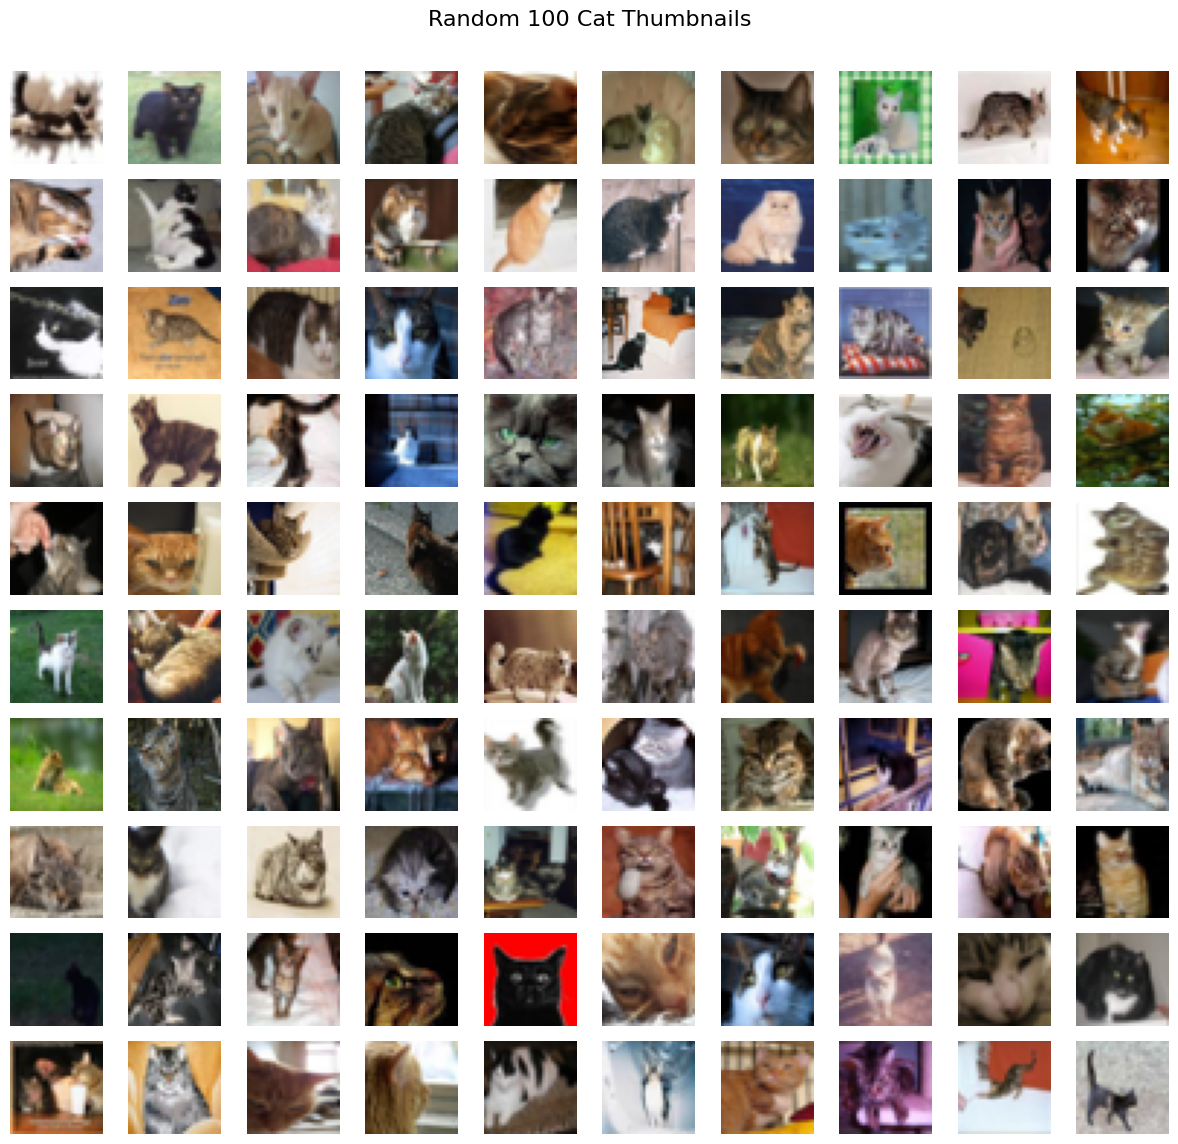

In [23]:
import random
import matplotlib.pyplot as plt

# Determine the label index for 'cat'
cat_label = classes.index('cat') if 'classes' in globals() else 3

# Collect indices of all 'cat' images from the training set
cat_indices = [i for i, lbl in enumerate(trainset.targets) if lbl == cat_label]

# Sample 100 random cat images (ensure we don't exceed available count)
num_thumbnails = 100
selected_indices = random.sample(cat_indices, k=min(num_thumbnails, len(cat_indices)))

# Plot in a 10x10 grid
rows, cols = 10, 10
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
fig.suptitle('Random 100 Cat Thumbnails', fontsize=16)

for idx, ax in enumerate(axes.flatten()):
    if idx < len(selected_indices):
        img, _ = trainset[selected_indices[idx]]
        ax.imshow(img)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()
